In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from matplotlib import pyplot
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
from model_helper import promotion_strategy_indicator, test_results, generate_offer_monthly_data, do_pca, scree_plot, grid_search_indicator_pca

%matplotlib inline

warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
monthly_data = pd.read_csv("monthly_data_rolling.csv")
monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant
0,1.0,2.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0,0,0,0,0,0,0,1,0,3
1,1.0,3.0,10.0,17.63,1.0,17.6300,1,0.0,17.63,1.0,...,0,0,0,0,0,0,0,1,0,1
2,1.0,4.0,10.0,16.27,1.0,16.2700,1,0.0,16.27,1.0,...,0,0,0,0,0,0,0,1,0,1
3,1.0,5.0,10.0,0.00,0.0,0.0000,1,0.0,0.00,0.0,...,0,0,0,0,0,0,0,1,0,3
4,1.0,6.0,10.0,18.11,4.0,4.5275,1,0.0,18.11,1.0,...,0,0,0,0,0,0,0,1,0,1


In [3]:
monthly_data['year_num'] = monthly_data['month_num'] // 12
monthly_data['month_in_year'] = monthly_data['month_num'] % 12
monthly_data['quarter_in_year'] = monthly_data['month_num'] // 4

In [4]:
monthly_data_2 = generate_offer_monthly_data('offer_id_2', monthly_data)

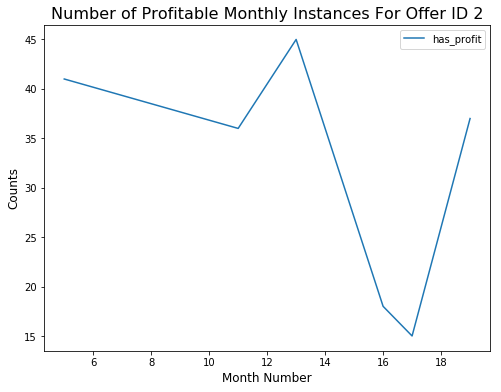

In [5]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_2[monthly_data_2['offer_id_2']==1].groupby('month_num').agg({'has_profit':'sum'}).reset_index().plot(x='month_num', y='has_profit', kind='line', ax=ax);
ax.set_title("Number of Profitable Monthly Instances For Offer ID 2", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

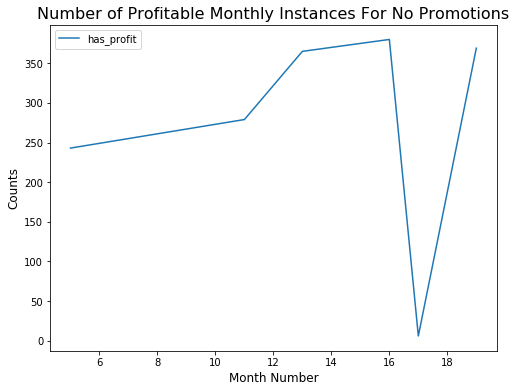

In [13]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_2[monthly_data_2['offer_id_2']==0].groupby('month_num').agg({'has_profit':'sum'}).reset_index().plot(x='month_num', y='has_profit', kind='line', ax=ax);
ax.set_title("Number of Profitable Monthly Instances For No Promotions", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

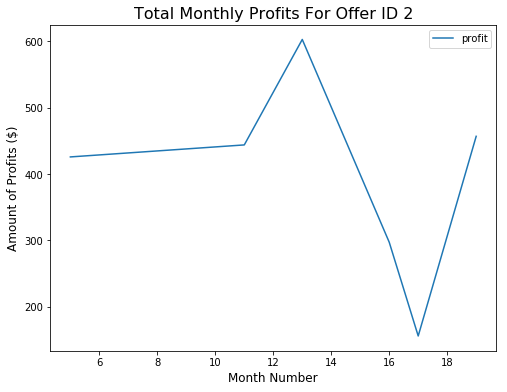

In [11]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_2[monthly_data_2['offer_id_2']==1].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='line', ax=ax);
ax.set_title("Total Monthly Profits For Offer ID 2", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Amount of Profits ($)", fontsize=12);

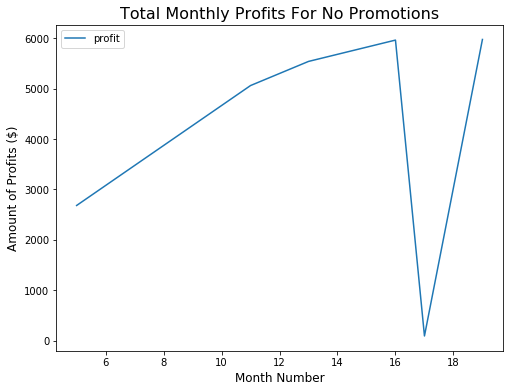

In [12]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_2[monthly_data_2['offer_id_2']==0].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='line', ax=ax);
ax.set_title("Total Monthly Profits For No Promotions", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Amount of Profits ($)", fontsize=12);

In [13]:
# use an approximately 70/15/15 split
train_last_month =  15# 14 months
valid_last_month = 17 # 2 months
test_last_month = 19 # 2 months

train_2 = monthly_data_2[monthly_data_2['month_num']<=train_last_month].reset_index(drop=True)
valid_2 = monthly_data_2[(monthly_data_2['month_num']>train_last_month) & (monthly_data_2['month_num']<=valid_last_month)].reset_index(drop=True)
test_2 = monthly_data_2[(monthly_data_2['month_num']>valid_last_month) & (monthly_data_2['month_num']<=test_last_month)].reset_index(drop=True)

## Baseline Model

In [14]:
offer_num = 2

baseline_valid_strat = np.ones(valid_2.shape[0])
valid_irr, valid_nir = test_results(offer_num, baseline_valid_strat, valid_2)
print("Baseline Model Results")
print("Valid IRR:"+str(valid_irr))
print("Valid NIR:"+str(valid_nir))

print()

baseline_test_strat = np.ones(test_2.shape[0])
test_irr, test_nir = test_results(offer_num, baseline_test_strat, test_2)
print("Baseline Model Results")
print("Valid IRR:"+str(test_irr))
print("Valid NIR:"+str(test_nir))

Baseline Model Results
Valid IRR:-0.3359253499222395
Valid NIR:-5600.92

Baseline Model Results
Valid IRR:-0.3316953316953317
Valid NIR:-5519.620000000001


## Model

In [14]:
features = ['month_num', 
            'year_num', 'month_in_year', 'quarter_in_year',
            'cum_monthly_amt_spent_offer_id_0',
           'cum_num_trans_offer_id_0', 'cum_profit_offer_id_0',
           'cum_monthly_amt_spent_offer_id_1', 'cum_num_trans_offer_id_1',
           'cum_profit_offer_id_1', 'cum_monthly_amt_spent_offer_id_2',
           'cum_num_trans_offer_id_2', 'cum_profit_offer_id_2',
           'cum_monthly_amt_spent_offer_id_3', 'cum_num_trans_offer_id_3',
           'cum_profit_offer_id_3', 'cum_monthly_amt_spent_offer_id_4',
           'cum_num_trans_offer_id_4', 'cum_profit_offer_id_4',
           'cum_monthly_amt_spent_offer_id_5', 'cum_num_trans_offer_id_5',
           'cum_profit_offer_id_5', 'cum_monthly_amt_spent_offer_id_6',
           'cum_num_trans_offer_id_6', 'cum_profit_offer_id_6',
           'cum_monthly_amt_spent_offer_id_7', 'cum_num_trans_offer_id_7',
           'cum_profit_offer_id_7', 'cum_monthly_amt_spent_offer_id_8',
           'cum_num_trans_offer_id_8', 'cum_profit_offer_id_8',
           'cum_monthly_amt_spent_offer_id_9', 'cum_num_trans_offer_id_9',
           'cum_profit_offer_id_9', 'cum_monthly_amt_spent_offer_id_10',
           'cum_num_trans_offer_id_10', 'cum_profit_offer_id_10',
           'cum_spent_per_trans_offer_id_0', 'cum_spent_per_trans_offer_id_1',
           'cum_spent_per_trans_offer_id_2', 'cum_spent_per_trans_offer_id_3',
           'cum_spent_per_trans_offer_id_4', 'cum_spent_per_trans_offer_id_5',
           'cum_spent_per_trans_offer_id_6', 'cum_spent_per_trans_offer_id_7',
           'cum_spent_per_trans_offer_id_8', 'cum_spent_per_trans_offer_id_9',
           'cum_spent_per_trans_offer_id_10',
           'cum_profit_per_trans_offer_id_0',
           'cum_profit_per_trans_offer_id_1',
           'cum_profit_per_trans_offer_id_2',
           'cum_profit_per_trans_offer_id_3',
           'cum_profit_per_trans_offer_id_4',
           'cum_profit_per_trans_offer_id_5',
           'cum_profit_per_trans_offer_id_6',
           'cum_profit_per_trans_offer_id_7',
           'cum_profit_per_trans_offer_id_8',
           'cum_profit_per_trans_offer_id_9',
           'cum_profit_per_trans_offer_id_10', 'cum_total_spend',
           'cum_num_trans', 'cum_profit', 'mov_avg_spent_offer_id_0',
           'mov_avg_spent_offer_id_1', 'mov_avg_spent_offer_id_2',
           'mov_avg_spent_offer_id_3', 'mov_avg_spent_offer_id_4',
           'mov_avg_spent_offer_id_5', 'mov_avg_spent_offer_id_6',
           'mov_avg_spent_offer_id_7', 'mov_avg_spent_offer_id_8',
           'mov_avg_spent_offer_id_9', 'mov_avg_spent_offer_id_10',
            'mov_avg_total_spent',
           'mov_avg_num_trans_offer_id_0', 'mov_avg_num_trans_offer_id_1',
           'mov_avg_num_trans_offer_id_2', 'mov_avg_num_trans_offer_id_3',
           'mov_avg_num_trans_offer_id_4', 'mov_avg_num_trans_offer_id_5',
           'mov_avg_num_trans_offer_id_6', 'mov_avg_num_trans_offer_id_7',
           'mov_avg_num_trans_offer_id_8', 'mov_avg_num_trans_offer_id_9',
           'mov_avg_num_trans_offer_id_10', 'mov_avg_total_num_trans',
            'mov_avg_profit_offer_id_0',
           'mov_avg_profit_offer_id_1', 'mov_avg_profit_offer_id_2',
           'mov_avg_profit_offer_id_3', 'mov_avg_profit_offer_id_4',
           'mov_avg_profit_offer_id_5', 'mov_avg_profit_offer_id_6',
           'mov_avg_profit_offer_id_7', 'mov_avg_profit_offer_id_8',
           'mov_avg_profit_offer_id_9', 'mov_avg_profit_offer_id_10',
            'mov_avg_total_profit',
           'cum_monthly_amt_spent_offer_id_0_1_mo_ago',
           'cum_num_trans_offer_id_0_1_mo_ago',
           'cum_profit_offer_id_0_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_1_1_mo_ago',
           'cum_num_trans_offer_id_1_1_mo_ago',
           'cum_profit_offer_id_1_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_2_1_mo_ago',
           'cum_num_trans_offer_id_2_1_mo_ago',
           'cum_profit_offer_id_2_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_3_1_mo_ago',
           'cum_num_trans_offer_id_3_1_mo_ago',
           'cum_profit_offer_id_3_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_4_1_mo_ago',
           'cum_num_trans_offer_id_4_1_mo_ago',
           'cum_profit_offer_id_4_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_5_1_mo_ago',
           'cum_num_trans_offer_id_5_1_mo_ago',
           'cum_profit_offer_id_5_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_6_1_mo_ago',
           'cum_num_trans_offer_id_6_1_mo_ago',
           'cum_profit_offer_id_6_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_7_1_mo_ago',
           'cum_num_trans_offer_id_7_1_mo_ago',
           'cum_profit_offer_id_7_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_8_1_mo_ago',
           'cum_num_trans_offer_id_8_1_mo_ago',
           'cum_profit_offer_id_8_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_9_1_mo_ago',
           'cum_num_trans_offer_id_9_1_mo_ago',
           'cum_profit_offer_id_9_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_10_1_mo_ago',
           'cum_num_trans_offer_id_10_1_mo_ago',
           'cum_profit_offer_id_10_1_mo_ago',
           'cum_spent_per_trans_offer_id_0_1_mo_ago',
           'cum_spent_per_trans_offer_id_1_1_mo_ago',
           'cum_spent_per_trans_offer_id_2_1_mo_ago',
           'cum_spent_per_trans_offer_id_3_1_mo_ago',
           'cum_spent_per_trans_offer_id_4_1_mo_ago',
           'cum_spent_per_trans_offer_id_5_1_mo_ago',
           'cum_spent_per_trans_offer_id_6_1_mo_ago',
           'cum_spent_per_trans_offer_id_7_1_mo_ago',
           'cum_spent_per_trans_offer_id_8_1_mo_ago',
           'cum_spent_per_trans_offer_id_9_1_mo_ago',
           'cum_spent_per_trans_offer_id_10_1_mo_ago',
           'cum_profit_per_trans_offer_id_0_1_mo_ago',
           'cum_profit_per_trans_offer_id_1_1_mo_ago',
           'cum_profit_per_trans_offer_id_2_1_mo_ago',
           'cum_profit_per_trans_offer_id_3_1_mo_ago',
           'cum_profit_per_trans_offer_id_4_1_mo_ago',
           'cum_profit_per_trans_offer_id_5_1_mo_ago',
           'cum_profit_per_trans_offer_id_6_1_mo_ago',
           'cum_profit_per_trans_offer_id_7_1_mo_ago',
           'cum_profit_per_trans_offer_id_8_1_mo_ago',
           'cum_profit_per_trans_offer_id_9_1_mo_ago',
           'cum_profit_per_trans_offer_id_10_1_mo_ago',
           'cum_total_spend_1_mo_ago', 'cum_num_trans_1_mo_ago',
           'cum_profit_1_mo_ago', 'mov_avg_spent_offer_id_0_1_mo_ago',
           'mov_avg_spent_offer_id_1_1_mo_ago',
           'mov_avg_spent_offer_id_2_1_mo_ago',
           'mov_avg_spent_offer_id_3_1_mo_ago',
           'mov_avg_spent_offer_id_4_1_mo_ago',
           'mov_avg_spent_offer_id_5_1_mo_ago',
           'mov_avg_spent_offer_id_6_1_mo_ago',
           'mov_avg_spent_offer_id_7_1_mo_ago',
           'mov_avg_spent_offer_id_8_1_mo_ago',
           'mov_avg_spent_offer_id_9_1_mo_ago',
           'mov_avg_spent_offer_id_10_1_mo_ago',
            'mov_avg_total_spent_1_mo_ago',
           'mov_avg_num_trans_offer_id_0_1_mo_ago',
           'mov_avg_num_trans_offer_id_1_1_mo_ago',
           'mov_avg_num_trans_offer_id_2_1_mo_ago',
           'mov_avg_num_trans_offer_id_3_1_mo_ago',
           'mov_avg_num_trans_offer_id_4_1_mo_ago',
           'mov_avg_num_trans_offer_id_5_1_mo_ago',
           'mov_avg_num_trans_offer_id_6_1_mo_ago',
           'mov_avg_num_trans_offer_id_7_1_mo_ago',
           'mov_avg_num_trans_offer_id_8_1_mo_ago',
           'mov_avg_num_trans_offer_id_9_1_mo_ago',
           'mov_avg_num_trans_offer_id_10_1_mo_ago',
            'mov_avg_total_num_trans_1_mo_ago',
           'mov_avg_profit_offer_id_0_1_mo_ago',
           'mov_avg_profit_offer_id_1_1_mo_ago',
           'mov_avg_profit_offer_id_2_1_mo_ago',
           'mov_avg_profit_offer_id_3_1_mo_ago',
           'mov_avg_profit_offer_id_4_1_mo_ago',
           'mov_avg_profit_offer_id_5_1_mo_ago',
           'mov_avg_profit_offer_id_6_1_mo_ago',
           'mov_avg_profit_offer_id_7_1_mo_ago',
           'mov_avg_profit_offer_id_8_1_mo_ago',
           'mov_avg_profit_offer_id_9_1_mo_ago',
           'mov_avg_profit_offer_id_10_1_mo_ago',
            'mov_avg_total_profit_1_mo_ago',
            'age', 'income',
           'member_year', 'member_month', 'member_day', 'gender_F',
           'gender_M', 'gender_O']


X_train_2 = train_2[features]
X_valid_2 = valid_2[features]
X_test_2 = test_2[features]

Y_train_2 = train_2.has_profit
Y_valid_2 = valid_2.has_profit
Y_test_2 = test_2.has_profit

In [15]:
# Apply feature scaling
ss = StandardScaler()
X_train_scaled_2 = pd.DataFrame(ss.fit_transform(X_train_2))
X_train_scaled_2.columns = features
X_train_scaled_2.index = X_train_2.index
X_train_scaled_2.head()

X_valid_scaled_2 = pd.DataFrame(ss.transform(X_valid_2))
X_valid_scaled_2.columns = features
X_valid_scaled_2.index = X_valid_2.index

X_test_scaled_2 = pd.DataFrame(ss.transform(X_test_2))
X_test_scaled_2.columns = features
X_test_scaled_2.index = X_test_2.index

C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


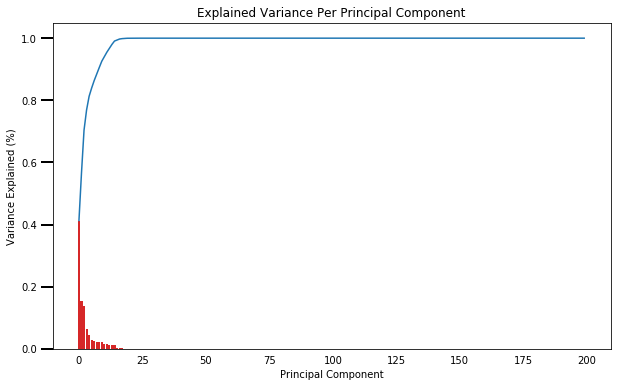

In [16]:
pca, X_train_pca_2 = do_pca(X_train_scaled_2)
scree_plot(pca)

In [17]:
# 20 components explained most variance
n_components = 20
pca, X_train_pca_2 = do_pca(X_train_scaled_2, n_components=n_components)
X_train_pca_2.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,pca_comp_11,pca_comp_12,pca_comp_13,pca_comp_14,pca_comp_15,pca_comp_16,pca_comp_17,pca_comp_18,pca_comp_19
0,-1.909617,0.134322,-0.696653,2.115854,1.303528,0.101318,1.353689,-0.385689,1.129481,0.434862,0.062120,-0.467085,-0.474271,0.759475,-0.322234,-0.680398,0.827591,0.045372,-0.702867,-0.558606
1,-1.909617,0.134322,-0.696653,2.115854,1.303528,0.101318,1.353689,-0.385689,1.129481,0.434862,0.062120,-0.467085,-0.474271,0.759475,-0.322234,-0.680398,0.827591,0.045372,-0.702867,-0.558606
2,-3.155184,-1.052506,1.939298,1.180995,0.368752,2.309371,0.125818,-0.037801,-0.319773,0.543147,0.148762,-0.541179,-0.578747,-0.645276,-0.598294,0.408080,0.051791,0.014819,-0.048005,0.009317
3,-3.155184,-1.052506,1.939298,1.180995,0.368752,2.309371,0.125818,-0.037801,-0.319773,0.543147,0.148762,-0.541179,-0.578747,-0.645276,-0.598294,0.408080,0.051791,0.014819,-0.048005,0.009317
4,-0.012787,-1.188838,2.089858,1.187635,-2.532373,1.023361,0.602455,-0.420713,-0.258640,0.660150,0.386208,-0.621695,-1.488747,1.063049,0.766278,0.497162,-0.103258,0.031018,-0.015396,-0.041645


In [18]:
# transform valid and test
X_valid_pca_2 = pd.DataFrame(pca.transform(X_valid_scaled_2))
X_valid_pca_2.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_valid_pca_2.index = X_valid_scaled_2.index

X_test_pca_2 = pd.DataFrame(pca.transform(X_test_scaled_2))
X_test_pca_2.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_test_pca_2.index = X_test_scaled_2.index

In [19]:
# concat offer ids with X_train, X_valid, X_test
train_ind = train_2['offer_id_2']
valid_ind = valid_2['offer_id_2']
test_ind = test_2['offer_id_2']

X_train_pca_2 = pd.concat([X_train_pca_2, train_ind], axis=1)
X_valid_pca_2 = pd.concat([X_valid_pca_2, valid_ind], axis=1)
X_test_pca_2 = pd.concat([X_test_pca_2, test_ind], axis=1)

In [20]:
# first search to see which parameters to try
max_depth_list = [7]
upsamp_ratio_list = np.arange(0.1, 0.51, 0.1)
min_child_weight_list = np.arange(10, 205, 5)

offer_num = 2

best_depth, best_ratio, best_weight, best_valid_nir, best_test_nir =\
grid_search_indicator_pca(offer_num, max_depth_list, upsamp_ratio_list, min_child_weight_list,\
                          X_train_pca_2, Y_train_2, X_valid_pca_2, Y_valid_2, X_test_pca_2, train_2, valid_2, test_2)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1/195, Depth: 7, Ratio: 0.100, Weight: 10, Valid NIR: -131.97, Test NIR: -111.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2/195, Depth: 7, Ratio: 0.100, Weight: 15, Valid NIR: -578.94, Test NIR: -270.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3/195, Depth: 7, Ratio: 0.100, Weight: 20, Valid NIR: -143.43, Test NIR: -29.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/195, Depth: 7, Ratio: 0.100, Weight: 25, Valid NIR: -185.34, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5/195, Depth: 7, Ratio: 0.100, Weight: 30, Valid NIR: -90.95, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 6/195, Depth: 7, Ratio: 0.100, Weight: 35, Valid NIR: -170.78, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 7/195, Depth: 7, Ratio: 0.100, Weight: 40, Valid NIR: -21.08, Test NIR: -44.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 8/195, Depth: 7, Ratio: 0.100, Weight: 45, Valid NIR: -58.57, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 9/195, Depth: 7, Ratio: 0.100, Weight: 50, Valid NIR: -35.57, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 10/195, Depth: 7, Ratio: 0.100, Weight: 55, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 11/195, Depth: 7, Ratio: 0.100, Weight: 60, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 12/195, Depth: 7, Ratio: 0.100, Weight: 65, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 13/195, Depth: 7, Ratio: 0.100, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 14/195, Depth: 7, Ratio: 0.100, Weight: 75, Valid NIR: 0.00, Test NIR: -3.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 15/195, Depth: 7, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 16/195, Depth: 7, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 17/195, Depth: 7, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 18/195, Depth: 7, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 19/195, Depth: 7, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 20/195, Depth: 7, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 21/195, Depth: 7, Ratio: 0.100, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 22/195, Depth: 7, Ratio: 0.100, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 23/195, Depth: 7, Ratio: 0.100, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 24/195, Depth: 7, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 25/195, Depth: 7, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 26/195, Depth: 7, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 27/195, Depth: 7, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 28/195, Depth: 7, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 29/195, Depth: 7, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 30/195, Depth: 7, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 31/195, Depth: 7, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 32/195, Depth: 7, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 33/195, Depth: 7, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 34/195, Depth: 7, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 35/195, Depth: 7, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 36/195, Depth: 7, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 37/195, Depth: 7, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 38/195, Depth: 7, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 39/195, Depth: 7, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 40/195, Depth: 7, Ratio: 0.200, Weight: 10, Valid NIR: -516.20, Test NIR: -301.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 41/195, Depth: 7, Ratio: 0.200, Weight: 15, Valid NIR: -274.31, Test NIR: -77.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 42/195, Depth: 7, Ratio: 0.200, Weight: 20, Valid NIR: -301.84, Test NIR: -214.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 43/195, Depth: 7, Ratio: 0.200, Weight: 25, Valid NIR: -608.50, Test NIR: -362.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 44/195, Depth: 7, Ratio: 0.200, Weight: 30, Valid NIR: -300.89, Test NIR: -224.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 45/195, Depth: 7, Ratio: 0.200, Weight: 35, Valid NIR: -419.09, Test NIR: -204.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 46/195, Depth: 7, Ratio: 0.200, Weight: 40, Valid NIR: -204.82, Test NIR: -172.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 47/195, Depth: 7, Ratio: 0.200, Weight: 45, Valid NIR: -448.44, Test NIR: -114.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 48/195, Depth: 7, Ratio: 0.200, Weight: 50, Valid NIR: -261.67, Test NIR: -269.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 49/195, Depth: 7, Ratio: 0.200, Weight: 55, Valid NIR: -435.76, Test NIR: -407.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 50/195, Depth: 7, Ratio: 0.200, Weight: 60, Valid NIR: -312.85, Test NIR: -285.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 51/195, Depth: 7, Ratio: 0.200, Weight: 65, Valid NIR: -127.15, Test NIR: -64.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 52/195, Depth: 7, Ratio: 0.200, Weight: 70, Valid NIR: -235.63, Test NIR: -181.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 53/195, Depth: 7, Ratio: 0.200, Weight: 75, Valid NIR: 0.42, Test NIR: -26.08
Current Best Depth: 7, Upsampling Ratio: 0.2, Min Child Weight: 75
Current Best Valid IRR: -0.36, NIR: 0.4200
Current Best Test IRR: -0.33, NIR: -26.0800


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 54/195, Depth: 7, Ratio: 0.200, Weight: 80, Valid NIR: -70.61, Test NIR: -74.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 55/195, Depth: 7, Ratio: 0.200, Weight: 85, Valid NIR: -154.24, Test NIR: -106.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 56/195, Depth: 7, Ratio: 0.200, Weight: 90, Valid NIR: -665.55, Test NIR: -151.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 57/195, Depth: 7, Ratio: 0.200, Weight: 95, Valid NIR: -447.84, Test NIR: -45.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 58/195, Depth: 7, Ratio: 0.200, Weight: 100, Valid NIR: -406.04, Test NIR: -100.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 59/195, Depth: 7, Ratio: 0.200, Weight: 105, Valid NIR: -607.33, Test NIR: -286.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 60/195, Depth: 7, Ratio: 0.200, Weight: 110, Valid NIR: -626.38, Test NIR: -310.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 61/195, Depth: 7, Ratio: 0.200, Weight: 115, Valid NIR: -492.59, Test NIR: -220.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 62/195, Depth: 7, Ratio: 0.200, Weight: 120, Valid NIR: -616.27, Test NIR: -254.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 63/195, Depth: 7, Ratio: 0.200, Weight: 125, Valid NIR: -505.92, Test NIR: -248.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 64/195, Depth: 7, Ratio: 0.200, Weight: 130, Valid NIR: -608.99, Test NIR: -286.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 65/195, Depth: 7, Ratio: 0.200, Weight: 135, Valid NIR: -214.04, Test NIR: -103.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 66/195, Depth: 7, Ratio: 0.200, Weight: 140, Valid NIR: -113.53, Test NIR: -16.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 67/195, Depth: 7, Ratio: 0.200, Weight: 145, Valid NIR: -147.49, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 68/195, Depth: 7, Ratio: 0.200, Weight: 150, Valid NIR: -23.07, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 69/195, Depth: 7, Ratio: 0.200, Weight: 155, Valid NIR: -23.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 70/195, Depth: 7, Ratio: 0.200, Weight: 160, Valid NIR: -115.60, Test NIR: -55.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 71/195, Depth: 7, Ratio: 0.200, Weight: 165, Valid NIR: -83.68, Test NIR: -80.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 72/195, Depth: 7, Ratio: 0.200, Weight: 170, Valid NIR: -56.51, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 73/195, Depth: 7, Ratio: 0.200, Weight: 175, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 74/195, Depth: 7, Ratio: 0.200, Weight: 180, Valid NIR: -35.96, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 75/195, Depth: 7, Ratio: 0.200, Weight: 185, Valid NIR: -59.28, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 76/195, Depth: 7, Ratio: 0.200, Weight: 190, Valid NIR: -77.59, Test NIR: -54.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 77/195, Depth: 7, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 78/195, Depth: 7, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 79/195, Depth: 7, Ratio: 0.300, Weight: 10, Valid NIR: -235.64, Test NIR: -19.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 80/195, Depth: 7, Ratio: 0.300, Weight: 15, Valid NIR: -257.20, Test NIR: -88.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 81/195, Depth: 7, Ratio: 0.300, Weight: 20, Valid NIR: -357.34, Test NIR: -38.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 82/195, Depth: 7, Ratio: 0.300, Weight: 25, Valid NIR: -251.62, Test NIR: -65.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 83/195, Depth: 7, Ratio: 0.300, Weight: 30, Valid NIR: -435.10, Test NIR: -81.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 84/195, Depth: 7, Ratio: 0.300, Weight: 35, Valid NIR: -268.04, Test NIR: -120.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 85/195, Depth: 7, Ratio: 0.300, Weight: 40, Valid NIR: -445.10, Test NIR: -244.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 86/195, Depth: 7, Ratio: 0.300, Weight: 45, Valid NIR: -442.30, Test NIR: -165.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 87/195, Depth: 7, Ratio: 0.300, Weight: 50, Valid NIR: -407.96, Test NIR: -136.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 88/195, Depth: 7, Ratio: 0.300, Weight: 55, Valid NIR: -718.90, Test NIR: -381.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 89/195, Depth: 7, Ratio: 0.300, Weight: 60, Valid NIR: -367.01, Test NIR: -82.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 90/195, Depth: 7, Ratio: 0.300, Weight: 65, Valid NIR: -283.01, Test NIR: -69.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 91/195, Depth: 7, Ratio: 0.300, Weight: 70, Valid NIR: -573.48, Test NIR: -215.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 92/195, Depth: 7, Ratio: 0.300, Weight: 75, Valid NIR: -425.66, Test NIR: -131.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 93/195, Depth: 7, Ratio: 0.300, Weight: 80, Valid NIR: -550.76, Test NIR: -183.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 94/195, Depth: 7, Ratio: 0.300, Weight: 85, Valid NIR: -659.49, Test NIR: -389.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 95/195, Depth: 7, Ratio: 0.300, Weight: 90, Valid NIR: -635.50, Test NIR: -195.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 96/195, Depth: 7, Ratio: 0.300, Weight: 95, Valid NIR: -293.68, Test NIR: -255.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 97/195, Depth: 7, Ratio: 0.300, Weight: 100, Valid NIR: -724.43, Test NIR: -282.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 98/195, Depth: 7, Ratio: 0.300, Weight: 105, Valid NIR: -636.22, Test NIR: -258.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 99/195, Depth: 7, Ratio: 0.300, Weight: 110, Valid NIR: -472.00, Test NIR: -121.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 100/195, Depth: 7, Ratio: 0.300, Weight: 115, Valid NIR: -498.62, Test NIR: -191.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 101/195, Depth: 7, Ratio: 0.300, Weight: 120, Valid NIR: -630.15, Test NIR: -364.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 102/195, Depth: 7, Ratio: 0.300, Weight: 125, Valid NIR: -996.06, Test NIR: -461.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 103/195, Depth: 7, Ratio: 0.300, Weight: 130, Valid NIR: -825.35, Test NIR: -346.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 104/195, Depth: 7, Ratio: 0.300, Weight: 135, Valid NIR: -552.24, Test NIR: -182.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 105/195, Depth: 7, Ratio: 0.300, Weight: 140, Valid NIR: -517.93, Test NIR: -177.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 106/195, Depth: 7, Ratio: 0.300, Weight: 145, Valid NIR: -241.69, Test NIR: -100.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 107/195, Depth: 7, Ratio: 0.300, Weight: 150, Valid NIR: -763.18, Test NIR: -371.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 108/195, Depth: 7, Ratio: 0.300, Weight: 155, Valid NIR: -740.44, Test NIR: -319.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 109/195, Depth: 7, Ratio: 0.300, Weight: 160, Valid NIR: -756.76, Test NIR: -387.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 110/195, Depth: 7, Ratio: 0.300, Weight: 165, Valid NIR: -1434.25, Test NIR: -525.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 111/195, Depth: 7, Ratio: 0.300, Weight: 170, Valid NIR: -1156.28, Test NIR: -462.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 112/195, Depth: 7, Ratio: 0.300, Weight: 175, Valid NIR: -1093.64, Test NIR: -574.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 113/195, Depth: 7, Ratio: 0.300, Weight: 180, Valid NIR: -532.63, Test NIR: -185.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 114/195, Depth: 7, Ratio: 0.300, Weight: 185, Valid NIR: -733.18, Test NIR: -269.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 115/195, Depth: 7, Ratio: 0.300, Weight: 190, Valid NIR: -1230.20, Test NIR: -332.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 116/195, Depth: 7, Ratio: 0.300, Weight: 195, Valid NIR: -2503.40, Test NIR: -1774.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 117/195, Depth: 7, Ratio: 0.300, Weight: 200, Valid NIR: -532.63, Test NIR: -185.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 118/195, Depth: 7, Ratio: 0.400, Weight: 10, Valid NIR: -1226.37, Test NIR: -1044.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 119/195, Depth: 7, Ratio: 0.400, Weight: 15, Valid NIR: -1158.24, Test NIR: -709.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 120/195, Depth: 7, Ratio: 0.400, Weight: 20, Valid NIR: -1606.56, Test NIR: -1257.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 121/195, Depth: 7, Ratio: 0.400, Weight: 25, Valid NIR: -1899.26, Test NIR: -904.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 122/195, Depth: 7, Ratio: 0.400, Weight: 30, Valid NIR: -2085.14, Test NIR: -1335.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 123/195, Depth: 7, Ratio: 0.400, Weight: 35, Valid NIR: -1546.40, Test NIR: -796.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 124/195, Depth: 7, Ratio: 0.400, Weight: 40, Valid NIR: -1066.64, Test NIR: -1006.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 125/195, Depth: 7, Ratio: 0.400, Weight: 45, Valid NIR: -1385.48, Test NIR: -714.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 126/195, Depth: 7, Ratio: 0.400, Weight: 50, Valid NIR: -1039.75, Test NIR: -572.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 127/195, Depth: 7, Ratio: 0.400, Weight: 55, Valid NIR: -2050.83, Test NIR: -1577.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 128/195, Depth: 7, Ratio: 0.400, Weight: 60, Valid NIR: -1788.87, Test NIR: -620.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 129/195, Depth: 7, Ratio: 0.400, Weight: 65, Valid NIR: -1282.03, Test NIR: -525.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 130/195, Depth: 7, Ratio: 0.400, Weight: 70, Valid NIR: -2069.79, Test NIR: -1193.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 131/195, Depth: 7, Ratio: 0.400, Weight: 75, Valid NIR: -1797.20, Test NIR: -910.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 132/195, Depth: 7, Ratio: 0.400, Weight: 80, Valid NIR: -2185.31, Test NIR: -1839.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 133/195, Depth: 7, Ratio: 0.400, Weight: 85, Valid NIR: -2432.30, Test NIR: -1457.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 134/195, Depth: 7, Ratio: 0.400, Weight: 90, Valid NIR: -2669.20, Test NIR: -2181.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 135/195, Depth: 7, Ratio: 0.400, Weight: 95, Valid NIR: -3108.17, Test NIR: -3097.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 136/195, Depth: 7, Ratio: 0.400, Weight: 100, Valid NIR: -2274.82, Test NIR: -1439.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 137/195, Depth: 7, Ratio: 0.400, Weight: 105, Valid NIR: -2716.80, Test NIR: -2201.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 138/195, Depth: 7, Ratio: 0.400, Weight: 110, Valid NIR: -2798.60, Test NIR: -2411.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 139/195, Depth: 7, Ratio: 0.400, Weight: 115, Valid NIR: -3007.99, Test NIR: -2500.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 140/195, Depth: 7, Ratio: 0.400, Weight: 120, Valid NIR: -2921.46, Test NIR: -2393.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 141/195, Depth: 7, Ratio: 0.400, Weight: 125, Valid NIR: -2786.71, Test NIR: -2301.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 142/195, Depth: 7, Ratio: 0.400, Weight: 130, Valid NIR: -3243.50, Test NIR: -3082.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 143/195, Depth: 7, Ratio: 0.400, Weight: 135, Valid NIR: -3383.89, Test NIR: -2605.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 144/195, Depth: 7, Ratio: 0.400, Weight: 140, Valid NIR: -3558.58, Test NIR: -2572.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 145/195, Depth: 7, Ratio: 0.400, Weight: 145, Valid NIR: -3201.66, Test NIR: -2481.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 146/195, Depth: 7, Ratio: 0.400, Weight: 150, Valid NIR: -3588.49, Test NIR: -3764.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 147/195, Depth: 7, Ratio: 0.400, Weight: 155, Valid NIR: -3656.69, Test NIR: -2128.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 148/195, Depth: 7, Ratio: 0.400, Weight: 160, Valid NIR: -3191.49, Test NIR: -2342.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 149/195, Depth: 7, Ratio: 0.400, Weight: 165, Valid NIR: -3502.84, Test NIR: -1691.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 150/195, Depth: 7, Ratio: 0.400, Weight: 170, Valid NIR: -4095.54, Test NIR: -2474.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 151/195, Depth: 7, Ratio: 0.400, Weight: 175, Valid NIR: -4557.66, Test NIR: -3283.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 152/195, Depth: 7, Ratio: 0.400, Weight: 180, Valid NIR: -4160.93, Test NIR: -3705.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 153/195, Depth: 7, Ratio: 0.400, Weight: 185, Valid NIR: -3877.49, Test NIR: -2898.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 154/195, Depth: 7, Ratio: 0.400, Weight: 190, Valid NIR: -2786.62, Test NIR: -1352.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 155/195, Depth: 7, Ratio: 0.400, Weight: 195, Valid NIR: -3284.16, Test NIR: -1812.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 156/195, Depth: 7, Ratio: 0.400, Weight: 200, Valid NIR: -4523.61, Test NIR: -3714.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 157/195, Depth: 7, Ratio: 0.500, Weight: 10, Valid NIR: -1292.67, Test NIR: -658.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 158/195, Depth: 7, Ratio: 0.500, Weight: 15, Valid NIR: -1870.15, Test NIR: -1070.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 159/195, Depth: 7, Ratio: 0.500, Weight: 20, Valid NIR: -1996.30, Test NIR: -982.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 160/195, Depth: 7, Ratio: 0.500, Weight: 25, Valid NIR: -1802.94, Test NIR: -1051.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 161/195, Depth: 7, Ratio: 0.500, Weight: 30, Valid NIR: -1866.58, Test NIR: -810.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 162/195, Depth: 7, Ratio: 0.500, Weight: 35, Valid NIR: -1977.20, Test NIR: -1109.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 163/195, Depth: 7, Ratio: 0.500, Weight: 40, Valid NIR: -2490.43, Test NIR: -1879.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 164/195, Depth: 7, Ratio: 0.500, Weight: 45, Valid NIR: -2453.12, Test NIR: -1492.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 165/195, Depth: 7, Ratio: 0.500, Weight: 50, Valid NIR: -2649.88, Test NIR: -1819.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 166/195, Depth: 7, Ratio: 0.500, Weight: 55, Valid NIR: -1950.45, Test NIR: -1715.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 167/195, Depth: 7, Ratio: 0.500, Weight: 60, Valid NIR: -2590.74, Test NIR: -2346.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 168/195, Depth: 7, Ratio: 0.500, Weight: 65, Valid NIR: -2825.82, Test NIR: -2262.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 169/195, Depth: 7, Ratio: 0.500, Weight: 70, Valid NIR: -3361.90, Test NIR: -2396.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 170/195, Depth: 7, Ratio: 0.500, Weight: 75, Valid NIR: -3351.32, Test NIR: -2227.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 171/195, Depth: 7, Ratio: 0.500, Weight: 80, Valid NIR: -3437.06, Test NIR: -2647.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 172/195, Depth: 7, Ratio: 0.500, Weight: 85, Valid NIR: -3743.28, Test NIR: -2833.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 173/195, Depth: 7, Ratio: 0.500, Weight: 90, Valid NIR: -3843.60, Test NIR: -3221.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 174/195, Depth: 7, Ratio: 0.500, Weight: 95, Valid NIR: -3714.04, Test NIR: -2627.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 175/195, Depth: 7, Ratio: 0.500, Weight: 100, Valid NIR: -3899.58, Test NIR: -3236.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 176/195, Depth: 7, Ratio: 0.500, Weight: 105, Valid NIR: -4477.34, Test NIR: -3466.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 177/195, Depth: 7, Ratio: 0.500, Weight: 110, Valid NIR: -4601.53, Test NIR: -4014.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 178/195, Depth: 7, Ratio: 0.500, Weight: 115, Valid NIR: -4030.33, Test NIR: -2749.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 179/195, Depth: 7, Ratio: 0.500, Weight: 120, Valid NIR: -3731.68, Test NIR: -2957.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 180/195, Depth: 7, Ratio: 0.500, Weight: 125, Valid NIR: -3687.84, Test NIR: -3235.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 181/195, Depth: 7, Ratio: 0.500, Weight: 130, Valid NIR: -4181.07, Test NIR: -2964.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 182/195, Depth: 7, Ratio: 0.500, Weight: 135, Valid NIR: -4202.95, Test NIR: -3691.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 183/195, Depth: 7, Ratio: 0.500, Weight: 140, Valid NIR: -4684.03, Test NIR: -3809.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 184/195, Depth: 7, Ratio: 0.500, Weight: 145, Valid NIR: -4654.48, Test NIR: -3296.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 185/195, Depth: 7, Ratio: 0.500, Weight: 150, Valid NIR: -3728.61, Test NIR: -2809.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 186/195, Depth: 7, Ratio: 0.500, Weight: 155, Valid NIR: -4613.38, Test NIR: -3956.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 187/195, Depth: 7, Ratio: 0.500, Weight: 160, Valid NIR: -4869.27, Test NIR: -4288.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 188/195, Depth: 7, Ratio: 0.500, Weight: 165, Valid NIR: -4475.24, Test NIR: -3841.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 189/195, Depth: 7, Ratio: 0.500, Weight: 170, Valid NIR: -4584.08, Test NIR: -3911.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 190/195, Depth: 7, Ratio: 0.500, Weight: 175, Valid NIR: -4003.55, Test NIR: -3827.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 191/195, Depth: 7, Ratio: 0.500, Weight: 180, Valid NIR: -4159.35, Test NIR: -3862.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 192/195, Depth: 7, Ratio: 0.500, Weight: 185, Valid NIR: -4097.41, Test NIR: -3655.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 193/195, Depth: 7, Ratio: 0.500, Weight: 190, Valid NIR: -4548.32, Test NIR: -4006.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 194/195, Depth: 7, Ratio: 0.500, Weight: 195, Valid NIR: -4419.24, Test NIR: -3748.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 195/195, Depth: 7, Ratio: 0.500, Weight: 200, Valid NIR: -4974.94, Test NIR: -4612.57


In [21]:
print(best_depth)
print(best_ratio)
print(best_weight)
print(best_valid_nir)
print(best_test_nir)

7
0.2
75
0.4199999999999946
-26.080000000000002


In [22]:
max_depth_list = [7,8,9]
upsamp_ratio_list = np.arange(0.04, 0.31, 0.01)
min_child_weight_list = np.arange(10, 205, 5)

offer_num = 2

best_depth, best_ratio, best_weight, best_valid_nir, best_test_nir =\
grid_search_indicator_pca(offer_num, max_depth_list, upsamp_ratio_list, min_child_weight_list,\
                          X_train_pca_2, Y_train_2, X_valid_pca_2, Y_valid_2, X_test_pca_2, train_2, valid_2, test_2)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1/3159, Depth: 7, Ratio: 0.040, Weight: 10, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2/3159, Depth: 7, Ratio: 0.040, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3/3159, Depth: 7, Ratio: 0.040, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/3159, Depth: 7, Ratio: 0.040, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5/3159, Depth: 7, Ratio: 0.040, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 6/3159, Depth: 7, Ratio: 0.040, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 7/3159, Depth: 7, Ratio: 0.040, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 8/3159, Depth: 7, Ratio: 0.040, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 9/3159, Depth: 7, Ratio: 0.040, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 10/3159, Depth: 7, Ratio: 0.040, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 11/3159, Depth: 7, Ratio: 0.040, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 12/3159, Depth: 7, Ratio: 0.040, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 13/3159, Depth: 7, Ratio: 0.040, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 14/3159, Depth: 7, Ratio: 0.040, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 15/3159, Depth: 7, Ratio: 0.040, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 16/3159, Depth: 7, Ratio: 0.040, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 17/3159, Depth: 7, Ratio: 0.040, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 18/3159, Depth: 7, Ratio: 0.040, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 19/3159, Depth: 7, Ratio: 0.040, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 20/3159, Depth: 7, Ratio: 0.040, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 21/3159, Depth: 7, Ratio: 0.040, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 22/3159, Depth: 7, Ratio: 0.040, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 23/3159, Depth: 7, Ratio: 0.040, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 24/3159, Depth: 7, Ratio: 0.040, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 25/3159, Depth: 7, Ratio: 0.040, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 26/3159, Depth: 7, Ratio: 0.040, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 27/3159, Depth: 7, Ratio: 0.040, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 28/3159, Depth: 7, Ratio: 0.040, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 29/3159, Depth: 7, Ratio: 0.040, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 30/3159, Depth: 7, Ratio: 0.040, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 31/3159, Depth: 7, Ratio: 0.040, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 32/3159, Depth: 7, Ratio: 0.040, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 33/3159, Depth: 7, Ratio: 0.040, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 34/3159, Depth: 7, Ratio: 0.040, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 35/3159, Depth: 7, Ratio: 0.040, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 36/3159, Depth: 7, Ratio: 0.040, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 37/3159, Depth: 7, Ratio: 0.040, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 38/3159, Depth: 7, Ratio: 0.040, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 39/3159, Depth: 7, Ratio: 0.040, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 40/3159, Depth: 7, Ratio: 0.050, Weight: 10, Valid NIR: -11.67, Test NIR: -0.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 41/3159, Depth: 7, Ratio: 0.050, Weight: 15, Valid NIR: -52.85, Test NIR: -36.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 42/3159, Depth: 7, Ratio: 0.050, Weight: 20, Valid NIR: -16.44, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 43/3159, Depth: 7, Ratio: 0.050, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 44/3159, Depth: 7, Ratio: 0.050, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 45/3159, Depth: 7, Ratio: 0.050, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 46/3159, Depth: 7, Ratio: 0.050, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 47/3159, Depth: 7, Ratio: 0.050, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 48/3159, Depth: 7, Ratio: 0.050, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 49/3159, Depth: 7, Ratio: 0.050, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 50/3159, Depth: 7, Ratio: 0.050, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 51/3159, Depth: 7, Ratio: 0.050, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 52/3159, Depth: 7, Ratio: 0.050, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 53/3159, Depth: 7, Ratio: 0.050, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 54/3159, Depth: 7, Ratio: 0.050, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 55/3159, Depth: 7, Ratio: 0.050, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 56/3159, Depth: 7, Ratio: 0.050, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 57/3159, Depth: 7, Ratio: 0.050, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 58/3159, Depth: 7, Ratio: 0.050, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 59/3159, Depth: 7, Ratio: 0.050, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 60/3159, Depth: 7, Ratio: 0.050, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 61/3159, Depth: 7, Ratio: 0.050, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 62/3159, Depth: 7, Ratio: 0.050, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 63/3159, Depth: 7, Ratio: 0.050, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 64/3159, Depth: 7, Ratio: 0.050, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 65/3159, Depth: 7, Ratio: 0.050, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 66/3159, Depth: 7, Ratio: 0.050, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 67/3159, Depth: 7, Ratio: 0.050, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 68/3159, Depth: 7, Ratio: 0.050, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 69/3159, Depth: 7, Ratio: 0.050, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 70/3159, Depth: 7, Ratio: 0.050, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 71/3159, Depth: 7, Ratio: 0.050, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 72/3159, Depth: 7, Ratio: 0.050, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 73/3159, Depth: 7, Ratio: 0.050, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 74/3159, Depth: 7, Ratio: 0.050, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 75/3159, Depth: 7, Ratio: 0.050, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 76/3159, Depth: 7, Ratio: 0.050, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 77/3159, Depth: 7, Ratio: 0.050, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 78/3159, Depth: 7, Ratio: 0.050, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 79/3159, Depth: 7, Ratio: 0.060, Weight: 10, Valid NIR: -225.88, Test NIR: -81.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 80/3159, Depth: 7, Ratio: 0.060, Weight: 15, Valid NIR: -101.92, Test NIR: -22.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 81/3159, Depth: 7, Ratio: 0.060, Weight: 20, Valid NIR: -39.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 82/3159, Depth: 7, Ratio: 0.060, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 83/3159, Depth: 7, Ratio: 0.060, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 84/3159, Depth: 7, Ratio: 0.060, Weight: 35, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 85/3159, Depth: 7, Ratio: 0.060, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 86/3159, Depth: 7, Ratio: 0.060, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 87/3159, Depth: 7, Ratio: 0.060, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 88/3159, Depth: 7, Ratio: 0.060, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 89/3159, Depth: 7, Ratio: 0.060, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 90/3159, Depth: 7, Ratio: 0.060, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 91/3159, Depth: 7, Ratio: 0.060, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 92/3159, Depth: 7, Ratio: 0.060, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 93/3159, Depth: 7, Ratio: 0.060, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 94/3159, Depth: 7, Ratio: 0.060, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 95/3159, Depth: 7, Ratio: 0.060, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 96/3159, Depth: 7, Ratio: 0.060, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 97/3159, Depth: 7, Ratio: 0.060, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 98/3159, Depth: 7, Ratio: 0.060, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 99/3159, Depth: 7, Ratio: 0.060, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 100/3159, Depth: 7, Ratio: 0.060, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 101/3159, Depth: 7, Ratio: 0.060, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 102/3159, Depth: 7, Ratio: 0.060, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 103/3159, Depth: 7, Ratio: 0.060, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 104/3159, Depth: 7, Ratio: 0.060, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 105/3159, Depth: 7, Ratio: 0.060, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 106/3159, Depth: 7, Ratio: 0.060, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 107/3159, Depth: 7, Ratio: 0.060, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 108/3159, Depth: 7, Ratio: 0.060, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 109/3159, Depth: 7, Ratio: 0.060, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 110/3159, Depth: 7, Ratio: 0.060, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 111/3159, Depth: 7, Ratio: 0.060, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 112/3159, Depth: 7, Ratio: 0.060, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 113/3159, Depth: 7, Ratio: 0.060, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 114/3159, Depth: 7, Ratio: 0.060, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 115/3159, Depth: 7, Ratio: 0.060, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 116/3159, Depth: 7, Ratio: 0.060, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 117/3159, Depth: 7, Ratio: 0.060, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 118/3159, Depth: 7, Ratio: 0.070, Weight: 10, Valid NIR: -1255.94, Test NIR: -492.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 119/3159, Depth: 7, Ratio: 0.070, Weight: 15, Valid NIR: -483.28, Test NIR: -325.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 120/3159, Depth: 7, Ratio: 0.070, Weight: 20, Valid NIR: -61.04, Test NIR: 12.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 121/3159, Depth: 7, Ratio: 0.070, Weight: 25, Valid NIR: -28.86, Test NIR: -1.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 122/3159, Depth: 7, Ratio: 0.070, Weight: 30, Valid NIR: -77.06, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 123/3159, Depth: 7, Ratio: 0.070, Weight: 35, Valid NIR: -14.93, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 124/3159, Depth: 7, Ratio: 0.070, Weight: 40, Valid NIR: -14.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 125/3159, Depth: 7, Ratio: 0.070, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 126/3159, Depth: 7, Ratio: 0.070, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 127/3159, Depth: 7, Ratio: 0.070, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 128/3159, Depth: 7, Ratio: 0.070, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 129/3159, Depth: 7, Ratio: 0.070, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 130/3159, Depth: 7, Ratio: 0.070, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 131/3159, Depth: 7, Ratio: 0.070, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 132/3159, Depth: 7, Ratio: 0.070, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 133/3159, Depth: 7, Ratio: 0.070, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 134/3159, Depth: 7, Ratio: 0.070, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 135/3159, Depth: 7, Ratio: 0.070, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 136/3159, Depth: 7, Ratio: 0.070, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 137/3159, Depth: 7, Ratio: 0.070, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 138/3159, Depth: 7, Ratio: 0.070, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 139/3159, Depth: 7, Ratio: 0.070, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 140/3159, Depth: 7, Ratio: 0.070, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 141/3159, Depth: 7, Ratio: 0.070, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 142/3159, Depth: 7, Ratio: 0.070, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 143/3159, Depth: 7, Ratio: 0.070, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 144/3159, Depth: 7, Ratio: 0.070, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 145/3159, Depth: 7, Ratio: 0.070, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 146/3159, Depth: 7, Ratio: 0.070, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 147/3159, Depth: 7, Ratio: 0.070, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 148/3159, Depth: 7, Ratio: 0.070, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 149/3159, Depth: 7, Ratio: 0.070, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 150/3159, Depth: 7, Ratio: 0.070, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 151/3159, Depth: 7, Ratio: 0.070, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 152/3159, Depth: 7, Ratio: 0.070, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 153/3159, Depth: 7, Ratio: 0.070, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 154/3159, Depth: 7, Ratio: 0.070, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 155/3159, Depth: 7, Ratio: 0.070, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 156/3159, Depth: 7, Ratio: 0.070, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 157/3159, Depth: 7, Ratio: 0.080, Weight: 10, Valid NIR: -178.55, Test NIR: -87.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 158/3159, Depth: 7, Ratio: 0.080, Weight: 15, Valid NIR: -189.69, Test NIR: -42.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 159/3159, Depth: 7, Ratio: 0.080, Weight: 20, Valid NIR: -26.97, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 160/3159, Depth: 7, Ratio: 0.080, Weight: 25, Valid NIR: -85.39, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 161/3159, Depth: 7, Ratio: 0.080, Weight: 30, Valid NIR: -47.73, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 162/3159, Depth: 7, Ratio: 0.080, Weight: 35, Valid NIR: -22.00, Test NIR: -28.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 163/3159, Depth: 7, Ratio: 0.080, Weight: 40, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 164/3159, Depth: 7, Ratio: 0.080, Weight: 45, Valid NIR: -1.58, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 165/3159, Depth: 7, Ratio: 0.080, Weight: 50, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 166/3159, Depth: 7, Ratio: 0.080, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 167/3159, Depth: 7, Ratio: 0.080, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 168/3159, Depth: 7, Ratio: 0.080, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 169/3159, Depth: 7, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 170/3159, Depth: 7, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 171/3159, Depth: 7, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 172/3159, Depth: 7, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 173/3159, Depth: 7, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 174/3159, Depth: 7, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 175/3159, Depth: 7, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 176/3159, Depth: 7, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 177/3159, Depth: 7, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 178/3159, Depth: 7, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 179/3159, Depth: 7, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 180/3159, Depth: 7, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 181/3159, Depth: 7, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 182/3159, Depth: 7, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 183/3159, Depth: 7, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 184/3159, Depth: 7, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 185/3159, Depth: 7, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 186/3159, Depth: 7, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 187/3159, Depth: 7, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 188/3159, Depth: 7, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 189/3159, Depth: 7, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 190/3159, Depth: 7, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 191/3159, Depth: 7, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 192/3159, Depth: 7, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 193/3159, Depth: 7, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 194/3159, Depth: 7, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 195/3159, Depth: 7, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 196/3159, Depth: 7, Ratio: 0.090, Weight: 10, Valid NIR: -849.14, Test NIR: -699.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 197/3159, Depth: 7, Ratio: 0.090, Weight: 15, Valid NIR: -309.67, Test NIR: -147.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 198/3159, Depth: 7, Ratio: 0.090, Weight: 20, Valid NIR: -142.78, Test NIR: 1.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 199/3159, Depth: 7, Ratio: 0.090, Weight: 25, Valid NIR: -185.07, Test NIR: -74.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 200/3159, Depth: 7, Ratio: 0.090, Weight: 30, Valid NIR: -118.54, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 201/3159, Depth: 7, Ratio: 0.090, Weight: 35, Valid NIR: -192.41, Test NIR: -74.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 202/3159, Depth: 7, Ratio: 0.090, Weight: 40, Valid NIR: -47.20, Test NIR: -10.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 203/3159, Depth: 7, Ratio: 0.090, Weight: 45, Valid NIR: -39.95, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 204/3159, Depth: 7, Ratio: 0.090, Weight: 50, Valid NIR: -4.57, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 205/3159, Depth: 7, Ratio: 0.090, Weight: 55, Valid NIR: -4.57, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 206/3159, Depth: 7, Ratio: 0.090, Weight: 60, Valid NIR: -6.15, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 207/3159, Depth: 7, Ratio: 0.090, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 208/3159, Depth: 7, Ratio: 0.090, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 209/3159, Depth: 7, Ratio: 0.090, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 210/3159, Depth: 7, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 211/3159, Depth: 7, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 212/3159, Depth: 7, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 213/3159, Depth: 7, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 214/3159, Depth: 7, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 215/3159, Depth: 7, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 216/3159, Depth: 7, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 217/3159, Depth: 7, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 218/3159, Depth: 7, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 219/3159, Depth: 7, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 220/3159, Depth: 7, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 221/3159, Depth: 7, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 222/3159, Depth: 7, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 223/3159, Depth: 7, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 224/3159, Depth: 7, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 225/3159, Depth: 7, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 226/3159, Depth: 7, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 227/3159, Depth: 7, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 228/3159, Depth: 7, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 229/3159, Depth: 7, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 230/3159, Depth: 7, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 231/3159, Depth: 7, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 232/3159, Depth: 7, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 233/3159, Depth: 7, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 234/3159, Depth: 7, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 235/3159, Depth: 7, Ratio: 0.100, Weight: 10, Valid NIR: -1746.00, Test NIR: -1070.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 236/3159, Depth: 7, Ratio: 0.100, Weight: 15, Valid NIR: -578.94, Test NIR: -270.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 237/3159, Depth: 7, Ratio: 0.100, Weight: 20, Valid NIR: -143.43, Test NIR: -29.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 238/3159, Depth: 7, Ratio: 0.100, Weight: 25, Valid NIR: -185.34, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 239/3159, Depth: 7, Ratio: 0.100, Weight: 30, Valid NIR: -90.95, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 240/3159, Depth: 7, Ratio: 0.100, Weight: 35, Valid NIR: -170.78, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 241/3159, Depth: 7, Ratio: 0.100, Weight: 40, Valid NIR: -21.08, Test NIR: -44.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 242/3159, Depth: 7, Ratio: 0.100, Weight: 45, Valid NIR: -58.57, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 243/3159, Depth: 7, Ratio: 0.100, Weight: 50, Valid NIR: -35.57, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 244/3159, Depth: 7, Ratio: 0.100, Weight: 55, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 245/3159, Depth: 7, Ratio: 0.100, Weight: 60, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 246/3159, Depth: 7, Ratio: 0.100, Weight: 65, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 247/3159, Depth: 7, Ratio: 0.100, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 248/3159, Depth: 7, Ratio: 0.100, Weight: 75, Valid NIR: 0.00, Test NIR: -3.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 249/3159, Depth: 7, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 250/3159, Depth: 7, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 251/3159, Depth: 7, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 252/3159, Depth: 7, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 253/3159, Depth: 7, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 254/3159, Depth: 7, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 255/3159, Depth: 7, Ratio: 0.100, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 256/3159, Depth: 7, Ratio: 0.100, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 257/3159, Depth: 7, Ratio: 0.100, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 258/3159, Depth: 7, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 259/3159, Depth: 7, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 260/3159, Depth: 7, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 261/3159, Depth: 7, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 262/3159, Depth: 7, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 263/3159, Depth: 7, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 264/3159, Depth: 7, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 265/3159, Depth: 7, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 266/3159, Depth: 7, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 267/3159, Depth: 7, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 268/3159, Depth: 7, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 269/3159, Depth: 7, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 270/3159, Depth: 7, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 271/3159, Depth: 7, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 272/3159, Depth: 7, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 273/3159, Depth: 7, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 274/3159, Depth: 7, Ratio: 0.110, Weight: 10, Valid NIR: -442.69, Test NIR: -198.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 275/3159, Depth: 7, Ratio: 0.110, Weight: 15, Valid NIR: -444.27, Test NIR: -315.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 276/3159, Depth: 7, Ratio: 0.110, Weight: 20, Valid NIR: -90.11, Test NIR: 12.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 277/3159, Depth: 7, Ratio: 0.110, Weight: 25, Valid NIR: -55.42, Test NIR: -9.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 278/3159, Depth: 7, Ratio: 0.110, Weight: 30, Valid NIR: -101.89, Test NIR: -7.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 279/3159, Depth: 7, Ratio: 0.110, Weight: 35, Valid NIR: -59.95, Test NIR: -35.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 280/3159, Depth: 7, Ratio: 0.110, Weight: 40, Valid NIR: -54.95, Test NIR: -7.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 281/3159, Depth: 7, Ratio: 0.110, Weight: 45, Valid NIR: -91.96, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 282/3159, Depth: 7, Ratio: 0.110, Weight: 50, Valid NIR: -87.37, Test NIR: -50.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 283/3159, Depth: 7, Ratio: 0.110, Weight: 55, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 284/3159, Depth: 7, Ratio: 0.110, Weight: 60, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 285/3159, Depth: 7, Ratio: 0.110, Weight: 65, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 286/3159, Depth: 7, Ratio: 0.110, Weight: 70, Valid NIR: 0.00, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 287/3159, Depth: 7, Ratio: 0.110, Weight: 75, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 288/3159, Depth: 7, Ratio: 0.110, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 289/3159, Depth: 7, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 290/3159, Depth: 7, Ratio: 0.110, Weight: 90, Valid NIR: -22.23, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 291/3159, Depth: 7, Ratio: 0.110, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 292/3159, Depth: 7, Ratio: 0.110, Weight: 100, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 293/3159, Depth: 7, Ratio: 0.110, Weight: 105, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 294/3159, Depth: 7, Ratio: 0.110, Weight: 110, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 295/3159, Depth: 7, Ratio: 0.110, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 296/3159, Depth: 7, Ratio: 0.110, Weight: 120, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 297/3159, Depth: 7, Ratio: 0.110, Weight: 125, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 298/3159, Depth: 7, Ratio: 0.110, Weight: 130, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 299/3159, Depth: 7, Ratio: 0.110, Weight: 135, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 300/3159, Depth: 7, Ratio: 0.110, Weight: 140, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 301/3159, Depth: 7, Ratio: 0.110, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 302/3159, Depth: 7, Ratio: 0.110, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 303/3159, Depth: 7, Ratio: 0.110, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 304/3159, Depth: 7, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 305/3159, Depth: 7, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 306/3159, Depth: 7, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 307/3159, Depth: 7, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 308/3159, Depth: 7, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 309/3159, Depth: 7, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 310/3159, Depth: 7, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 311/3159, Depth: 7, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 312/3159, Depth: 7, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 313/3159, Depth: 7, Ratio: 0.120, Weight: 10, Valid NIR: -305.26, Test NIR: -80.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 314/3159, Depth: 7, Ratio: 0.120, Weight: 15, Valid NIR: -508.62, Test NIR: -815.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 315/3159, Depth: 7, Ratio: 0.120, Weight: 20, Valid NIR: -113.75, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 316/3159, Depth: 7, Ratio: 0.120, Weight: 25, Valid NIR: -36.79, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 317/3159, Depth: 7, Ratio: 0.120, Weight: 30, Valid NIR: -53.90, Test NIR: -44.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 318/3159, Depth: 7, Ratio: 0.120, Weight: 35, Valid NIR: -188.04, Test NIR: -96.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 319/3159, Depth: 7, Ratio: 0.120, Weight: 40, Valid NIR: -53.83, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 320/3159, Depth: 7, Ratio: 0.120, Weight: 45, Valid NIR: -51.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 321/3159, Depth: 7, Ratio: 0.120, Weight: 50, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 322/3159, Depth: 7, Ratio: 0.120, Weight: 55, Valid NIR: -31.00, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 323/3159, Depth: 7, Ratio: 0.120, Weight: 60, Valid NIR: -6.15, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 324/3159, Depth: 7, Ratio: 0.120, Weight: 65, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 325/3159, Depth: 7, Ratio: 0.120, Weight: 70, Valid NIR: -31.36, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 326/3159, Depth: 7, Ratio: 0.120, Weight: 75, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 327/3159, Depth: 7, Ratio: 0.120, Weight: 80, Valid NIR: -1.58, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 328/3159, Depth: 7, Ratio: 0.120, Weight: 85, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 329/3159, Depth: 7, Ratio: 0.120, Weight: 90, Valid NIR: 0.00, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 330/3159, Depth: 7, Ratio: 0.120, Weight: 95, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 331/3159, Depth: 7, Ratio: 0.120, Weight: 100, Valid NIR: -1.58, Test NIR: -50.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 332/3159, Depth: 7, Ratio: 0.120, Weight: 105, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 333/3159, Depth: 7, Ratio: 0.120, Weight: 110, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 334/3159, Depth: 7, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 335/3159, Depth: 7, Ratio: 0.120, Weight: 120, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 336/3159, Depth: 7, Ratio: 0.120, Weight: 125, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 337/3159, Depth: 7, Ratio: 0.120, Weight: 130, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 338/3159, Depth: 7, Ratio: 0.120, Weight: 135, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 339/3159, Depth: 7, Ratio: 0.120, Weight: 140, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 340/3159, Depth: 7, Ratio: 0.120, Weight: 145, Valid NIR: -29.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 341/3159, Depth: 7, Ratio: 0.120, Weight: 150, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 342/3159, Depth: 7, Ratio: 0.120, Weight: 155, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 343/3159, Depth: 7, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 344/3159, Depth: 7, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 345/3159, Depth: 7, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 346/3159, Depth: 7, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 347/3159, Depth: 7, Ratio: 0.120, Weight: 180, Valid NIR: -25.21, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 348/3159, Depth: 7, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 349/3159, Depth: 7, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 350/3159, Depth: 7, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 351/3159, Depth: 7, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 352/3159, Depth: 7, Ratio: 0.130, Weight: 10, Valid NIR: -875.64, Test NIR: -305.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 353/3159, Depth: 7, Ratio: 0.130, Weight: 15, Valid NIR: -893.48, Test NIR: -845.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 354/3159, Depth: 7, Ratio: 0.130, Weight: 20, Valid NIR: -52.03, Test NIR: -49.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 355/3159, Depth: 7, Ratio: 0.130, Weight: 25, Valid NIR: -135.57, Test NIR: -74.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 356/3159, Depth: 7, Ratio: 0.130, Weight: 30, Valid NIR: -90.97, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 357/3159, Depth: 7, Ratio: 0.130, Weight: 35, Valid NIR: -104.92, Test NIR: -124.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 358/3159, Depth: 7, Ratio: 0.130, Weight: 40, Valid NIR: -105.37, Test NIR: -81.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 359/3159, Depth: 7, Ratio: 0.130, Weight: 45, Valid NIR: -122.81, Test NIR: -103.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 360/3159, Depth: 7, Ratio: 0.130, Weight: 50, Valid NIR: -21.08, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 361/3159, Depth: 7, Ratio: 0.130, Weight: 55, Valid NIR: -69.29, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 362/3159, Depth: 7, Ratio: 0.130, Weight: 60, Valid NIR: -44.08, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 363/3159, Depth: 7, Ratio: 0.130, Weight: 65, Valid NIR: -111.16, Test NIR: -75.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 364/3159, Depth: 7, Ratio: 0.130, Weight: 70, Valid NIR: -3.78, Test NIR: -75.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 365/3159, Depth: 7, Ratio: 0.130, Weight: 75, Valid NIR: -16.51, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 366/3159, Depth: 7, Ratio: 0.130, Weight: 80, Valid NIR: -66.75, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 367/3159, Depth: 7, Ratio: 0.130, Weight: 85, Valid NIR: -31.00, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 368/3159, Depth: 7, Ratio: 0.130, Weight: 90, Valid NIR: -1.58, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 369/3159, Depth: 7, Ratio: 0.130, Weight: 95, Valid NIR: -18.25, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 370/3159, Depth: 7, Ratio: 0.130, Weight: 100, Valid NIR: -1.58, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 371/3159, Depth: 7, Ratio: 0.130, Weight: 105, Valid NIR: -1.58, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 372/3159, Depth: 7, Ratio: 0.130, Weight: 110, Valid NIR: 0.00, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 373/3159, Depth: 7, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 374/3159, Depth: 7, Ratio: 0.130, Weight: 120, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 375/3159, Depth: 7, Ratio: 0.130, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 376/3159, Depth: 7, Ratio: 0.130, Weight: 130, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 377/3159, Depth: 7, Ratio: 0.130, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 378/3159, Depth: 7, Ratio: 0.130, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 379/3159, Depth: 7, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 380/3159, Depth: 7, Ratio: 0.130, Weight: 150, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 381/3159, Depth: 7, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 382/3159, Depth: 7, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 383/3159, Depth: 7, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 384/3159, Depth: 7, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 385/3159, Depth: 7, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 386/3159, Depth: 7, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 387/3159, Depth: 7, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 388/3159, Depth: 7, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 389/3159, Depth: 7, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 390/3159, Depth: 7, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 391/3159, Depth: 7, Ratio: 0.140, Weight: 10, Valid NIR: -488.55, Test NIR: -254.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 392/3159, Depth: 7, Ratio: 0.140, Weight: 15, Valid NIR: -1063.23, Test NIR: -418.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 393/3159, Depth: 7, Ratio: 0.140, Weight: 20, Valid NIR: -146.43, Test NIR: 12.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 394/3159, Depth: 7, Ratio: 0.140, Weight: 25, Valid NIR: -166.43, Test NIR: 12.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 395/3159, Depth: 7, Ratio: 0.140, Weight: 30, Valid NIR: -251.11, Test NIR: -97.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 396/3159, Depth: 7, Ratio: 0.140, Weight: 35, Valid NIR: -355.31, Test NIR: -103.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 397/3159, Depth: 7, Ratio: 0.140, Weight: 40, Valid NIR: -287.33, Test NIR: -106.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 398/3159, Depth: 7, Ratio: 0.140, Weight: 45, Valid NIR: -65.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 399/3159, Depth: 7, Ratio: 0.140, Weight: 50, Valid NIR: -86.99, Test NIR: -78.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 400/3159, Depth: 7, Ratio: 0.140, Weight: 55, Valid NIR: -35.82, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 401/3159, Depth: 7, Ratio: 0.140, Weight: 60, Valid NIR: -6.15, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 402/3159, Depth: 7, Ratio: 0.140, Weight: 65, Valid NIR: -37.15, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 403/3159, Depth: 7, Ratio: 0.140, Weight: 70, Valid NIR: -77.86, Test NIR: -50.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 404/3159, Depth: 7, Ratio: 0.140, Weight: 75, Valid NIR: -31.36, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 405/3159, Depth: 7, Ratio: 0.140, Weight: 80, Valid NIR: -26.79, Test NIR: -29.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 406/3159, Depth: 7, Ratio: 0.140, Weight: 85, Valid NIR: -67.44, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 407/3159, Depth: 7, Ratio: 0.140, Weight: 90, Valid NIR: -171.01, Test NIR: -76.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 408/3159, Depth: 7, Ratio: 0.140, Weight: 95, Valid NIR: -22.59, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 409/3159, Depth: 7, Ratio: 0.140, Weight: 100, Valid NIR: -80.08, Test NIR: -27.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 410/3159, Depth: 7, Ratio: 0.140, Weight: 105, Valid NIR: -76.64, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 411/3159, Depth: 7, Ratio: 0.140, Weight: 110, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 412/3159, Depth: 7, Ratio: 0.140, Weight: 115, Valid NIR: -78.85, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 413/3159, Depth: 7, Ratio: 0.140, Weight: 120, Valid NIR: -123.15, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 414/3159, Depth: 7, Ratio: 0.140, Weight: 125, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 415/3159, Depth: 7, Ratio: 0.140, Weight: 130, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 416/3159, Depth: 7, Ratio: 0.140, Weight: 135, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 417/3159, Depth: 7, Ratio: 0.140, Weight: 140, Valid NIR: -29.42, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 418/3159, Depth: 7, Ratio: 0.140, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 419/3159, Depth: 7, Ratio: 0.140, Weight: 150, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 420/3159, Depth: 7, Ratio: 0.140, Weight: 155, Valid NIR: -39.24, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 421/3159, Depth: 7, Ratio: 0.140, Weight: 160, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 422/3159, Depth: 7, Ratio: 0.140, Weight: 165, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 423/3159, Depth: 7, Ratio: 0.140, Weight: 170, Valid NIR: -25.21, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 424/3159, Depth: 7, Ratio: 0.140, Weight: 175, Valid NIR: -25.21, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 425/3159, Depth: 7, Ratio: 0.140, Weight: 180, Valid NIR: -54.63, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 426/3159, Depth: 7, Ratio: 0.140, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 427/3159, Depth: 7, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 428/3159, Depth: 7, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 429/3159, Depth: 7, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 430/3159, Depth: 7, Ratio: 0.150, Weight: 10, Valid NIR: -395.44, Test NIR: -95.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 431/3159, Depth: 7, Ratio: 0.150, Weight: 15, Valid NIR: -347.71, Test NIR: -59.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 432/3159, Depth: 7, Ratio: 0.150, Weight: 20, Valid NIR: -586.39, Test NIR: -252.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 433/3159, Depth: 7, Ratio: 0.150, Weight: 25, Valid NIR: -406.79, Test NIR: -62.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 434/3159, Depth: 7, Ratio: 0.150, Weight: 30, Valid NIR: -465.05, Test NIR: -193.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 435/3159, Depth: 7, Ratio: 0.150, Weight: 35, Valid NIR: -319.16, Test NIR: -140.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 436/3159, Depth: 7, Ratio: 0.150, Weight: 40, Valid NIR: -209.41, Test NIR: -33.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 437/3159, Depth: 7, Ratio: 0.150, Weight: 45, Valid NIR: -214.85, Test NIR: -58.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 438/3159, Depth: 7, Ratio: 0.150, Weight: 50, Valid NIR: -184.31, Test NIR: -199.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 439/3159, Depth: 7, Ratio: 0.150, Weight: 55, Valid NIR: -337.38, Test NIR: -174.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 440/3159, Depth: 7, Ratio: 0.150, Weight: 60, Valid NIR: -215.46, Test NIR: -113.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 441/3159, Depth: 7, Ratio: 0.150, Weight: 65, Valid NIR: -257.56, Test NIR: -85.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 442/3159, Depth: 7, Ratio: 0.150, Weight: 70, Valid NIR: -134.08, Test NIR: -56.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 443/3159, Depth: 7, Ratio: 0.150, Weight: 75, Valid NIR: -96.64, Test NIR: -86.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 444/3159, Depth: 7, Ratio: 0.150, Weight: 80, Valid NIR: -139.66, Test NIR: -44.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 445/3159, Depth: 7, Ratio: 0.150, Weight: 85, Valid NIR: -136.60, Test NIR: -134.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 446/3159, Depth: 7, Ratio: 0.150, Weight: 90, Valid NIR: -252.86, Test NIR: -111.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 447/3159, Depth: 7, Ratio: 0.150, Weight: 95, Valid NIR: -148.38, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 448/3159, Depth: 7, Ratio: 0.150, Weight: 100, Valid NIR: -75.23, Test NIR: -79.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 449/3159, Depth: 7, Ratio: 0.150, Weight: 105, Valid NIR: -22.40, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 450/3159, Depth: 7, Ratio: 0.150, Weight: 110, Valid NIR: -1.58, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 451/3159, Depth: 7, Ratio: 0.150, Weight: 115, Valid NIR: -25.21, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 452/3159, Depth: 7, Ratio: 0.150, Weight: 120, Valid NIR: -44.30, Test NIR: -20.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 453/3159, Depth: 7, Ratio: 0.150, Weight: 125, Valid NIR: -42.63, Test NIR: -74.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 454/3159, Depth: 7, Ratio: 0.150, Weight: 130, Valid NIR: -29.42, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 455/3159, Depth: 7, Ratio: 0.150, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 456/3159, Depth: 7, Ratio: 0.150, Weight: 140, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 457/3159, Depth: 7, Ratio: 0.150, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 458/3159, Depth: 7, Ratio: 0.150, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 459/3159, Depth: 7, Ratio: 0.150, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 460/3159, Depth: 7, Ratio: 0.150, Weight: 160, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 461/3159, Depth: 7, Ratio: 0.150, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 462/3159, Depth: 7, Ratio: 0.150, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 463/3159, Depth: 7, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 464/3159, Depth: 7, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 465/3159, Depth: 7, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 466/3159, Depth: 7, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 467/3159, Depth: 7, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 468/3159, Depth: 7, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 469/3159, Depth: 7, Ratio: 0.160, Weight: 10, Valid NIR: -397.42, Test NIR: -178.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 470/3159, Depth: 7, Ratio: 0.160, Weight: 15, Valid NIR: -214.97, Test NIR: -62.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 471/3159, Depth: 7, Ratio: 0.160, Weight: 20, Valid NIR: -296.05, Test NIR: -43.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 472/3159, Depth: 7, Ratio: 0.160, Weight: 25, Valid NIR: -274.55, Test NIR: -120.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 473/3159, Depth: 7, Ratio: 0.160, Weight: 30, Valid NIR: -590.48, Test NIR: -277.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 474/3159, Depth: 7, Ratio: 0.160, Weight: 35, Valid NIR: -226.84, Test NIR: -50.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 475/3159, Depth: 7, Ratio: 0.160, Weight: 40, Valid NIR: -184.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 476/3159, Depth: 7, Ratio: 0.160, Weight: 45, Valid NIR: -87.20, Test NIR: -50.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 477/3159, Depth: 7, Ratio: 0.160, Weight: 50, Valid NIR: -248.12, Test NIR: -50.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 478/3159, Depth: 7, Ratio: 0.160, Weight: 55, Valid NIR: -246.99, Test NIR: -50.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 479/3159, Depth: 7, Ratio: 0.160, Weight: 60, Valid NIR: -202.52, Test NIR: -69.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 480/3159, Depth: 7, Ratio: 0.160, Weight: 65, Valid NIR: -200.01, Test NIR: -79.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 481/3159, Depth: 7, Ratio: 0.160, Weight: 70, Valid NIR: -197.90, Test NIR: -77.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 482/3159, Depth: 7, Ratio: 0.160, Weight: 75, Valid NIR: -75.87, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 483/3159, Depth: 7, Ratio: 0.160, Weight: 80, Valid NIR: -185.12, Test NIR: 1.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 484/3159, Depth: 7, Ratio: 0.160, Weight: 85, Valid NIR: -56.21, Test NIR: -29.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 485/3159, Depth: 7, Ratio: 0.160, Weight: 90, Valid NIR: -96.89, Test NIR: -54.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 486/3159, Depth: 7, Ratio: 0.160, Weight: 95, Valid NIR: -119.05, Test NIR: -22.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 487/3159, Depth: 7, Ratio: 0.160, Weight: 100, Valid NIR: -83.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 488/3159, Depth: 7, Ratio: 0.160, Weight: 105, Valid NIR: -56.21, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 489/3159, Depth: 7, Ratio: 0.160, Weight: 110, Valid NIR: -47.53, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 490/3159, Depth: 7, Ratio: 0.160, Weight: 115, Valid NIR: -68.49, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 491/3159, Depth: 7, Ratio: 0.160, Weight: 120, Valid NIR: -68.49, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 492/3159, Depth: 7, Ratio: 0.160, Weight: 125, Valid NIR: -112.12, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 493/3159, Depth: 7, Ratio: 0.160, Weight: 130, Valid NIR: -112.12, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 494/3159, Depth: 7, Ratio: 0.160, Weight: 135, Valid NIR: -112.12, Test NIR: -49.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 495/3159, Depth: 7, Ratio: 0.160, Weight: 140, Valid NIR: -50.78, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 496/3159, Depth: 7, Ratio: 0.160, Weight: 145, Valid NIR: -83.93, Test NIR: -74.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 497/3159, Depth: 7, Ratio: 0.160, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 498/3159, Depth: 7, Ratio: 0.160, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 499/3159, Depth: 7, Ratio: 0.160, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 500/3159, Depth: 7, Ratio: 0.160, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 501/3159, Depth: 7, Ratio: 0.160, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 502/3159, Depth: 7, Ratio: 0.160, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 503/3159, Depth: 7, Ratio: 0.160, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 504/3159, Depth: 7, Ratio: 0.160, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 505/3159, Depth: 7, Ratio: 0.160, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 506/3159, Depth: 7, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 507/3159, Depth: 7, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 508/3159, Depth: 7, Ratio: 0.170, Weight: 10, Valid NIR: -553.96, Test NIR: -362.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 509/3159, Depth: 7, Ratio: 0.170, Weight: 15, Valid NIR: -456.10, Test NIR: -342.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 510/3159, Depth: 7, Ratio: 0.170, Weight: 20, Valid NIR: -355.90, Test NIR: -139.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 511/3159, Depth: 7, Ratio: 0.170, Weight: 25, Valid NIR: -243.64, Test NIR: -150.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 512/3159, Depth: 7, Ratio: 0.170, Weight: 30, Valid NIR: -219.89, Test NIR: -20.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 513/3159, Depth: 7, Ratio: 0.170, Weight: 35, Valid NIR: -274.03, Test NIR: -80.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 514/3159, Depth: 7, Ratio: 0.170, Weight: 40, Valid NIR: -346.51, Test NIR: -222.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 515/3159, Depth: 7, Ratio: 0.170, Weight: 45, Valid NIR: -181.67, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 516/3159, Depth: 7, Ratio: 0.170, Weight: 50, Valid NIR: -362.98, Test NIR: -43.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 517/3159, Depth: 7, Ratio: 0.170, Weight: 55, Valid NIR: -253.87, Test NIR: -21.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 518/3159, Depth: 7, Ratio: 0.170, Weight: 60, Valid NIR: -288.61, Test NIR: -124.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 519/3159, Depth: 7, Ratio: 0.170, Weight: 65, Valid NIR: -123.77, Test NIR: -129.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 520/3159, Depth: 7, Ratio: 0.170, Weight: 70, Valid NIR: -201.64, Test NIR: -39.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 521/3159, Depth: 7, Ratio: 0.170, Weight: 75, Valid NIR: -152.03, Test NIR: -117.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 522/3159, Depth: 7, Ratio: 0.170, Weight: 80, Valid NIR: -147.72, Test NIR: -52.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 523/3159, Depth: 7, Ratio: 0.170, Weight: 85, Valid NIR: -107.66, Test NIR: -44.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 524/3159, Depth: 7, Ratio: 0.170, Weight: 90, Valid NIR: -67.47, Test NIR: -20.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 525/3159, Depth: 7, Ratio: 0.170, Weight: 95, Valid NIR: -97.22, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 526/3159, Depth: 7, Ratio: 0.170, Weight: 100, Valid NIR: -134.67, Test NIR: -80.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 527/3159, Depth: 7, Ratio: 0.170, Weight: 105, Valid NIR: -136.40, Test NIR: -98.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 528/3159, Depth: 7, Ratio: 0.170, Weight: 110, Valid NIR: -90.29, Test NIR: -98.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 529/3159, Depth: 7, Ratio: 0.170, Weight: 115, Valid NIR: -37.26, Test NIR: -76.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 530/3159, Depth: 7, Ratio: 0.170, Weight: 120, Valid NIR: -141.87, Test NIR: -65.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 531/3159, Depth: 7, Ratio: 0.170, Weight: 125, Valid NIR: -234.70, Test NIR: -76.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 532/3159, Depth: 7, Ratio: 0.170, Weight: 130, Valid NIR: -31.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 533/3159, Depth: 7, Ratio: 0.170, Weight: 135, Valid NIR: -29.42, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 534/3159, Depth: 7, Ratio: 0.170, Weight: 140, Valid NIR: -74.31, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 535/3159, Depth: 7, Ratio: 0.170, Weight: 145, Valid NIR: -54.63, Test NIR: -54.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 536/3159, Depth: 7, Ratio: 0.170, Weight: 150, Valid NIR: -54.63, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 537/3159, Depth: 7, Ratio: 0.170, Weight: 155, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 538/3159, Depth: 7, Ratio: 0.170, Weight: 160, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 539/3159, Depth: 7, Ratio: 0.170, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 540/3159, Depth: 7, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 541/3159, Depth: 7, Ratio: 0.170, Weight: 175, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 542/3159, Depth: 7, Ratio: 0.170, Weight: 180, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 543/3159, Depth: 7, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 544/3159, Depth: 7, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 545/3159, Depth: 7, Ratio: 0.170, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 546/3159, Depth: 7, Ratio: 0.170, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 547/3159, Depth: 7, Ratio: 0.180, Weight: 10, Valid NIR: -332.19, Test NIR: -266.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 548/3159, Depth: 7, Ratio: 0.180, Weight: 15, Valid NIR: -410.52, Test NIR: -225.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 549/3159, Depth: 7, Ratio: 0.180, Weight: 20, Valid NIR: -414.87, Test NIR: -613.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 550/3159, Depth: 7, Ratio: 0.180, Weight: 25, Valid NIR: -117.75, Test NIR: -131.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 551/3159, Depth: 7, Ratio: 0.180, Weight: 30, Valid NIR: -82.41, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 552/3159, Depth: 7, Ratio: 0.180, Weight: 35, Valid NIR: -164.69, Test NIR: -138.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 553/3159, Depth: 7, Ratio: 0.180, Weight: 40, Valid NIR: -542.55, Test NIR: -482.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 554/3159, Depth: 7, Ratio: 0.180, Weight: 45, Valid NIR: -185.15, Test NIR: -70.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 555/3159, Depth: 7, Ratio: 0.180, Weight: 50, Valid NIR: -392.28, Test NIR: -160.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 556/3159, Depth: 7, Ratio: 0.180, Weight: 55, Valid NIR: -131.28, Test NIR: -38.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 557/3159, Depth: 7, Ratio: 0.180, Weight: 60, Valid NIR: -268.55, Test NIR: -97.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 558/3159, Depth: 7, Ratio: 0.180, Weight: 65, Valid NIR: -331.59, Test NIR: -92.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 559/3159, Depth: 7, Ratio: 0.180, Weight: 70, Valid NIR: -94.34, Test NIR: -44.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 560/3159, Depth: 7, Ratio: 0.180, Weight: 75, Valid NIR: -132.61, Test NIR: -55.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 561/3159, Depth: 7, Ratio: 0.180, Weight: 80, Valid NIR: 3.04, Test NIR: -60.79
Current Best Depth: 7, Upsampling Ratio: 0.18000000000000002, Min Child Weight: 80
Current Best Valid IRR: -0.17, NIR: 3.0400
Current Best Test IRR: -0.27, NIR: -60.7900


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 562/3159, Depth: 7, Ratio: 0.180, Weight: 85, Valid NIR: -243.00, Test NIR: -79.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 563/3159, Depth: 7, Ratio: 0.180, Weight: 90, Valid NIR: -134.86, Test NIR: -118.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 564/3159, Depth: 7, Ratio: 0.180, Weight: 95, Valid NIR: -44.35, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 565/3159, Depth: 7, Ratio: 0.180, Weight: 100, Valid NIR: -270.71, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 566/3159, Depth: 7, Ratio: 0.180, Weight: 105, Valid NIR: -72.65, Test NIR: -22.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 567/3159, Depth: 7, Ratio: 0.180, Weight: 110, Valid NIR: -46.09, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 568/3159, Depth: 7, Ratio: 0.180, Weight: 115, Valid NIR: -160.83, Test NIR: -44.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 569/3159, Depth: 7, Ratio: 0.180, Weight: 120, Valid NIR: -234.63, Test NIR: -59.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 570/3159, Depth: 7, Ratio: 0.180, Weight: 125, Valid NIR: -234.63, Test NIR: -59.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 571/3159, Depth: 7, Ratio: 0.180, Weight: 130, Valid NIR: -21.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 572/3159, Depth: 7, Ratio: 0.180, Weight: 135, Valid NIR: -234.27, Test NIR: -55.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 573/3159, Depth: 7, Ratio: 0.180, Weight: 140, Valid NIR: -21.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 574/3159, Depth: 7, Ratio: 0.180, Weight: 145, Valid NIR: -29.42, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 575/3159, Depth: 7, Ratio: 0.180, Weight: 150, Valid NIR: -151.32, Test NIR: -71.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 576/3159, Depth: 7, Ratio: 0.180, Weight: 155, Valid NIR: -50.78, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 577/3159, Depth: 7, Ratio: 0.180, Weight: 160, Valid NIR: -163.24, Test NIR: -53.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 578/3159, Depth: 7, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 579/3159, Depth: 7, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 580/3159, Depth: 7, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 581/3159, Depth: 7, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 582/3159, Depth: 7, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 583/3159, Depth: 7, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 584/3159, Depth: 7, Ratio: 0.180, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 585/3159, Depth: 7, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 586/3159, Depth: 7, Ratio: 0.190, Weight: 10, Valid NIR: -395.90, Test NIR: -325.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 587/3159, Depth: 7, Ratio: 0.190, Weight: 15, Valid NIR: -488.34, Test NIR: -520.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 588/3159, Depth: 7, Ratio: 0.190, Weight: 20, Valid NIR: -568.96, Test NIR: -304.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 589/3159, Depth: 7, Ratio: 0.190, Weight: 25, Valid NIR: -304.96, Test NIR: -155.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 590/3159, Depth: 7, Ratio: 0.190, Weight: 30, Valid NIR: -267.07, Test NIR: -28.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 591/3159, Depth: 7, Ratio: 0.190, Weight: 35, Valid NIR: -254.67, Test NIR: -219.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 592/3159, Depth: 7, Ratio: 0.190, Weight: 40, Valid NIR: -325.05, Test NIR: -173.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 593/3159, Depth: 7, Ratio: 0.190, Weight: 45, Valid NIR: -164.98, Test NIR: -147.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 594/3159, Depth: 7, Ratio: 0.190, Weight: 50, Valid NIR: -320.19, Test NIR: -83.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 595/3159, Depth: 7, Ratio: 0.190, Weight: 55, Valid NIR: -162.96, Test NIR: -54.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 596/3159, Depth: 7, Ratio: 0.190, Weight: 60, Valid NIR: -199.01, Test NIR: -61.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 597/3159, Depth: 7, Ratio: 0.190, Weight: 65, Valid NIR: -77.20, Test NIR: -22.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 598/3159, Depth: 7, Ratio: 0.190, Weight: 70, Valid NIR: -62.61, Test NIR: -26.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 599/3159, Depth: 7, Ratio: 0.190, Weight: 75, Valid NIR: -40.93, Test NIR: -21.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 600/3159, Depth: 7, Ratio: 0.190, Weight: 80, Valid NIR: -169.26, Test NIR: -59.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 601/3159, Depth: 7, Ratio: 0.190, Weight: 85, Valid NIR: -398.59, Test NIR: -152.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 602/3159, Depth: 7, Ratio: 0.190, Weight: 90, Valid NIR: -219.94, Test NIR: -105.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 603/3159, Depth: 7, Ratio: 0.190, Weight: 95, Valid NIR: -502.15, Test NIR: -91.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 604/3159, Depth: 7, Ratio: 0.190, Weight: 100, Valid NIR: -290.22, Test NIR: -67.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 605/3159, Depth: 7, Ratio: 0.190, Weight: 105, Valid NIR: -192.12, Test NIR: -44.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 606/3159, Depth: 7, Ratio: 0.190, Weight: 110, Valid NIR: -297.15, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 607/3159, Depth: 7, Ratio: 0.190, Weight: 115, Valid NIR: -206.46, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 608/3159, Depth: 7, Ratio: 0.190, Weight: 120, Valid NIR: -178.59, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 609/3159, Depth: 7, Ratio: 0.190, Weight: 125, Valid NIR: -371.53, Test NIR: -110.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 610/3159, Depth: 7, Ratio: 0.190, Weight: 130, Valid NIR: -113.81, Test NIR: -95.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 611/3159, Depth: 7, Ratio: 0.190, Weight: 135, Valid NIR: -26.70, Test NIR: -19.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 612/3159, Depth: 7, Ratio: 0.190, Weight: 140, Valid NIR: -113.74, Test NIR: -70.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 613/3159, Depth: 7, Ratio: 0.190, Weight: 145, Valid NIR: -119.02, Test NIR: -37.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 614/3159, Depth: 7, Ratio: 0.190, Weight: 150, Valid NIR: -29.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 615/3159, Depth: 7, Ratio: 0.190, Weight: 155, Valid NIR: -52.33, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 616/3159, Depth: 7, Ratio: 0.190, Weight: 160, Valid NIR: -83.91, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 617/3159, Depth: 7, Ratio: 0.190, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 618/3159, Depth: 7, Ratio: 0.190, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 619/3159, Depth: 7, Ratio: 0.190, Weight: 175, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 620/3159, Depth: 7, Ratio: 0.190, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 621/3159, Depth: 7, Ratio: 0.190, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 622/3159, Depth: 7, Ratio: 0.190, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 623/3159, Depth: 7, Ratio: 0.190, Weight: 195, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 624/3159, Depth: 7, Ratio: 0.190, Weight: 200, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 625/3159, Depth: 7, Ratio: 0.200, Weight: 10, Valid NIR: -516.20, Test NIR: -301.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 626/3159, Depth: 7, Ratio: 0.200, Weight: 15, Valid NIR: -274.31, Test NIR: -77.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 627/3159, Depth: 7, Ratio: 0.200, Weight: 20, Valid NIR: -301.84, Test NIR: -214.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 628/3159, Depth: 7, Ratio: 0.200, Weight: 25, Valid NIR: -608.50, Test NIR: -362.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 629/3159, Depth: 7, Ratio: 0.200, Weight: 30, Valid NIR: -300.89, Test NIR: -224.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 630/3159, Depth: 7, Ratio: 0.200, Weight: 35, Valid NIR: -419.09, Test NIR: -204.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 631/3159, Depth: 7, Ratio: 0.200, Weight: 40, Valid NIR: -204.82, Test NIR: -172.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 632/3159, Depth: 7, Ratio: 0.200, Weight: 45, Valid NIR: -448.44, Test NIR: -114.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 633/3159, Depth: 7, Ratio: 0.200, Weight: 50, Valid NIR: -261.67, Test NIR: -269.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 634/3159, Depth: 7, Ratio: 0.200, Weight: 55, Valid NIR: -435.76, Test NIR: -407.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 635/3159, Depth: 7, Ratio: 0.200, Weight: 60, Valid NIR: -312.85, Test NIR: -285.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 636/3159, Depth: 7, Ratio: 0.200, Weight: 65, Valid NIR: -127.15, Test NIR: -64.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 637/3159, Depth: 7, Ratio: 0.200, Weight: 70, Valid NIR: -235.63, Test NIR: -181.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 638/3159, Depth: 7, Ratio: 0.200, Weight: 75, Valid NIR: 0.42, Test NIR: -26.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 639/3159, Depth: 7, Ratio: 0.200, Weight: 80, Valid NIR: -70.61, Test NIR: -74.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 640/3159, Depth: 7, Ratio: 0.200, Weight: 85, Valid NIR: -154.24, Test NIR: -106.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 641/3159, Depth: 7, Ratio: 0.200, Weight: 90, Valid NIR: -665.55, Test NIR: -151.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 642/3159, Depth: 7, Ratio: 0.200, Weight: 95, Valid NIR: -447.84, Test NIR: -45.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 643/3159, Depth: 7, Ratio: 0.200, Weight: 100, Valid NIR: -406.04, Test NIR: -100.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 644/3159, Depth: 7, Ratio: 0.200, Weight: 105, Valid NIR: -607.33, Test NIR: -286.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 645/3159, Depth: 7, Ratio: 0.200, Weight: 110, Valid NIR: -626.38, Test NIR: -310.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 646/3159, Depth: 7, Ratio: 0.200, Weight: 115, Valid NIR: -492.59, Test NIR: -220.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 647/3159, Depth: 7, Ratio: 0.200, Weight: 120, Valid NIR: -616.27, Test NIR: -254.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 648/3159, Depth: 7, Ratio: 0.200, Weight: 125, Valid NIR: -505.92, Test NIR: -248.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 649/3159, Depth: 7, Ratio: 0.200, Weight: 130, Valid NIR: -608.99, Test NIR: -286.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 650/3159, Depth: 7, Ratio: 0.200, Weight: 135, Valid NIR: -214.04, Test NIR: -103.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 651/3159, Depth: 7, Ratio: 0.200, Weight: 140, Valid NIR: -113.53, Test NIR: -16.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 652/3159, Depth: 7, Ratio: 0.200, Weight: 145, Valid NIR: -147.49, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 653/3159, Depth: 7, Ratio: 0.200, Weight: 150, Valid NIR: -23.07, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 654/3159, Depth: 7, Ratio: 0.200, Weight: 155, Valid NIR: -23.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 655/3159, Depth: 7, Ratio: 0.200, Weight: 160, Valid NIR: -115.60, Test NIR: -55.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 656/3159, Depth: 7, Ratio: 0.200, Weight: 165, Valid NIR: -83.68, Test NIR: -80.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 657/3159, Depth: 7, Ratio: 0.200, Weight: 170, Valid NIR: -56.51, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 658/3159, Depth: 7, Ratio: 0.200, Weight: 175, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 659/3159, Depth: 7, Ratio: 0.200, Weight: 180, Valid NIR: -35.96, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 660/3159, Depth: 7, Ratio: 0.200, Weight: 185, Valid NIR: -59.28, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 661/3159, Depth: 7, Ratio: 0.200, Weight: 190, Valid NIR: -77.59, Test NIR: -54.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 662/3159, Depth: 7, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 663/3159, Depth: 7, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 664/3159, Depth: 7, Ratio: 0.210, Weight: 10, Valid NIR: -13.05, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 665/3159, Depth: 7, Ratio: 0.210, Weight: 15, Valid NIR: -78.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 666/3159, Depth: 7, Ratio: 0.210, Weight: 20, Valid NIR: -240.66, Test NIR: -86.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 667/3159, Depth: 7, Ratio: 0.210, Weight: 25, Valid NIR: -137.78, Test NIR: -121.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 668/3159, Depth: 7, Ratio: 0.210, Weight: 30, Valid NIR: -242.41, Test NIR: -276.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 669/3159, Depth: 7, Ratio: 0.210, Weight: 35, Valid NIR: -146.99, Test NIR: 10.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 670/3159, Depth: 7, Ratio: 0.210, Weight: 40, Valid NIR: -35.78, Test NIR: -67.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 671/3159, Depth: 7, Ratio: 0.210, Weight: 45, Valid NIR: -55.16, Test NIR: -28.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 672/3159, Depth: 7, Ratio: 0.210, Weight: 50, Valid NIR: -41.23, Test NIR: -28.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 673/3159, Depth: 7, Ratio: 0.210, Weight: 55, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 674/3159, Depth: 7, Ratio: 0.210, Weight: 60, Valid NIR: -454.08, Test NIR: -204.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 675/3159, Depth: 7, Ratio: 0.210, Weight: 65, Valid NIR: -31.17, Test NIR: -51.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 676/3159, Depth: 7, Ratio: 0.210, Weight: 70, Valid NIR: -188.39, Test NIR: -106.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 677/3159, Depth: 7, Ratio: 0.210, Weight: 75, Valid NIR: -332.73, Test NIR: -66.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 678/3159, Depth: 7, Ratio: 0.210, Weight: 80, Valid NIR: -207.45, Test NIR: -124.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 679/3159, Depth: 7, Ratio: 0.210, Weight: 85, Valid NIR: -236.31, Test NIR: -44.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 680/3159, Depth: 7, Ratio: 0.210, Weight: 90, Valid NIR: -344.84, Test NIR: -132.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 681/3159, Depth: 7, Ratio: 0.210, Weight: 95, Valid NIR: -229.32, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 682/3159, Depth: 7, Ratio: 0.210, Weight: 100, Valid NIR: -456.84, Test NIR: -45.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 683/3159, Depth: 7, Ratio: 0.210, Weight: 105, Valid NIR: -716.96, Test NIR: -375.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 684/3159, Depth: 7, Ratio: 0.210, Weight: 110, Valid NIR: -305.81, Test NIR: -124.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 685/3159, Depth: 7, Ratio: 0.210, Weight: 115, Valid NIR: -249.07, Test NIR: -74.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 686/3159, Depth: 7, Ratio: 0.210, Weight: 120, Valid NIR: -734.62, Test NIR: -237.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 687/3159, Depth: 7, Ratio: 0.210, Weight: 125, Valid NIR: -235.61, Test NIR: -167.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 688/3159, Depth: 7, Ratio: 0.210, Weight: 130, Valid NIR: -594.57, Test NIR: -214.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 689/3159, Depth: 7, Ratio: 0.210, Weight: 135, Valid NIR: -299.54, Test NIR: -90.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 690/3159, Depth: 7, Ratio: 0.210, Weight: 140, Valid NIR: -33.59, Test NIR: -30.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 691/3159, Depth: 7, Ratio: 0.210, Weight: 145, Valid NIR: -127.06, Test NIR: -104.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 692/3159, Depth: 7, Ratio: 0.210, Weight: 150, Valid NIR: -322.50, Test NIR: -81.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 693/3159, Depth: 7, Ratio: 0.210, Weight: 155, Valid NIR: -164.89, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 694/3159, Depth: 7, Ratio: 0.210, Weight: 160, Valid NIR: -76.42, Test NIR: -94.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 695/3159, Depth: 7, Ratio: 0.210, Weight: 165, Valid NIR: -48.00, Test NIR: -40.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 696/3159, Depth: 7, Ratio: 0.210, Weight: 170, Valid NIR: -66.31, Test NIR: -40.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 697/3159, Depth: 7, Ratio: 0.210, Weight: 175, Valid NIR: -117.09, Test NIR: -47.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 698/3159, Depth: 7, Ratio: 0.210, Weight: 180, Valid NIR: -233.70, Test NIR: -155.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 699/3159, Depth: 7, Ratio: 0.210, Weight: 185, Valid NIR: -48.00, Test NIR: -43.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 700/3159, Depth: 7, Ratio: 0.210, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 701/3159, Depth: 7, Ratio: 0.210, Weight: 195, Valid NIR: -48.00, Test NIR: -47.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 702/3159, Depth: 7, Ratio: 0.210, Weight: 200, Valid NIR: -18.58, Test NIR: -47.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 703/3159, Depth: 7, Ratio: 0.220, Weight: 10, Valid NIR: -279.06, Test NIR: -29.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 704/3159, Depth: 7, Ratio: 0.220, Weight: 15, Valid NIR: -252.12, Test NIR: -27.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 705/3159, Depth: 7, Ratio: 0.220, Weight: 20, Valid NIR: -171.90, Test NIR: -107.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 706/3159, Depth: 7, Ratio: 0.220, Weight: 25, Valid NIR: -251.96, Test NIR: -66.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 707/3159, Depth: 7, Ratio: 0.220, Weight: 30, Valid NIR: -14.48, Test NIR: -30.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 708/3159, Depth: 7, Ratio: 0.220, Weight: 35, Valid NIR: -393.61, Test NIR: -285.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 709/3159, Depth: 7, Ratio: 0.220, Weight: 40, Valid NIR: -62.93, Test NIR: -70.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 710/3159, Depth: 7, Ratio: 0.220, Weight: 45, Valid NIR: -302.66, Test NIR: -75.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 711/3159, Depth: 7, Ratio: 0.220, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 712/3159, Depth: 7, Ratio: 0.220, Weight: 55, Valid NIR: -107.13, Test NIR: -32.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 713/3159, Depth: 7, Ratio: 0.220, Weight: 60, Valid NIR: -192.41, Test NIR: -68.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 714/3159, Depth: 7, Ratio: 0.220, Weight: 65, Valid NIR: -259.96, Test NIR: -29.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 715/3159, Depth: 7, Ratio: 0.220, Weight: 70, Valid NIR: -72.89, Test NIR: -20.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 716/3159, Depth: 7, Ratio: 0.220, Weight: 75, Valid NIR: -83.41, Test NIR: 18.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 717/3159, Depth: 7, Ratio: 0.220, Weight: 80, Valid NIR: -394.14, Test NIR: -83.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 718/3159, Depth: 7, Ratio: 0.220, Weight: 85, Valid NIR: -824.54, Test NIR: -408.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 719/3159, Depth: 7, Ratio: 0.220, Weight: 90, Valid NIR: -637.68, Test NIR: -145.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 720/3159, Depth: 7, Ratio: 0.220, Weight: 95, Valid NIR: -705.77, Test NIR: -195.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 721/3159, Depth: 7, Ratio: 0.220, Weight: 100, Valid NIR: -431.52, Test NIR: -131.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 722/3159, Depth: 7, Ratio: 0.220, Weight: 105, Valid NIR: -334.94, Test NIR: -40.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 723/3159, Depth: 7, Ratio: 0.220, Weight: 110, Valid NIR: -590.66, Test NIR: -104.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 724/3159, Depth: 7, Ratio: 0.220, Weight: 115, Valid NIR: -418.19, Test NIR: -44.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 725/3159, Depth: 7, Ratio: 0.220, Weight: 120, Valid NIR: -433.78, Test NIR: -98.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 726/3159, Depth: 7, Ratio: 0.220, Weight: 125, Valid NIR: -854.95, Test NIR: -271.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 727/3159, Depth: 7, Ratio: 0.220, Weight: 130, Valid NIR: -433.80, Test NIR: -53.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 728/3159, Depth: 7, Ratio: 0.220, Weight: 135, Valid NIR: -453.03, Test NIR: -119.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 729/3159, Depth: 7, Ratio: 0.220, Weight: 140, Valid NIR: -132.57, Test NIR: -73.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 730/3159, Depth: 7, Ratio: 0.220, Weight: 145, Valid NIR: -236.35, Test NIR: -109.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 731/3159, Depth: 7, Ratio: 0.220, Weight: 150, Valid NIR: -2.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 732/3159, Depth: 7, Ratio: 0.220, Weight: 155, Valid NIR: -2.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 733/3159, Depth: 7, Ratio: 0.220, Weight: 160, Valid NIR: -299.19, Test NIR: -121.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 734/3159, Depth: 7, Ratio: 0.220, Weight: 165, Valid NIR: -253.46, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 735/3159, Depth: 7, Ratio: 0.220, Weight: 170, Valid NIR: -28.91, Test NIR: -11.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 736/3159, Depth: 7, Ratio: 0.220, Weight: 175, Valid NIR: -136.95, Test NIR: -85.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 737/3159, Depth: 7, Ratio: 0.220, Weight: 180, Valid NIR: -162.57, Test NIR: -138.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 738/3159, Depth: 7, Ratio: 0.220, Weight: 185, Valid NIR: -239.70, Test NIR: -68.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 739/3159, Depth: 7, Ratio: 0.220, Weight: 190, Valid NIR: -98.58, Test NIR: -44.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 740/3159, Depth: 7, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 741/3159, Depth: 7, Ratio: 0.220, Weight: 200, Valid NIR: -234.94, Test NIR: -112.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 742/3159, Depth: 7, Ratio: 0.230, Weight: 10, Valid NIR: -127.17, Test NIR: -115.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 743/3159, Depth: 7, Ratio: 0.230, Weight: 15, Valid NIR: -25.37, Test NIR: -112.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 744/3159, Depth: 7, Ratio: 0.230, Weight: 20, Valid NIR: -207.79, Test NIR: -127.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 745/3159, Depth: 7, Ratio: 0.230, Weight: 25, Valid NIR: -321.73, Test NIR: -276.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 746/3159, Depth: 7, Ratio: 0.230, Weight: 30, Valid NIR: -422.04, Test NIR: -293.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 747/3159, Depth: 7, Ratio: 0.230, Weight: 35, Valid NIR: -37.13, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 748/3159, Depth: 7, Ratio: 0.230, Weight: 40, Valid NIR: -185.15, Test NIR: -26.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 749/3159, Depth: 7, Ratio: 0.230, Weight: 45, Valid NIR: -52.46, Test NIR: -139.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 750/3159, Depth: 7, Ratio: 0.230, Weight: 50, Valid NIR: -87.33, Test NIR: -30.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 751/3159, Depth: 7, Ratio: 0.230, Weight: 55, Valid NIR: -91.54, Test NIR: -51.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 752/3159, Depth: 7, Ratio: 0.230, Weight: 60, Valid NIR: -119.57, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 753/3159, Depth: 7, Ratio: 0.230, Weight: 65, Valid NIR: -257.22, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 754/3159, Depth: 7, Ratio: 0.230, Weight: 70, Valid NIR: -499.93, Test NIR: -94.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 755/3159, Depth: 7, Ratio: 0.230, Weight: 75, Valid NIR: -72.59, Test NIR: -4.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 756/3159, Depth: 7, Ratio: 0.230, Weight: 80, Valid NIR: -185.24, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 757/3159, Depth: 7, Ratio: 0.230, Weight: 85, Valid NIR: -180.37, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 758/3159, Depth: 7, Ratio: 0.230, Weight: 90, Valid NIR: -297.67, Test NIR: -97.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 759/3159, Depth: 7, Ratio: 0.230, Weight: 95, Valid NIR: -263.59, Test NIR: -205.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 760/3159, Depth: 7, Ratio: 0.230, Weight: 100, Valid NIR: -675.71, Test NIR: -233.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 761/3159, Depth: 7, Ratio: 0.230, Weight: 105, Valid NIR: -133.05, Test NIR: -75.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 762/3159, Depth: 7, Ratio: 0.230, Weight: 110, Valid NIR: -607.03, Test NIR: -161.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 763/3159, Depth: 7, Ratio: 0.230, Weight: 115, Valid NIR: -362.68, Test NIR: -95.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 764/3159, Depth: 7, Ratio: 0.230, Weight: 120, Valid NIR: -635.18, Test NIR: -220.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 765/3159, Depth: 7, Ratio: 0.230, Weight: 125, Valid NIR: -415.92, Test NIR: -81.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 766/3159, Depth: 7, Ratio: 0.230, Weight: 130, Valid NIR: -417.73, Test NIR: -144.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 767/3159, Depth: 7, Ratio: 0.230, Weight: 135, Valid NIR: -507.89, Test NIR: -113.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 768/3159, Depth: 7, Ratio: 0.230, Weight: 140, Valid NIR: -454.68, Test NIR: -199.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 769/3159, Depth: 7, Ratio: 0.230, Weight: 145, Valid NIR: -260.95, Test NIR: -127.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 770/3159, Depth: 7, Ratio: 0.230, Weight: 150, Valid NIR: -11.52, Test NIR: -42.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 771/3159, Depth: 7, Ratio: 0.230, Weight: 155, Valid NIR: -51.27, Test NIR: -11.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 772/3159, Depth: 7, Ratio: 0.230, Weight: 160, Valid NIR: -48.85, Test NIR: -48.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 773/3159, Depth: 7, Ratio: 0.230, Weight: 165, Valid NIR: -29.64, Test NIR: -48.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 774/3159, Depth: 7, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 775/3159, Depth: 7, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 776/3159, Depth: 7, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 777/3159, Depth: 7, Ratio: 0.230, Weight: 185, Valid NIR: -15.48, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 778/3159, Depth: 7, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 779/3159, Depth: 7, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 780/3159, Depth: 7, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 781/3159, Depth: 7, Ratio: 0.240, Weight: 10, Valid NIR: -62.63, Test NIR: -19.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 782/3159, Depth: 7, Ratio: 0.240, Weight: 15, Valid NIR: -142.57, Test NIR: -74.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 783/3159, Depth: 7, Ratio: 0.240, Weight: 20, Valid NIR: -149.67, Test NIR: -7.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 784/3159, Depth: 7, Ratio: 0.240, Weight: 25, Valid NIR: -104.09, Test NIR: -28.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 785/3159, Depth: 7, Ratio: 0.240, Weight: 30, Valid NIR: -108.30, Test NIR: -28.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 786/3159, Depth: 7, Ratio: 0.240, Weight: 35, Valid NIR: -54.77, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 787/3159, Depth: 7, Ratio: 0.240, Weight: 40, Valid NIR: -114.99, Test NIR: -151.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 788/3159, Depth: 7, Ratio: 0.240, Weight: 45, Valid NIR: -465.48, Test NIR: -199.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 789/3159, Depth: 7, Ratio: 0.240, Weight: 50, Valid NIR: -230.21, Test NIR: -142.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 790/3159, Depth: 7, Ratio: 0.240, Weight: 55, Valid NIR: -33.80, Test NIR: -20.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 791/3159, Depth: 7, Ratio: 0.240, Weight: 60, Valid NIR: -149.82, Test NIR: -23.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 792/3159, Depth: 7, Ratio: 0.240, Weight: 65, Valid NIR: -192.67, Test NIR: -29.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 793/3159, Depth: 7, Ratio: 0.240, Weight: 70, Valid NIR: -170.56, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 794/3159, Depth: 7, Ratio: 0.240, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 795/3159, Depth: 7, Ratio: 0.240, Weight: 80, Valid NIR: -122.07, Test NIR: -89.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 796/3159, Depth: 7, Ratio: 0.240, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 797/3159, Depth: 7, Ratio: 0.240, Weight: 90, Valid NIR: -246.78, Test NIR: 12.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 798/3159, Depth: 7, Ratio: 0.240, Weight: 95, Valid NIR: -13.44, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 799/3159, Depth: 7, Ratio: 0.240, Weight: 100, Valid NIR: -352.14, Test NIR: -110.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 800/3159, Depth: 7, Ratio: 0.240, Weight: 105, Valid NIR: -388.68, Test NIR: -190.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 801/3159, Depth: 7, Ratio: 0.240, Weight: 110, Valid NIR: -541.83, Test NIR: -234.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 802/3159, Depth: 7, Ratio: 0.240, Weight: 115, Valid NIR: -193.83, Test NIR: -62.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 803/3159, Depth: 7, Ratio: 0.240, Weight: 120, Valid NIR: -132.69, Test NIR: -23.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 804/3159, Depth: 7, Ratio: 0.240, Weight: 125, Valid NIR: -345.07, Test NIR: -91.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 805/3159, Depth: 7, Ratio: 0.240, Weight: 130, Valid NIR: -353.16, Test NIR: -133.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 806/3159, Depth: 7, Ratio: 0.240, Weight: 135, Valid NIR: -360.93, Test NIR: -195.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 807/3159, Depth: 7, Ratio: 0.240, Weight: 140, Valid NIR: -236.24, Test NIR: -100.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 808/3159, Depth: 7, Ratio: 0.240, Weight: 145, Valid NIR: -422.22, Test NIR: -120.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 809/3159, Depth: 7, Ratio: 0.240, Weight: 150, Valid NIR: -179.99, Test NIR: -25.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 810/3159, Depth: 7, Ratio: 0.240, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 811/3159, Depth: 7, Ratio: 0.240, Weight: 160, Valid NIR: -332.07, Test NIR: -93.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 812/3159, Depth: 7, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 813/3159, Depth: 7, Ratio: 0.240, Weight: 170, Valid NIR: -88.96, Test NIR: -179.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 814/3159, Depth: 7, Ratio: 0.240, Weight: 175, Valid NIR: -210.47, Test NIR: -157.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 815/3159, Depth: 7, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 816/3159, Depth: 7, Ratio: 0.240, Weight: 185, Valid NIR: -261.70, Test NIR: -133.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 817/3159, Depth: 7, Ratio: 0.240, Weight: 190, Valid NIR: -202.25, Test NIR: -73.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 818/3159, Depth: 7, Ratio: 0.240, Weight: 195, Valid NIR: -204.74, Test NIR: -134.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 819/3159, Depth: 7, Ratio: 0.240, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 820/3159, Depth: 7, Ratio: 0.250, Weight: 10, Valid NIR: -65.09, Test NIR: 4.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 821/3159, Depth: 7, Ratio: 0.250, Weight: 15, Valid NIR: -64.17, Test NIR: -40.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 822/3159, Depth: 7, Ratio: 0.250, Weight: 20, Valid NIR: -132.19, Test NIR: -19.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 823/3159, Depth: 7, Ratio: 0.250, Weight: 25, Valid NIR: -86.69, Test NIR: -67.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 824/3159, Depth: 7, Ratio: 0.250, Weight: 30, Valid NIR: -88.54, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 825/3159, Depth: 7, Ratio: 0.250, Weight: 35, Valid NIR: -58.32, Test NIR: -22.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 826/3159, Depth: 7, Ratio: 0.250, Weight: 40, Valid NIR: -133.66, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 827/3159, Depth: 7, Ratio: 0.250, Weight: 45, Valid NIR: -510.64, Test NIR: -199.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 828/3159, Depth: 7, Ratio: 0.250, Weight: 50, Valid NIR: -166.74, Test NIR: -139.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 829/3159, Depth: 7, Ratio: 0.250, Weight: 55, Valid NIR: -335.64, Test NIR: -158.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 830/3159, Depth: 7, Ratio: 0.250, Weight: 60, Valid NIR: -807.79, Test NIR: -483.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 831/3159, Depth: 7, Ratio: 0.250, Weight: 65, Valid NIR: -64.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 832/3159, Depth: 7, Ratio: 0.250, Weight: 70, Valid NIR: -91.81, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 833/3159, Depth: 7, Ratio: 0.250, Weight: 75, Valid NIR: -460.30, Test NIR: -101.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 834/3159, Depth: 7, Ratio: 0.250, Weight: 80, Valid NIR: -189.98, Test NIR: -75.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 835/3159, Depth: 7, Ratio: 0.250, Weight: 85, Valid NIR: -426.81, Test NIR: -198.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 836/3159, Depth: 7, Ratio: 0.250, Weight: 90, Valid NIR: -514.62, Test NIR: -135.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 837/3159, Depth: 7, Ratio: 0.250, Weight: 95, Valid NIR: -181.31, Test NIR: -50.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 838/3159, Depth: 7, Ratio: 0.250, Weight: 100, Valid NIR: -343.85, Test NIR: -104.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 839/3159, Depth: 7, Ratio: 0.250, Weight: 105, Valid NIR: -329.47, Test NIR: -278.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 840/3159, Depth: 7, Ratio: 0.250, Weight: 110, Valid NIR: -236.69, Test NIR: -61.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 841/3159, Depth: 7, Ratio: 0.250, Weight: 115, Valid NIR: -535.59, Test NIR: -227.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 842/3159, Depth: 7, Ratio: 0.250, Weight: 120, Valid NIR: -506.15, Test NIR: -136.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 843/3159, Depth: 7, Ratio: 0.250, Weight: 125, Valid NIR: -369.51, Test NIR: -213.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 844/3159, Depth: 7, Ratio: 0.250, Weight: 130, Valid NIR: -194.95, Test NIR: -129.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 845/3159, Depth: 7, Ratio: 0.250, Weight: 135, Valid NIR: -277.51, Test NIR: -89.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 846/3159, Depth: 7, Ratio: 0.250, Weight: 140, Valid NIR: -258.93, Test NIR: -89.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 847/3159, Depth: 7, Ratio: 0.250, Weight: 145, Valid NIR: -508.93, Test NIR: -181.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 848/3159, Depth: 7, Ratio: 0.250, Weight: 150, Valid NIR: -418.46, Test NIR: -128.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 849/3159, Depth: 7, Ratio: 0.250, Weight: 155, Valid NIR: -446.92, Test NIR: -252.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 850/3159, Depth: 7, Ratio: 0.250, Weight: 160, Valid NIR: -462.55, Test NIR: -187.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 851/3159, Depth: 7, Ratio: 0.250, Weight: 165, Valid NIR: -58.04, Test NIR: -45.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 852/3159, Depth: 7, Ratio: 0.250, Weight: 170, Valid NIR: -352.80, Test NIR: -182.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 853/3159, Depth: 7, Ratio: 0.250, Weight: 175, Valid NIR: -532.90, Test NIR: -154.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 854/3159, Depth: 7, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 855/3159, Depth: 7, Ratio: 0.250, Weight: 185, Valid NIR: -344.03, Test NIR: -45.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 856/3159, Depth: 7, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 857/3159, Depth: 7, Ratio: 0.250, Weight: 195, Valid NIR: -287.73, Test NIR: -108.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 858/3159, Depth: 7, Ratio: 0.250, Weight: 200, Valid NIR: -265.72, Test NIR: -89.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 859/3159, Depth: 7, Ratio: 0.260, Weight: 10, Valid NIR: -97.37, Test NIR: -90.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 860/3159, Depth: 7, Ratio: 0.260, Weight: 15, Valid NIR: -203.04, Test NIR: -135.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 861/3159, Depth: 7, Ratio: 0.260, Weight: 20, Valid NIR: -316.99, Test NIR: -106.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 862/3159, Depth: 7, Ratio: 0.260, Weight: 25, Valid NIR: -335.22, Test NIR: -198.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 863/3159, Depth: 7, Ratio: 0.260, Weight: 30, Valid NIR: -451.96, Test NIR: -157.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 864/3159, Depth: 7, Ratio: 0.260, Weight: 35, Valid NIR: -127.57, Test NIR: -49.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 865/3159, Depth: 7, Ratio: 0.260, Weight: 40, Valid NIR: -92.65, Test NIR: -51.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 866/3159, Depth: 7, Ratio: 0.260, Weight: 45, Valid NIR: -237.15, Test NIR: -149.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 867/3159, Depth: 7, Ratio: 0.260, Weight: 50, Valid NIR: -154.03, Test NIR: -96.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 868/3159, Depth: 7, Ratio: 0.260, Weight: 55, Valid NIR: -249.46, Test NIR: -85.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 869/3159, Depth: 7, Ratio: 0.260, Weight: 60, Valid NIR: -292.97, Test NIR: -146.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 870/3159, Depth: 7, Ratio: 0.260, Weight: 65, Valid NIR: -245.40, Test NIR: -154.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 871/3159, Depth: 7, Ratio: 0.260, Weight: 70, Valid NIR: -336.42, Test NIR: -76.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 872/3159, Depth: 7, Ratio: 0.260, Weight: 75, Valid NIR: -323.14, Test NIR: -174.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 873/3159, Depth: 7, Ratio: 0.260, Weight: 80, Valid NIR: -336.44, Test NIR: -99.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 874/3159, Depth: 7, Ratio: 0.260, Weight: 85, Valid NIR: -392.71, Test NIR: -134.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 875/3159, Depth: 7, Ratio: 0.260, Weight: 90, Valid NIR: -46.13, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 876/3159, Depth: 7, Ratio: 0.260, Weight: 95, Valid NIR: -490.48, Test NIR: -223.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 877/3159, Depth: 7, Ratio: 0.260, Weight: 100, Valid NIR: -534.40, Test NIR: -280.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 878/3159, Depth: 7, Ratio: 0.260, Weight: 105, Valid NIR: -381.69, Test NIR: -94.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 879/3159, Depth: 7, Ratio: 0.260, Weight: 110, Valid NIR: -373.93, Test NIR: -98.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 880/3159, Depth: 7, Ratio: 0.260, Weight: 115, Valid NIR: -419.94, Test NIR: -173.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 881/3159, Depth: 7, Ratio: 0.260, Weight: 120, Valid NIR: -501.91, Test NIR: -175.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 882/3159, Depth: 7, Ratio: 0.260, Weight: 125, Valid NIR: -280.39, Test NIR: -148.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 883/3159, Depth: 7, Ratio: 0.260, Weight: 130, Valid NIR: -197.01, Test NIR: -42.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 884/3159, Depth: 7, Ratio: 0.260, Weight: 135, Valid NIR: -866.58, Test NIR: -265.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 885/3159, Depth: 7, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 886/3159, Depth: 7, Ratio: 0.260, Weight: 145, Valid NIR: -362.25, Test NIR: -87.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 887/3159, Depth: 7, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 888/3159, Depth: 7, Ratio: 0.260, Weight: 155, Valid NIR: -62.46, Test NIR: -11.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 889/3159, Depth: 7, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 890/3159, Depth: 7, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 891/3159, Depth: 7, Ratio: 0.260, Weight: 170, Valid NIR: -438.04, Test NIR: -203.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 892/3159, Depth: 7, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 893/3159, Depth: 7, Ratio: 0.260, Weight: 180, Valid NIR: -745.22, Test NIR: -341.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 894/3159, Depth: 7, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 895/3159, Depth: 7, Ratio: 0.260, Weight: 190, Valid NIR: -517.05, Test NIR: -261.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 896/3159, Depth: 7, Ratio: 0.260, Weight: 195, Valid NIR: -486.61, Test NIR: -155.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 897/3159, Depth: 7, Ratio: 0.260, Weight: 200, Valid NIR: -560.40, Test NIR: -195.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 898/3159, Depth: 7, Ratio: 0.270, Weight: 10, Valid NIR: -299.92, Test NIR: -34.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 899/3159, Depth: 7, Ratio: 0.270, Weight: 15, Valid NIR: -252.76, Test NIR: -28.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 900/3159, Depth: 7, Ratio: 0.270, Weight: 20, Valid NIR: -438.20, Test NIR: -375.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 901/3159, Depth: 7, Ratio: 0.270, Weight: 25, Valid NIR: -445.54, Test NIR: -197.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 902/3159, Depth: 7, Ratio: 0.270, Weight: 30, Valid NIR: -163.08, Test NIR: -97.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 903/3159, Depth: 7, Ratio: 0.270, Weight: 35, Valid NIR: -151.12, Test NIR: -141.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 904/3159, Depth: 7, Ratio: 0.270, Weight: 40, Valid NIR: -554.55, Test NIR: -324.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 905/3159, Depth: 7, Ratio: 0.270, Weight: 45, Valid NIR: -393.94, Test NIR: -192.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 906/3159, Depth: 7, Ratio: 0.270, Weight: 50, Valid NIR: -428.91, Test NIR: -208.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 907/3159, Depth: 7, Ratio: 0.270, Weight: 55, Valid NIR: -54.99, Test NIR: -21.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 908/3159, Depth: 7, Ratio: 0.270, Weight: 60, Valid NIR: -319.58, Test NIR: -73.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 909/3159, Depth: 7, Ratio: 0.270, Weight: 65, Valid NIR: -594.45, Test NIR: -396.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 910/3159, Depth: 7, Ratio: 0.270, Weight: 70, Valid NIR: -688.45, Test NIR: -304.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 911/3159, Depth: 7, Ratio: 0.270, Weight: 75, Valid NIR: -657.34, Test NIR: -314.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 912/3159, Depth: 7, Ratio: 0.270, Weight: 80, Valid NIR: -522.85, Test NIR: -249.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 913/3159, Depth: 7, Ratio: 0.270, Weight: 85, Valid NIR: -263.25, Test NIR: -100.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 914/3159, Depth: 7, Ratio: 0.270, Weight: 90, Valid NIR: -556.79, Test NIR: -255.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 915/3159, Depth: 7, Ratio: 0.270, Weight: 95, Valid NIR: -533.57, Test NIR: -192.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 916/3159, Depth: 7, Ratio: 0.270, Weight: 100, Valid NIR: -625.53, Test NIR: -124.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 917/3159, Depth: 7, Ratio: 0.270, Weight: 105, Valid NIR: -617.08, Test NIR: -219.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 918/3159, Depth: 7, Ratio: 0.270, Weight: 110, Valid NIR: -380.84, Test NIR: -172.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 919/3159, Depth: 7, Ratio: 0.270, Weight: 115, Valid NIR: -578.35, Test NIR: -134.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 920/3159, Depth: 7, Ratio: 0.270, Weight: 120, Valid NIR: -1017.33, Test NIR: -453.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 921/3159, Depth: 7, Ratio: 0.270, Weight: 125, Valid NIR: -652.41, Test NIR: -209.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 922/3159, Depth: 7, Ratio: 0.270, Weight: 130, Valid NIR: -353.79, Test NIR: -157.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 923/3159, Depth: 7, Ratio: 0.270, Weight: 135, Valid NIR: -166.07, Test NIR: -30.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 924/3159, Depth: 7, Ratio: 0.270, Weight: 140, Valid NIR: -320.02, Test NIR: -216.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 925/3159, Depth: 7, Ratio: 0.270, Weight: 145, Valid NIR: -197.99, Test NIR: -67.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 926/3159, Depth: 7, Ratio: 0.270, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 927/3159, Depth: 7, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 928/3159, Depth: 7, Ratio: 0.270, Weight: 160, Valid NIR: -431.08, Test NIR: -214.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 929/3159, Depth: 7, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 930/3159, Depth: 7, Ratio: 0.270, Weight: 170, Valid NIR: -608.11, Test NIR: -843.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 931/3159, Depth: 7, Ratio: 0.270, Weight: 175, Valid NIR: -656.87, Test NIR: -387.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 932/3159, Depth: 7, Ratio: 0.270, Weight: 180, Valid NIR: -425.77, Test NIR: -312.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 933/3159, Depth: 7, Ratio: 0.270, Weight: 185, Valid NIR: -1212.43, Test NIR: -1362.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 934/3159, Depth: 7, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 935/3159, Depth: 7, Ratio: 0.270, Weight: 195, Valid NIR: -416.72, Test NIR: -281.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 936/3159, Depth: 7, Ratio: 0.270, Weight: 200, Valid NIR: -342.39, Test NIR: -307.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 937/3159, Depth: 7, Ratio: 0.280, Weight: 10, Valid NIR: -242.97, Test NIR: -69.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 938/3159, Depth: 7, Ratio: 0.280, Weight: 15, Valid NIR: -186.44, Test NIR: -22.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 939/3159, Depth: 7, Ratio: 0.280, Weight: 20, Valid NIR: -510.45, Test NIR: -140.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 940/3159, Depth: 7, Ratio: 0.280, Weight: 25, Valid NIR: -366.28, Test NIR: -253.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 941/3159, Depth: 7, Ratio: 0.280, Weight: 30, Valid NIR: -318.30, Test NIR: -28.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 942/3159, Depth: 7, Ratio: 0.280, Weight: 35, Valid NIR: -683.12, Test NIR: -228.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 943/3159, Depth: 7, Ratio: 0.280, Weight: 40, Valid NIR: -382.24, Test NIR: -126.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 944/3159, Depth: 7, Ratio: 0.280, Weight: 45, Valid NIR: -509.23, Test NIR: -60.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 945/3159, Depth: 7, Ratio: 0.280, Weight: 50, Valid NIR: -363.77, Test NIR: -132.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 946/3159, Depth: 7, Ratio: 0.280, Weight: 55, Valid NIR: -421.93, Test NIR: -127.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 947/3159, Depth: 7, Ratio: 0.280, Weight: 60, Valid NIR: -524.41, Test NIR: -296.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 948/3159, Depth: 7, Ratio: 0.280, Weight: 65, Valid NIR: -441.82, Test NIR: -149.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 949/3159, Depth: 7, Ratio: 0.280, Weight: 70, Valid NIR: -549.98, Test NIR: -271.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 950/3159, Depth: 7, Ratio: 0.280, Weight: 75, Valid NIR: -353.44, Test NIR: -54.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 951/3159, Depth: 7, Ratio: 0.280, Weight: 80, Valid NIR: -519.24, Test NIR: -221.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 952/3159, Depth: 7, Ratio: 0.280, Weight: 85, Valid NIR: -575.27, Test NIR: -205.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 953/3159, Depth: 7, Ratio: 0.280, Weight: 90, Valid NIR: -495.25, Test NIR: -142.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 954/3159, Depth: 7, Ratio: 0.280, Weight: 95, Valid NIR: -723.16, Test NIR: -346.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 955/3159, Depth: 7, Ratio: 0.280, Weight: 100, Valid NIR: -290.44, Test NIR: -2.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 956/3159, Depth: 7, Ratio: 0.280, Weight: 105, Valid NIR: -517.08, Test NIR: -155.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 957/3159, Depth: 7, Ratio: 0.280, Weight: 110, Valid NIR: -540.82, Test NIR: -132.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 958/3159, Depth: 7, Ratio: 0.280, Weight: 115, Valid NIR: -621.44, Test NIR: -236.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 959/3159, Depth: 7, Ratio: 0.280, Weight: 120, Valid NIR: -666.73, Test NIR: -365.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 960/3159, Depth: 7, Ratio: 0.280, Weight: 125, Valid NIR: -549.25, Test NIR: -210.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 961/3159, Depth: 7, Ratio: 0.280, Weight: 130, Valid NIR: -564.72, Test NIR: -246.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 962/3159, Depth: 7, Ratio: 0.280, Weight: 135, Valid NIR: -260.17, Test NIR: -95.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 963/3159, Depth: 7, Ratio: 0.280, Weight: 140, Valid NIR: -260.17, Test NIR: -66.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 964/3159, Depth: 7, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 965/3159, Depth: 7, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 966/3159, Depth: 7, Ratio: 0.280, Weight: 155, Valid NIR: -464.73, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 967/3159, Depth: 7, Ratio: 0.280, Weight: 160, Valid NIR: -1216.34, Test NIR: -351.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 968/3159, Depth: 7, Ratio: 0.280, Weight: 165, Valid NIR: -439.85, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 969/3159, Depth: 7, Ratio: 0.280, Weight: 170, Valid NIR: -439.85, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 970/3159, Depth: 7, Ratio: 0.280, Weight: 175, Valid NIR: -443.37, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 971/3159, Depth: 7, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 972/3159, Depth: 7, Ratio: 0.280, Weight: 185, Valid NIR: -849.17, Test NIR: -697.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 973/3159, Depth: 7, Ratio: 0.280, Weight: 190, Valid NIR: -1533.57, Test NIR: -494.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 974/3159, Depth: 7, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 975/3159, Depth: 7, Ratio: 0.280, Weight: 200, Valid NIR: -551.22, Test NIR: -201.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 976/3159, Depth: 7, Ratio: 0.290, Weight: 10, Valid NIR: -187.44, Test NIR: -61.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 977/3159, Depth: 7, Ratio: 0.290, Weight: 15, Valid NIR: -288.33, Test NIR: -204.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 978/3159, Depth: 7, Ratio: 0.290, Weight: 20, Valid NIR: -261.56, Test NIR: -51.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 979/3159, Depth: 7, Ratio: 0.290, Weight: 25, Valid NIR: -124.41, Test NIR: -139.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 980/3159, Depth: 7, Ratio: 0.290, Weight: 30, Valid NIR: -513.25, Test NIR: -318.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 981/3159, Depth: 7, Ratio: 0.290, Weight: 35, Valid NIR: -609.32, Test NIR: -263.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 982/3159, Depth: 7, Ratio: 0.290, Weight: 40, Valid NIR: -889.35, Test NIR: -689.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 983/3159, Depth: 7, Ratio: 0.290, Weight: 45, Valid NIR: -555.30, Test NIR: -625.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 984/3159, Depth: 7, Ratio: 0.290, Weight: 50, Valid NIR: -542.19, Test NIR: -191.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 985/3159, Depth: 7, Ratio: 0.290, Weight: 55, Valid NIR: -188.18, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 986/3159, Depth: 7, Ratio: 0.290, Weight: 60, Valid NIR: -819.52, Test NIR: -477.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 987/3159, Depth: 7, Ratio: 0.290, Weight: 65, Valid NIR: -194.63, Test NIR: -28.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 988/3159, Depth: 7, Ratio: 0.290, Weight: 70, Valid NIR: -1247.98, Test NIR: -581.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 989/3159, Depth: 7, Ratio: 0.290, Weight: 75, Valid NIR: -532.12, Test NIR: -208.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 990/3159, Depth: 7, Ratio: 0.290, Weight: 80, Valid NIR: -812.49, Test NIR: -400.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 991/3159, Depth: 7, Ratio: 0.290, Weight: 85, Valid NIR: -662.12, Test NIR: -437.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 992/3159, Depth: 7, Ratio: 0.290, Weight: 90, Valid NIR: -689.38, Test NIR: -444.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 993/3159, Depth: 7, Ratio: 0.290, Weight: 95, Valid NIR: -853.11, Test NIR: -211.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 994/3159, Depth: 7, Ratio: 0.290, Weight: 100, Valid NIR: -1012.00, Test NIR: -464.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 995/3159, Depth: 7, Ratio: 0.290, Weight: 105, Valid NIR: -422.66, Test NIR: -154.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 996/3159, Depth: 7, Ratio: 0.290, Weight: 110, Valid NIR: -545.97, Test NIR: -264.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 997/3159, Depth: 7, Ratio: 0.290, Weight: 115, Valid NIR: -634.93, Test NIR: -367.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 998/3159, Depth: 7, Ratio: 0.290, Weight: 120, Valid NIR: -715.25, Test NIR: -336.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 999/3159, Depth: 7, Ratio: 0.290, Weight: 125, Valid NIR: -609.95, Test NIR: -315.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1000/3159, Depth: 7, Ratio: 0.290, Weight: 130, Valid NIR: -750.74, Test NIR: -358.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1001/3159, Depth: 7, Ratio: 0.290, Weight: 135, Valid NIR: -787.78, Test NIR: -403.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1002/3159, Depth: 7, Ratio: 0.290, Weight: 140, Valid NIR: -554.36, Test NIR: -135.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1003/3159, Depth: 7, Ratio: 0.290, Weight: 145, Valid NIR: -512.19, Test NIR: -125.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1004/3159, Depth: 7, Ratio: 0.290, Weight: 150, Valid NIR: -512.19, Test NIR: -125.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1005/3159, Depth: 7, Ratio: 0.290, Weight: 155, Valid NIR: -501.32, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1006/3159, Depth: 7, Ratio: 0.290, Weight: 160, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1007/3159, Depth: 7, Ratio: 0.290, Weight: 165, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1008/3159, Depth: 7, Ratio: 0.290, Weight: 170, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1009/3159, Depth: 7, Ratio: 0.290, Weight: 175, Valid NIR: -1117.17, Test NIR: -585.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1010/3159, Depth: 7, Ratio: 0.290, Weight: 180, Valid NIR: -1173.38, Test NIR: -623.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1011/3159, Depth: 7, Ratio: 0.290, Weight: 185, Valid NIR: -656.36, Test NIR: -896.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1012/3159, Depth: 7, Ratio: 0.290, Weight: 190, Valid NIR: -839.38, Test NIR: -607.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1013/3159, Depth: 7, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1014/3159, Depth: 7, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1015/3159, Depth: 7, Ratio: 0.300, Weight: 10, Valid NIR: -235.64, Test NIR: -19.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1016/3159, Depth: 7, Ratio: 0.300, Weight: 15, Valid NIR: -257.20, Test NIR: -88.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1017/3159, Depth: 7, Ratio: 0.300, Weight: 20, Valid NIR: -357.34, Test NIR: -38.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1018/3159, Depth: 7, Ratio: 0.300, Weight: 25, Valid NIR: -251.62, Test NIR: -65.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1019/3159, Depth: 7, Ratio: 0.300, Weight: 30, Valid NIR: -435.10, Test NIR: -81.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1020/3159, Depth: 7, Ratio: 0.300, Weight: 35, Valid NIR: -268.04, Test NIR: -120.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1021/3159, Depth: 7, Ratio: 0.300, Weight: 40, Valid NIR: -445.10, Test NIR: -244.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1022/3159, Depth: 7, Ratio: 0.300, Weight: 45, Valid NIR: -442.30, Test NIR: -165.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1023/3159, Depth: 7, Ratio: 0.300, Weight: 50, Valid NIR: -407.96, Test NIR: -136.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1024/3159, Depth: 7, Ratio: 0.300, Weight: 55, Valid NIR: -718.90, Test NIR: -381.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1025/3159, Depth: 7, Ratio: 0.300, Weight: 60, Valid NIR: -367.01, Test NIR: -82.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1026/3159, Depth: 7, Ratio: 0.300, Weight: 65, Valid NIR: -283.01, Test NIR: -69.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1027/3159, Depth: 7, Ratio: 0.300, Weight: 70, Valid NIR: -573.48, Test NIR: -215.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1028/3159, Depth: 7, Ratio: 0.300, Weight: 75, Valid NIR: -425.66, Test NIR: -131.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1029/3159, Depth: 7, Ratio: 0.300, Weight: 80, Valid NIR: -550.76, Test NIR: -183.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1030/3159, Depth: 7, Ratio: 0.300, Weight: 85, Valid NIR: -659.49, Test NIR: -389.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1031/3159, Depth: 7, Ratio: 0.300, Weight: 90, Valid NIR: -635.50, Test NIR: -195.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1032/3159, Depth: 7, Ratio: 0.300, Weight: 95, Valid NIR: -293.68, Test NIR: -255.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1033/3159, Depth: 7, Ratio: 0.300, Weight: 100, Valid NIR: -724.43, Test NIR: -282.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1034/3159, Depth: 7, Ratio: 0.300, Weight: 105, Valid NIR: -636.22, Test NIR: -258.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1035/3159, Depth: 7, Ratio: 0.300, Weight: 110, Valid NIR: -472.00, Test NIR: -121.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1036/3159, Depth: 7, Ratio: 0.300, Weight: 115, Valid NIR: -498.62, Test NIR: -191.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1037/3159, Depth: 7, Ratio: 0.300, Weight: 120, Valid NIR: -630.15, Test NIR: -364.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1038/3159, Depth: 7, Ratio: 0.300, Weight: 125, Valid NIR: -996.06, Test NIR: -461.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1039/3159, Depth: 7, Ratio: 0.300, Weight: 130, Valid NIR: -825.35, Test NIR: -346.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1040/3159, Depth: 7, Ratio: 0.300, Weight: 135, Valid NIR: -552.24, Test NIR: -182.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1041/3159, Depth: 7, Ratio: 0.300, Weight: 140, Valid NIR: -517.93, Test NIR: -177.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1042/3159, Depth: 7, Ratio: 0.300, Weight: 145, Valid NIR: -241.69, Test NIR: -100.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1043/3159, Depth: 7, Ratio: 0.300, Weight: 150, Valid NIR: -763.18, Test NIR: -371.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1044/3159, Depth: 7, Ratio: 0.300, Weight: 155, Valid NIR: -740.44, Test NIR: -319.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1045/3159, Depth: 7, Ratio: 0.300, Weight: 160, Valid NIR: -756.76, Test NIR: -387.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1046/3159, Depth: 7, Ratio: 0.300, Weight: 165, Valid NIR: -1434.25, Test NIR: -525.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1047/3159, Depth: 7, Ratio: 0.300, Weight: 170, Valid NIR: -1156.28, Test NIR: -462.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1048/3159, Depth: 7, Ratio: 0.300, Weight: 175, Valid NIR: -1093.64, Test NIR: -574.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1049/3159, Depth: 7, Ratio: 0.300, Weight: 180, Valid NIR: -532.63, Test NIR: -185.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1050/3159, Depth: 7, Ratio: 0.300, Weight: 185, Valid NIR: -733.18, Test NIR: -269.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1051/3159, Depth: 7, Ratio: 0.300, Weight: 190, Valid NIR: -1230.20, Test NIR: -332.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1052/3159, Depth: 7, Ratio: 0.300, Weight: 195, Valid NIR: -2503.40, Test NIR: -1774.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1053/3159, Depth: 7, Ratio: 0.300, Weight: 200, Valid NIR: -532.63, Test NIR: -185.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1054/3159, Depth: 8, Ratio: 0.040, Weight: 10, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1055/3159, Depth: 8, Ratio: 0.040, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1056/3159, Depth: 8, Ratio: 0.040, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1057/3159, Depth: 8, Ratio: 0.040, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1058/3159, Depth: 8, Ratio: 0.040, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1059/3159, Depth: 8, Ratio: 0.040, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1060/3159, Depth: 8, Ratio: 0.040, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1061/3159, Depth: 8, Ratio: 0.040, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1062/3159, Depth: 8, Ratio: 0.040, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1063/3159, Depth: 8, Ratio: 0.040, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1064/3159, Depth: 8, Ratio: 0.040, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1065/3159, Depth: 8, Ratio: 0.040, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1066/3159, Depth: 8, Ratio: 0.040, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1067/3159, Depth: 8, Ratio: 0.040, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1068/3159, Depth: 8, Ratio: 0.040, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1069/3159, Depth: 8, Ratio: 0.040, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1070/3159, Depth: 8, Ratio: 0.040, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1071/3159, Depth: 8, Ratio: 0.040, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1072/3159, Depth: 8, Ratio: 0.040, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1073/3159, Depth: 8, Ratio: 0.040, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1074/3159, Depth: 8, Ratio: 0.040, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1075/3159, Depth: 8, Ratio: 0.040, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1076/3159, Depth: 8, Ratio: 0.040, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1077/3159, Depth: 8, Ratio: 0.040, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1078/3159, Depth: 8, Ratio: 0.040, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1079/3159, Depth: 8, Ratio: 0.040, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1080/3159, Depth: 8, Ratio: 0.040, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1081/3159, Depth: 8, Ratio: 0.040, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1082/3159, Depth: 8, Ratio: 0.040, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1083/3159, Depth: 8, Ratio: 0.040, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1084/3159, Depth: 8, Ratio: 0.040, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1085/3159, Depth: 8, Ratio: 0.040, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1086/3159, Depth: 8, Ratio: 0.040, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1087/3159, Depth: 8, Ratio: 0.040, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1088/3159, Depth: 8, Ratio: 0.040, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1089/3159, Depth: 8, Ratio: 0.040, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1090/3159, Depth: 8, Ratio: 0.040, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1091/3159, Depth: 8, Ratio: 0.040, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1092/3159, Depth: 8, Ratio: 0.040, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1093/3159, Depth: 8, Ratio: 0.050, Weight: 10, Valid NIR: -11.67, Test NIR: -0.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1094/3159, Depth: 8, Ratio: 0.050, Weight: 15, Valid NIR: -52.85, Test NIR: -36.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1095/3159, Depth: 8, Ratio: 0.050, Weight: 20, Valid NIR: -30.79, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1096/3159, Depth: 8, Ratio: 0.050, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1097/3159, Depth: 8, Ratio: 0.050, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1098/3159, Depth: 8, Ratio: 0.050, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1099/3159, Depth: 8, Ratio: 0.050, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1100/3159, Depth: 8, Ratio: 0.050, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1101/3159, Depth: 8, Ratio: 0.050, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1102/3159, Depth: 8, Ratio: 0.050, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1103/3159, Depth: 8, Ratio: 0.050, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1104/3159, Depth: 8, Ratio: 0.050, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1105/3159, Depth: 8, Ratio: 0.050, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1106/3159, Depth: 8, Ratio: 0.050, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1107/3159, Depth: 8, Ratio: 0.050, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1108/3159, Depth: 8, Ratio: 0.050, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1109/3159, Depth: 8, Ratio: 0.050, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1110/3159, Depth: 8, Ratio: 0.050, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1111/3159, Depth: 8, Ratio: 0.050, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1112/3159, Depth: 8, Ratio: 0.050, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1113/3159, Depth: 8, Ratio: 0.050, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1114/3159, Depth: 8, Ratio: 0.050, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1115/3159, Depth: 8, Ratio: 0.050, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1116/3159, Depth: 8, Ratio: 0.050, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1117/3159, Depth: 8, Ratio: 0.050, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1118/3159, Depth: 8, Ratio: 0.050, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1119/3159, Depth: 8, Ratio: 0.050, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1120/3159, Depth: 8, Ratio: 0.050, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1121/3159, Depth: 8, Ratio: 0.050, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1122/3159, Depth: 8, Ratio: 0.050, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1123/3159, Depth: 8, Ratio: 0.050, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1124/3159, Depth: 8, Ratio: 0.050, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1125/3159, Depth: 8, Ratio: 0.050, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1126/3159, Depth: 8, Ratio: 0.050, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1127/3159, Depth: 8, Ratio: 0.050, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1128/3159, Depth: 8, Ratio: 0.050, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1129/3159, Depth: 8, Ratio: 0.050, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1130/3159, Depth: 8, Ratio: 0.050, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1131/3159, Depth: 8, Ratio: 0.050, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1132/3159, Depth: 8, Ratio: 0.060, Weight: 10, Valid NIR: -164.66, Test NIR: -48.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1133/3159, Depth: 8, Ratio: 0.060, Weight: 15, Valid NIR: -163.43, Test NIR: -64.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1134/3159, Depth: 8, Ratio: 0.060, Weight: 20, Valid NIR: -49.48, Test NIR: -78.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1135/3159, Depth: 8, Ratio: 0.060, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1136/3159, Depth: 8, Ratio: 0.060, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1137/3159, Depth: 8, Ratio: 0.060, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1138/3159, Depth: 8, Ratio: 0.060, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1139/3159, Depth: 8, Ratio: 0.060, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1140/3159, Depth: 8, Ratio: 0.060, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1141/3159, Depth: 8, Ratio: 0.060, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1142/3159, Depth: 8, Ratio: 0.060, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1143/3159, Depth: 8, Ratio: 0.060, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1144/3159, Depth: 8, Ratio: 0.060, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1145/3159, Depth: 8, Ratio: 0.060, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1146/3159, Depth: 8, Ratio: 0.060, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1147/3159, Depth: 8, Ratio: 0.060, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1148/3159, Depth: 8, Ratio: 0.060, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1149/3159, Depth: 8, Ratio: 0.060, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1150/3159, Depth: 8, Ratio: 0.060, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1151/3159, Depth: 8, Ratio: 0.060, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1152/3159, Depth: 8, Ratio: 0.060, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1153/3159, Depth: 8, Ratio: 0.060, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1154/3159, Depth: 8, Ratio: 0.060, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1155/3159, Depth: 8, Ratio: 0.060, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1156/3159, Depth: 8, Ratio: 0.060, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1157/3159, Depth: 8, Ratio: 0.060, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1158/3159, Depth: 8, Ratio: 0.060, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1159/3159, Depth: 8, Ratio: 0.060, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1160/3159, Depth: 8, Ratio: 0.060, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1161/3159, Depth: 8, Ratio: 0.060, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1162/3159, Depth: 8, Ratio: 0.060, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1163/3159, Depth: 8, Ratio: 0.060, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1164/3159, Depth: 8, Ratio: 0.060, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1165/3159, Depth: 8, Ratio: 0.060, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1166/3159, Depth: 8, Ratio: 0.060, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1167/3159, Depth: 8, Ratio: 0.060, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1168/3159, Depth: 8, Ratio: 0.060, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1169/3159, Depth: 8, Ratio: 0.060, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1170/3159, Depth: 8, Ratio: 0.060, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1171/3159, Depth: 8, Ratio: 0.070, Weight: 10, Valid NIR: -1538.71, Test NIR: -446.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1172/3159, Depth: 8, Ratio: 0.070, Weight: 15, Valid NIR: -488.53, Test NIR: -350.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1173/3159, Depth: 8, Ratio: 0.070, Weight: 20, Valid NIR: -123.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1174/3159, Depth: 8, Ratio: 0.070, Weight: 25, Valid NIR: -28.86, Test NIR: -1.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1175/3159, Depth: 8, Ratio: 0.070, Weight: 30, Valid NIR: -19.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1176/3159, Depth: 8, Ratio: 0.070, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1177/3159, Depth: 8, Ratio: 0.070, Weight: 40, Valid NIR: -14.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1178/3159, Depth: 8, Ratio: 0.070, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1179/3159, Depth: 8, Ratio: 0.070, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1180/3159, Depth: 8, Ratio: 0.070, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1181/3159, Depth: 8, Ratio: 0.070, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1182/3159, Depth: 8, Ratio: 0.070, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1183/3159, Depth: 8, Ratio: 0.070, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1184/3159, Depth: 8, Ratio: 0.070, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1185/3159, Depth: 8, Ratio: 0.070, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1186/3159, Depth: 8, Ratio: 0.070, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1187/3159, Depth: 8, Ratio: 0.070, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1188/3159, Depth: 8, Ratio: 0.070, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1189/3159, Depth: 8, Ratio: 0.070, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1190/3159, Depth: 8, Ratio: 0.070, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1191/3159, Depth: 8, Ratio: 0.070, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1192/3159, Depth: 8, Ratio: 0.070, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1193/3159, Depth: 8, Ratio: 0.070, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1194/3159, Depth: 8, Ratio: 0.070, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1195/3159, Depth: 8, Ratio: 0.070, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1196/3159, Depth: 8, Ratio: 0.070, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1197/3159, Depth: 8, Ratio: 0.070, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1198/3159, Depth: 8, Ratio: 0.070, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1199/3159, Depth: 8, Ratio: 0.070, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1200/3159, Depth: 8, Ratio: 0.070, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1201/3159, Depth: 8, Ratio: 0.070, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1202/3159, Depth: 8, Ratio: 0.070, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1203/3159, Depth: 8, Ratio: 0.070, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1204/3159, Depth: 8, Ratio: 0.070, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1205/3159, Depth: 8, Ratio: 0.070, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1206/3159, Depth: 8, Ratio: 0.070, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1207/3159, Depth: 8, Ratio: 0.070, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1208/3159, Depth: 8, Ratio: 0.070, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1209/3159, Depth: 8, Ratio: 0.070, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1210/3159, Depth: 8, Ratio: 0.080, Weight: 10, Valid NIR: -144.27, Test NIR: -85.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1211/3159, Depth: 8, Ratio: 0.080, Weight: 15, Valid NIR: -374.88, Test NIR: -74.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1212/3159, Depth: 8, Ratio: 0.080, Weight: 20, Valid NIR: -196.41, Test NIR: -85.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1213/3159, Depth: 8, Ratio: 0.080, Weight: 25, Valid NIR: -68.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1214/3159, Depth: 8, Ratio: 0.080, Weight: 30, Valid NIR: -26.97, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1215/3159, Depth: 8, Ratio: 0.080, Weight: 35, Valid NIR: -6.15, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1216/3159, Depth: 8, Ratio: 0.080, Weight: 40, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1217/3159, Depth: 8, Ratio: 0.080, Weight: 45, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1218/3159, Depth: 8, Ratio: 0.080, Weight: 50, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1219/3159, Depth: 8, Ratio: 0.080, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1220/3159, Depth: 8, Ratio: 0.080, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1221/3159, Depth: 8, Ratio: 0.080, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1222/3159, Depth: 8, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1223/3159, Depth: 8, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1224/3159, Depth: 8, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1225/3159, Depth: 8, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1226/3159, Depth: 8, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1227/3159, Depth: 8, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1228/3159, Depth: 8, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1229/3159, Depth: 8, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1230/3159, Depth: 8, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1231/3159, Depth: 8, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1232/3159, Depth: 8, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1233/3159, Depth: 8, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1234/3159, Depth: 8, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1235/3159, Depth: 8, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1236/3159, Depth: 8, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1237/3159, Depth: 8, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1238/3159, Depth: 8, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1239/3159, Depth: 8, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1240/3159, Depth: 8, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1241/3159, Depth: 8, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1242/3159, Depth: 8, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1243/3159, Depth: 8, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1244/3159, Depth: 8, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1245/3159, Depth: 8, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1246/3159, Depth: 8, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1247/3159, Depth: 8, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1248/3159, Depth: 8, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1249/3159, Depth: 8, Ratio: 0.090, Weight: 10, Valid NIR: -1218.85, Test NIR: -742.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1250/3159, Depth: 8, Ratio: 0.090, Weight: 15, Valid NIR: -376.98, Test NIR: -125.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1251/3159, Depth: 8, Ratio: 0.090, Weight: 20, Valid NIR: -340.25, Test NIR: -201.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1252/3159, Depth: 8, Ratio: 0.090, Weight: 25, Valid NIR: -168.96, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1253/3159, Depth: 8, Ratio: 0.090, Weight: 30, Valid NIR: -161.64, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1254/3159, Depth: 8, Ratio: 0.090, Weight: 35, Valid NIR: -140.26, Test NIR: -5.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1255/3159, Depth: 8, Ratio: 0.090, Weight: 40, Valid NIR: -109.26, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1256/3159, Depth: 8, Ratio: 0.090, Weight: 45, Valid NIR: -53.37, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1257/3159, Depth: 8, Ratio: 0.090, Weight: 50, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1258/3159, Depth: 8, Ratio: 0.090, Weight: 55, Valid NIR: -4.57, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1259/3159, Depth: 8, Ratio: 0.090, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1260/3159, Depth: 8, Ratio: 0.090, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1261/3159, Depth: 8, Ratio: 0.090, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1262/3159, Depth: 8, Ratio: 0.090, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1263/3159, Depth: 8, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1264/3159, Depth: 8, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1265/3159, Depth: 8, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1266/3159, Depth: 8, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1267/3159, Depth: 8, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1268/3159, Depth: 8, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1269/3159, Depth: 8, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1270/3159, Depth: 8, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1271/3159, Depth: 8, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1272/3159, Depth: 8, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1273/3159, Depth: 8, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1274/3159, Depth: 8, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1275/3159, Depth: 8, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1276/3159, Depth: 8, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1277/3159, Depth: 8, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1278/3159, Depth: 8, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1279/3159, Depth: 8, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1280/3159, Depth: 8, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1281/3159, Depth: 8, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1282/3159, Depth: 8, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1283/3159, Depth: 8, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1284/3159, Depth: 8, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1285/3159, Depth: 8, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1286/3159, Depth: 8, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1287/3159, Depth: 8, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1288/3159, Depth: 8, Ratio: 0.100, Weight: 10, Valid NIR: -1806.38, Test NIR: -1190.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1289/3159, Depth: 8, Ratio: 0.100, Weight: 15, Valid NIR: -1030.96, Test NIR: -1247.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1290/3159, Depth: 8, Ratio: 0.100, Weight: 20, Valid NIR: -498.70, Test NIR: -335.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1291/3159, Depth: 8, Ratio: 0.100, Weight: 25, Valid NIR: -144.15, Test NIR: -50.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1292/3159, Depth: 8, Ratio: 0.100, Weight: 30, Valid NIR: -85.57, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1293/3159, Depth: 8, Ratio: 0.100, Weight: 35, Valid NIR: -99.21, Test NIR: -28.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1294/3159, Depth: 8, Ratio: 0.100, Weight: 40, Valid NIR: -92.38, Test NIR: -19.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1295/3159, Depth: 8, Ratio: 0.100, Weight: 45, Valid NIR: -79.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1296/3159, Depth: 8, Ratio: 0.100, Weight: 50, Valid NIR: -105.65, Test NIR: -24.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1297/3159, Depth: 8, Ratio: 0.100, Weight: 55, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1298/3159, Depth: 8, Ratio: 0.100, Weight: 60, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1299/3159, Depth: 8, Ratio: 0.100, Weight: 65, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1300/3159, Depth: 8, Ratio: 0.100, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1301/3159, Depth: 8, Ratio: 0.100, Weight: 75, Valid NIR: 0.00, Test NIR: -3.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1302/3159, Depth: 8, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1303/3159, Depth: 8, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1304/3159, Depth: 8, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1305/3159, Depth: 8, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1306/3159, Depth: 8, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1307/3159, Depth: 8, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1308/3159, Depth: 8, Ratio: 0.100, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1309/3159, Depth: 8, Ratio: 0.100, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1310/3159, Depth: 8, Ratio: 0.100, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1311/3159, Depth: 8, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1312/3159, Depth: 8, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1313/3159, Depth: 8, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1314/3159, Depth: 8, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1315/3159, Depth: 8, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1316/3159, Depth: 8, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1317/3159, Depth: 8, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1318/3159, Depth: 8, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1319/3159, Depth: 8, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1320/3159, Depth: 8, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1321/3159, Depth: 8, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1322/3159, Depth: 8, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1323/3159, Depth: 8, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1324/3159, Depth: 8, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1325/3159, Depth: 8, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1326/3159, Depth: 8, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1327/3159, Depth: 8, Ratio: 0.110, Weight: 10, Valid NIR: -434.01, Test NIR: -212.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1328/3159, Depth: 8, Ratio: 0.110, Weight: 15, Valid NIR: -816.10, Test NIR: -345.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1329/3159, Depth: 8, Ratio: 0.110, Weight: 20, Valid NIR: -243.51, Test NIR: -144.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1330/3159, Depth: 8, Ratio: 0.110, Weight: 25, Valid NIR: -47.78, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1331/3159, Depth: 8, Ratio: 0.110, Weight: 30, Valid NIR: -21.08, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1332/3159, Depth: 8, Ratio: 0.110, Weight: 35, Valid NIR: -101.63, Test NIR: -67.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1333/3159, Depth: 8, Ratio: 0.110, Weight: 40, Valid NIR: -75.45, Test NIR: -14.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1334/3159, Depth: 8, Ratio: 0.110, Weight: 45, Valid NIR: -47.61, Test NIR: -60.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1335/3159, Depth: 8, Ratio: 0.110, Weight: 50, Valid NIR: -113.97, Test NIR: -35.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1336/3159, Depth: 8, Ratio: 0.110, Weight: 55, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1337/3159, Depth: 8, Ratio: 0.110, Weight: 60, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1338/3159, Depth: 8, Ratio: 0.110, Weight: 65, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1339/3159, Depth: 8, Ratio: 0.110, Weight: 70, Valid NIR: 0.00, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1340/3159, Depth: 8, Ratio: 0.110, Weight: 75, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1341/3159, Depth: 8, Ratio: 0.110, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1342/3159, Depth: 8, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1343/3159, Depth: 8, Ratio: 0.110, Weight: 90, Valid NIR: -22.23, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1344/3159, Depth: 8, Ratio: 0.110, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1345/3159, Depth: 8, Ratio: 0.110, Weight: 100, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1346/3159, Depth: 8, Ratio: 0.110, Weight: 105, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1347/3159, Depth: 8, Ratio: 0.110, Weight: 110, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1348/3159, Depth: 8, Ratio: 0.110, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1349/3159, Depth: 8, Ratio: 0.110, Weight: 120, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1350/3159, Depth: 8, Ratio: 0.110, Weight: 125, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1351/3159, Depth: 8, Ratio: 0.110, Weight: 130, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1352/3159, Depth: 8, Ratio: 0.110, Weight: 135, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1353/3159, Depth: 8, Ratio: 0.110, Weight: 140, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1354/3159, Depth: 8, Ratio: 0.110, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1355/3159, Depth: 8, Ratio: 0.110, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1356/3159, Depth: 8, Ratio: 0.110, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1357/3159, Depth: 8, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1358/3159, Depth: 8, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1359/3159, Depth: 8, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1360/3159, Depth: 8, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1361/3159, Depth: 8, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1362/3159, Depth: 8, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1363/3159, Depth: 8, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1364/3159, Depth: 8, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1365/3159, Depth: 8, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1366/3159, Depth: 8, Ratio: 0.120, Weight: 10, Valid NIR: -441.44, Test NIR: -146.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1367/3159, Depth: 8, Ratio: 0.120, Weight: 15, Valid NIR: -564.54, Test NIR: -972.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1368/3159, Depth: 8, Ratio: 0.120, Weight: 20, Valid NIR: -184.87, Test NIR: -95.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1369/3159, Depth: 8, Ratio: 0.120, Weight: 25, Valid NIR: -112.05, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1370/3159, Depth: 8, Ratio: 0.120, Weight: 30, Valid NIR: -32.60, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1371/3159, Depth: 8, Ratio: 0.120, Weight: 35, Valid NIR: -79.53, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1372/3159, Depth: 8, Ratio: 0.120, Weight: 40, Valid NIR: -50.50, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1373/3159, Depth: 8, Ratio: 0.120, Weight: 45, Valid NIR: -41.36, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1374/3159, Depth: 8, Ratio: 0.120, Weight: 50, Valid NIR: -50.50, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1375/3159, Depth: 8, Ratio: 0.120, Weight: 55, Valid NIR: -16.51, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1376/3159, Depth: 8, Ratio: 0.120, Weight: 60, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1377/3159, Depth: 8, Ratio: 0.120, Weight: 65, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1378/3159, Depth: 8, Ratio: 0.120, Weight: 70, Valid NIR: -1.58, Test NIR: -52.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1379/3159, Depth: 8, Ratio: 0.120, Weight: 75, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1380/3159, Depth: 8, Ratio: 0.120, Weight: 80, Valid NIR: -1.58, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1381/3159, Depth: 8, Ratio: 0.120, Weight: 85, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1382/3159, Depth: 8, Ratio: 0.120, Weight: 90, Valid NIR: 0.00, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1383/3159, Depth: 8, Ratio: 0.120, Weight: 95, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1384/3159, Depth: 8, Ratio: 0.120, Weight: 100, Valid NIR: -1.58, Test NIR: -50.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1385/3159, Depth: 8, Ratio: 0.120, Weight: 105, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1386/3159, Depth: 8, Ratio: 0.120, Weight: 110, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1387/3159, Depth: 8, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1388/3159, Depth: 8, Ratio: 0.120, Weight: 120, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1389/3159, Depth: 8, Ratio: 0.120, Weight: 125, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1390/3159, Depth: 8, Ratio: 0.120, Weight: 130, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1391/3159, Depth: 8, Ratio: 0.120, Weight: 135, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1392/3159, Depth: 8, Ratio: 0.120, Weight: 140, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1393/3159, Depth: 8, Ratio: 0.120, Weight: 145, Valid NIR: -29.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1394/3159, Depth: 8, Ratio: 0.120, Weight: 150, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1395/3159, Depth: 8, Ratio: 0.120, Weight: 155, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1396/3159, Depth: 8, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1397/3159, Depth: 8, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1398/3159, Depth: 8, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1399/3159, Depth: 8, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1400/3159, Depth: 8, Ratio: 0.120, Weight: 180, Valid NIR: -25.21, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1401/3159, Depth: 8, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1402/3159, Depth: 8, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1403/3159, Depth: 8, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1404/3159, Depth: 8, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1405/3159, Depth: 8, Ratio: 0.130, Weight: 10, Valid NIR: -1023.94, Test NIR: -383.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1406/3159, Depth: 8, Ratio: 0.130, Weight: 15, Valid NIR: -1189.42, Test NIR: -1058.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1407/3159, Depth: 8, Ratio: 0.130, Weight: 20, Valid NIR: -619.53, Test NIR: -529.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1408/3159, Depth: 8, Ratio: 0.130, Weight: 25, Valid NIR: -155.06, Test NIR: -60.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1409/3159, Depth: 8, Ratio: 0.130, Weight: 30, Valid NIR: -22.84, Test NIR: -21.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1410/3159, Depth: 8, Ratio: 0.130, Weight: 35, Valid NIR: -50.50, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1411/3159, Depth: 8, Ratio: 0.130, Weight: 40, Valid NIR: -98.78, Test NIR: -104.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1412/3159, Depth: 8, Ratio: 0.130, Weight: 45, Valid NIR: -101.99, Test NIR: -81.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1413/3159, Depth: 8, Ratio: 0.130, Weight: 50, Valid NIR: -75.71, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1414/3159, Depth: 8, Ratio: 0.130, Weight: 55, Valid NIR: -76.23, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1415/3159, Depth: 8, Ratio: 0.130, Weight: 60, Valid NIR: -21.08, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1416/3159, Depth: 8, Ratio: 0.130, Weight: 65, Valid NIR: -45.93, Test NIR: -75.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1417/3159, Depth: 8, Ratio: 0.130, Weight: 70, Valid NIR: -8.35, Test NIR: -75.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1418/3159, Depth: 8, Ratio: 0.130, Weight: 75, Valid NIR: -16.51, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1419/3159, Depth: 8, Ratio: 0.130, Weight: 80, Valid NIR: -66.75, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1420/3159, Depth: 8, Ratio: 0.130, Weight: 85, Valid NIR: -31.00, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1421/3159, Depth: 8, Ratio: 0.130, Weight: 90, Valid NIR: -1.58, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1422/3159, Depth: 8, Ratio: 0.130, Weight: 95, Valid NIR: -18.25, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1423/3159, Depth: 8, Ratio: 0.130, Weight: 100, Valid NIR: -1.58, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1424/3159, Depth: 8, Ratio: 0.130, Weight: 105, Valid NIR: -1.58, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1425/3159, Depth: 8, Ratio: 0.130, Weight: 110, Valid NIR: 0.00, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1426/3159, Depth: 8, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1427/3159, Depth: 8, Ratio: 0.130, Weight: 120, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1428/3159, Depth: 8, Ratio: 0.130, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1429/3159, Depth: 8, Ratio: 0.130, Weight: 130, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1430/3159, Depth: 8, Ratio: 0.130, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1431/3159, Depth: 8, Ratio: 0.130, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1432/3159, Depth: 8, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1433/3159, Depth: 8, Ratio: 0.130, Weight: 150, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1434/3159, Depth: 8, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1435/3159, Depth: 8, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1436/3159, Depth: 8, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1437/3159, Depth: 8, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1438/3159, Depth: 8, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1439/3159, Depth: 8, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1440/3159, Depth: 8, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1441/3159, Depth: 8, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1442/3159, Depth: 8, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1443/3159, Depth: 8, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1444/3159, Depth: 8, Ratio: 0.140, Weight: 10, Valid NIR: -945.85, Test NIR: -322.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1445/3159, Depth: 8, Ratio: 0.140, Weight: 15, Valid NIR: -823.29, Test NIR: -375.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1446/3159, Depth: 8, Ratio: 0.140, Weight: 20, Valid NIR: -592.88, Test NIR: -356.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1447/3159, Depth: 8, Ratio: 0.140, Weight: 25, Valid NIR: -107.02, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1448/3159, Depth: 8, Ratio: 0.140, Weight: 30, Valid NIR: -51.77, Test NIR: -5.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1449/3159, Depth: 8, Ratio: 0.140, Weight: 35, Valid NIR: -99.14, Test NIR: -84.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1450/3159, Depth: 8, Ratio: 0.140, Weight: 40, Valid NIR: -70.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1451/3159, Depth: 8, Ratio: 0.140, Weight: 45, Valid NIR: -147.84, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1452/3159, Depth: 8, Ratio: 0.140, Weight: 50, Valid NIR: -205.11, Test NIR: -35.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1453/3159, Depth: 8, Ratio: 0.140, Weight: 55, Valid NIR: -160.80, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1454/3159, Depth: 8, Ratio: 0.140, Weight: 60, Valid NIR: -42.64, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1455/3159, Depth: 8, Ratio: 0.140, Weight: 65, Valid NIR: -26.79, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1456/3159, Depth: 8, Ratio: 0.140, Weight: 70, Valid NIR: -51.01, Test NIR: -29.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1457/3159, Depth: 8, Ratio: 0.140, Weight: 75, Valid NIR: -31.36, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1458/3159, Depth: 8, Ratio: 0.140, Weight: 80, Valid NIR: -26.79, Test NIR: -29.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1459/3159, Depth: 8, Ratio: 0.140, Weight: 85, Valid NIR: -67.44, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1460/3159, Depth: 8, Ratio: 0.140, Weight: 90, Valid NIR: -171.01, Test NIR: -76.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1461/3159, Depth: 8, Ratio: 0.140, Weight: 95, Valid NIR: -22.59, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1462/3159, Depth: 8, Ratio: 0.140, Weight: 100, Valid NIR: -80.08, Test NIR: -27.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1463/3159, Depth: 8, Ratio: 0.140, Weight: 105, Valid NIR: -76.64, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1464/3159, Depth: 8, Ratio: 0.140, Weight: 110, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1465/3159, Depth: 8, Ratio: 0.140, Weight: 115, Valid NIR: -78.85, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1466/3159, Depth: 8, Ratio: 0.140, Weight: 120, Valid NIR: -123.15, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1467/3159, Depth: 8, Ratio: 0.140, Weight: 125, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1468/3159, Depth: 8, Ratio: 0.140, Weight: 130, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1469/3159, Depth: 8, Ratio: 0.140, Weight: 135, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1470/3159, Depth: 8, Ratio: 0.140, Weight: 140, Valid NIR: -29.42, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1471/3159, Depth: 8, Ratio: 0.140, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1472/3159, Depth: 8, Ratio: 0.140, Weight: 150, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1473/3159, Depth: 8, Ratio: 0.140, Weight: 155, Valid NIR: -39.24, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1474/3159, Depth: 8, Ratio: 0.140, Weight: 160, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1475/3159, Depth: 8, Ratio: 0.140, Weight: 165, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1476/3159, Depth: 8, Ratio: 0.140, Weight: 170, Valid NIR: -25.21, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1477/3159, Depth: 8, Ratio: 0.140, Weight: 175, Valid NIR: -25.21, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1478/3159, Depth: 8, Ratio: 0.140, Weight: 180, Valid NIR: -54.63, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1479/3159, Depth: 8, Ratio: 0.140, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1480/3159, Depth: 8, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1481/3159, Depth: 8, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1482/3159, Depth: 8, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1483/3159, Depth: 8, Ratio: 0.150, Weight: 10, Valid NIR: -584.32, Test NIR: -179.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1484/3159, Depth: 8, Ratio: 0.150, Weight: 15, Valid NIR: -1705.66, Test NIR: -1209.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1485/3159, Depth: 8, Ratio: 0.150, Weight: 20, Valid NIR: -644.97, Test NIR: -263.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1486/3159, Depth: 8, Ratio: 0.150, Weight: 25, Valid NIR: -189.95, Test NIR: -11.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1487/3159, Depth: 8, Ratio: 0.150, Weight: 30, Valid NIR: -294.13, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1488/3159, Depth: 8, Ratio: 0.150, Weight: 35, Valid NIR: -179.26, Test NIR: -40.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1489/3159, Depth: 8, Ratio: 0.150, Weight: 40, Valid NIR: -313.86, Test NIR: -133.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1490/3159, Depth: 8, Ratio: 0.150, Weight: 45, Valid NIR: -260.55, Test NIR: -184.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1491/3159, Depth: 8, Ratio: 0.150, Weight: 50, Valid NIR: -223.21, Test NIR: -87.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1492/3159, Depth: 8, Ratio: 0.150, Weight: 55, Valid NIR: -167.89, Test NIR: -77.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1493/3159, Depth: 8, Ratio: 0.150, Weight: 60, Valid NIR: -249.05, Test NIR: -171.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1494/3159, Depth: 8, Ratio: 0.150, Weight: 65, Valid NIR: -257.56, Test NIR: -85.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1495/3159, Depth: 8, Ratio: 0.150, Weight: 70, Valid NIR: -134.08, Test NIR: -56.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1496/3159, Depth: 8, Ratio: 0.150, Weight: 75, Valid NIR: -96.64, Test NIR: -86.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1497/3159, Depth: 8, Ratio: 0.150, Weight: 80, Valid NIR: -139.66, Test NIR: -44.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1498/3159, Depth: 8, Ratio: 0.150, Weight: 85, Valid NIR: -136.60, Test NIR: -134.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1499/3159, Depth: 8, Ratio: 0.150, Weight: 90, Valid NIR: -252.86, Test NIR: -111.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1500/3159, Depth: 8, Ratio: 0.150, Weight: 95, Valid NIR: -148.38, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1501/3159, Depth: 8, Ratio: 0.150, Weight: 100, Valid NIR: -75.23, Test NIR: -79.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1502/3159, Depth: 8, Ratio: 0.150, Weight: 105, Valid NIR: -22.40, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1503/3159, Depth: 8, Ratio: 0.150, Weight: 110, Valid NIR: -1.58, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1504/3159, Depth: 8, Ratio: 0.150, Weight: 115, Valid NIR: -25.21, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1505/3159, Depth: 8, Ratio: 0.150, Weight: 120, Valid NIR: -44.30, Test NIR: -20.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1506/3159, Depth: 8, Ratio: 0.150, Weight: 125, Valid NIR: -42.63, Test NIR: -74.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1507/3159, Depth: 8, Ratio: 0.150, Weight: 130, Valid NIR: -29.42, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1508/3159, Depth: 8, Ratio: 0.150, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1509/3159, Depth: 8, Ratio: 0.150, Weight: 140, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1510/3159, Depth: 8, Ratio: 0.150, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1511/3159, Depth: 8, Ratio: 0.150, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1512/3159, Depth: 8, Ratio: 0.150, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1513/3159, Depth: 8, Ratio: 0.150, Weight: 160, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1514/3159, Depth: 8, Ratio: 0.150, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1515/3159, Depth: 8, Ratio: 0.150, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1516/3159, Depth: 8, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1517/3159, Depth: 8, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1518/3159, Depth: 8, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1519/3159, Depth: 8, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1520/3159, Depth: 8, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1521/3159, Depth: 8, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1522/3159, Depth: 8, Ratio: 0.160, Weight: 10, Valid NIR: -958.12, Test NIR: -913.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1523/3159, Depth: 8, Ratio: 0.160, Weight: 15, Valid NIR: -275.87, Test NIR: -62.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1524/3159, Depth: 8, Ratio: 0.160, Weight: 20, Valid NIR: -402.38, Test NIR: -154.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1525/3159, Depth: 8, Ratio: 0.160, Weight: 25, Valid NIR: -347.98, Test NIR: -82.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1526/3159, Depth: 8, Ratio: 0.160, Weight: 30, Valid NIR: -455.38, Test NIR: -173.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1527/3159, Depth: 8, Ratio: 0.160, Weight: 35, Valid NIR: -194.34, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1528/3159, Depth: 8, Ratio: 0.160, Weight: 40, Valid NIR: -270.54, Test NIR: -35.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1529/3159, Depth: 8, Ratio: 0.160, Weight: 45, Valid NIR: -186.14, Test NIR: -38.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1530/3159, Depth: 8, Ratio: 0.160, Weight: 50, Valid NIR: -233.36, Test NIR: -92.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1531/3159, Depth: 8, Ratio: 0.160, Weight: 55, Valid NIR: -222.79, Test NIR: -75.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1532/3159, Depth: 8, Ratio: 0.160, Weight: 60, Valid NIR: -171.28, Test NIR: -109.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1533/3159, Depth: 8, Ratio: 0.160, Weight: 65, Valid NIR: -229.32, Test NIR: 2.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1534/3159, Depth: 8, Ratio: 0.160, Weight: 70, Valid NIR: -93.70, Test NIR: -72.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1535/3159, Depth: 8, Ratio: 0.160, Weight: 75, Valid NIR: -108.05, Test NIR: -31.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1536/3159, Depth: 8, Ratio: 0.160, Weight: 80, Valid NIR: -184.04, Test NIR: -45.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1537/3159, Depth: 8, Ratio: 0.160, Weight: 85, Valid NIR: -72.88, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1538/3159, Depth: 8, Ratio: 0.160, Weight: 90, Valid NIR: -18.25, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1539/3159, Depth: 8, Ratio: 0.160, Weight: 95, Valid NIR: -119.05, Test NIR: -22.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1540/3159, Depth: 8, Ratio: 0.160, Weight: 100, Valid NIR: -83.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1541/3159, Depth: 8, Ratio: 0.160, Weight: 105, Valid NIR: -56.21, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1542/3159, Depth: 8, Ratio: 0.160, Weight: 110, Valid NIR: -47.53, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1543/3159, Depth: 8, Ratio: 0.160, Weight: 115, Valid NIR: -68.49, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1544/3159, Depth: 8, Ratio: 0.160, Weight: 120, Valid NIR: -68.49, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1545/3159, Depth: 8, Ratio: 0.160, Weight: 125, Valid NIR: -112.12, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1546/3159, Depth: 8, Ratio: 0.160, Weight: 130, Valid NIR: -112.12, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1547/3159, Depth: 8, Ratio: 0.160, Weight: 135, Valid NIR: -112.12, Test NIR: -49.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1548/3159, Depth: 8, Ratio: 0.160, Weight: 140, Valid NIR: -50.78, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1549/3159, Depth: 8, Ratio: 0.160, Weight: 145, Valid NIR: -83.93, Test NIR: -74.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1550/3159, Depth: 8, Ratio: 0.160, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1551/3159, Depth: 8, Ratio: 0.160, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1552/3159, Depth: 8, Ratio: 0.160, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1553/3159, Depth: 8, Ratio: 0.160, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1554/3159, Depth: 8, Ratio: 0.160, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1555/3159, Depth: 8, Ratio: 0.160, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1556/3159, Depth: 8, Ratio: 0.160, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1557/3159, Depth: 8, Ratio: 0.160, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1558/3159, Depth: 8, Ratio: 0.160, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1559/3159, Depth: 8, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1560/3159, Depth: 8, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1561/3159, Depth: 8, Ratio: 0.170, Weight: 10, Valid NIR: -398.58, Test NIR: -569.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1562/3159, Depth: 8, Ratio: 0.170, Weight: 15, Valid NIR: -512.33, Test NIR: -393.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1563/3159, Depth: 8, Ratio: 0.170, Weight: 20, Valid NIR: -338.35, Test NIR: -255.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1564/3159, Depth: 8, Ratio: 0.170, Weight: 25, Valid NIR: -302.09, Test NIR: -69.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1565/3159, Depth: 8, Ratio: 0.170, Weight: 30, Valid NIR: -289.29, Test NIR: -173.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1566/3159, Depth: 8, Ratio: 0.170, Weight: 35, Valid NIR: -93.77, Test NIR: -39.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1567/3159, Depth: 8, Ratio: 0.170, Weight: 40, Valid NIR: -247.92, Test NIR: -102.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1568/3159, Depth: 8, Ratio: 0.170, Weight: 45, Valid NIR: -239.94, Test NIR: -70.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1569/3159, Depth: 8, Ratio: 0.170, Weight: 50, Valid NIR: -253.05, Test NIR: -98.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1570/3159, Depth: 8, Ratio: 0.170, Weight: 55, Valid NIR: -272.40, Test NIR: -127.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1571/3159, Depth: 8, Ratio: 0.170, Weight: 60, Valid NIR: -185.67, Test NIR: -57.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1572/3159, Depth: 8, Ratio: 0.170, Weight: 65, Valid NIR: -122.75, Test NIR: -116.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1573/3159, Depth: 8, Ratio: 0.170, Weight: 70, Valid NIR: -222.28, Test NIR: -107.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1574/3159, Depth: 8, Ratio: 0.170, Weight: 75, Valid NIR: -160.23, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1575/3159, Depth: 8, Ratio: 0.170, Weight: 80, Valid NIR: -147.72, Test NIR: -52.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1576/3159, Depth: 8, Ratio: 0.170, Weight: 85, Valid NIR: -223.69, Test NIR: -77.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1577/3159, Depth: 8, Ratio: 0.170, Weight: 90, Valid NIR: -67.47, Test NIR: -20.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1578/3159, Depth: 8, Ratio: 0.170, Weight: 95, Valid NIR: -97.22, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1579/3159, Depth: 8, Ratio: 0.170, Weight: 100, Valid NIR: -134.67, Test NIR: -80.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1580/3159, Depth: 8, Ratio: 0.170, Weight: 105, Valid NIR: -136.40, Test NIR: -98.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1581/3159, Depth: 8, Ratio: 0.170, Weight: 110, Valid NIR: -90.29, Test NIR: -98.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1582/3159, Depth: 8, Ratio: 0.170, Weight: 115, Valid NIR: -37.26, Test NIR: -76.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1583/3159, Depth: 8, Ratio: 0.170, Weight: 120, Valid NIR: -141.87, Test NIR: -65.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1584/3159, Depth: 8, Ratio: 0.170, Weight: 125, Valid NIR: -234.70, Test NIR: -76.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1585/3159, Depth: 8, Ratio: 0.170, Weight: 130, Valid NIR: -31.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1586/3159, Depth: 8, Ratio: 0.170, Weight: 135, Valid NIR: -29.42, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1587/3159, Depth: 8, Ratio: 0.170, Weight: 140, Valid NIR: -74.31, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1588/3159, Depth: 8, Ratio: 0.170, Weight: 145, Valid NIR: -54.63, Test NIR: -54.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1589/3159, Depth: 8, Ratio: 0.170, Weight: 150, Valid NIR: -54.63, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1590/3159, Depth: 8, Ratio: 0.170, Weight: 155, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1591/3159, Depth: 8, Ratio: 0.170, Weight: 160, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1592/3159, Depth: 8, Ratio: 0.170, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1593/3159, Depth: 8, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1594/3159, Depth: 8, Ratio: 0.170, Weight: 175, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1595/3159, Depth: 8, Ratio: 0.170, Weight: 180, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1596/3159, Depth: 8, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1597/3159, Depth: 8, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1598/3159, Depth: 8, Ratio: 0.170, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1599/3159, Depth: 8, Ratio: 0.170, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1600/3159, Depth: 8, Ratio: 0.180, Weight: 10, Valid NIR: -725.04, Test NIR: -749.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1601/3159, Depth: 8, Ratio: 0.180, Weight: 15, Valid NIR: -406.18, Test NIR: -223.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1602/3159, Depth: 8, Ratio: 0.180, Weight: 20, Valid NIR: -201.07, Test NIR: -148.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1603/3159, Depth: 8, Ratio: 0.180, Weight: 25, Valid NIR: -311.51, Test NIR: -150.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1604/3159, Depth: 8, Ratio: 0.180, Weight: 30, Valid NIR: -128.31, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1605/3159, Depth: 8, Ratio: 0.180, Weight: 35, Valid NIR: -262.95, Test NIR: -20.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1606/3159, Depth: 8, Ratio: 0.180, Weight: 40, Valid NIR: -319.95, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1607/3159, Depth: 8, Ratio: 0.180, Weight: 45, Valid NIR: -286.25, Test NIR: -152.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1608/3159, Depth: 8, Ratio: 0.180, Weight: 50, Valid NIR: -106.60, Test NIR: -78.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1609/3159, Depth: 8, Ratio: 0.180, Weight: 55, Valid NIR: -116.11, Test NIR: -87.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1610/3159, Depth: 8, Ratio: 0.180, Weight: 60, Valid NIR: -236.38, Test NIR: -101.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1611/3159, Depth: 8, Ratio: 0.180, Weight: 65, Valid NIR: -198.03, Test NIR: -29.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1612/3159, Depth: 8, Ratio: 0.180, Weight: 70, Valid NIR: -29.98, Test NIR: -22.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1613/3159, Depth: 8, Ratio: 0.180, Weight: 75, Valid NIR: -207.43, Test NIR: -65.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1614/3159, Depth: 8, Ratio: 0.180, Weight: 80, Valid NIR: -100.48, Test NIR: -61.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1615/3159, Depth: 8, Ratio: 0.180, Weight: 85, Valid NIR: -131.56, Test NIR: -90.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1616/3159, Depth: 8, Ratio: 0.180, Weight: 90, Valid NIR: -124.98, Test NIR: -90.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1617/3159, Depth: 8, Ratio: 0.180, Weight: 95, Valid NIR: -31.00, Test NIR: -42.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1618/3159, Depth: 8, Ratio: 0.180, Weight: 100, Valid NIR: -270.71, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1619/3159, Depth: 8, Ratio: 0.180, Weight: 105, Valid NIR: -72.65, Test NIR: -22.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1620/3159, Depth: 8, Ratio: 0.180, Weight: 110, Valid NIR: -46.09, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1621/3159, Depth: 8, Ratio: 0.180, Weight: 115, Valid NIR: -160.83, Test NIR: -44.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1622/3159, Depth: 8, Ratio: 0.180, Weight: 120, Valid NIR: -234.63, Test NIR: -59.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1623/3159, Depth: 8, Ratio: 0.180, Weight: 125, Valid NIR: -234.63, Test NIR: -59.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1624/3159, Depth: 8, Ratio: 0.180, Weight: 130, Valid NIR: -21.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1625/3159, Depth: 8, Ratio: 0.180, Weight: 135, Valid NIR: -234.27, Test NIR: -55.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1626/3159, Depth: 8, Ratio: 0.180, Weight: 140, Valid NIR: -21.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1627/3159, Depth: 8, Ratio: 0.180, Weight: 145, Valid NIR: -29.42, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1628/3159, Depth: 8, Ratio: 0.180, Weight: 150, Valid NIR: -151.32, Test NIR: -71.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1629/3159, Depth: 8, Ratio: 0.180, Weight: 155, Valid NIR: -50.78, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1630/3159, Depth: 8, Ratio: 0.180, Weight: 160, Valid NIR: -163.24, Test NIR: -53.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1631/3159, Depth: 8, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1632/3159, Depth: 8, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1633/3159, Depth: 8, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1634/3159, Depth: 8, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1635/3159, Depth: 8, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1636/3159, Depth: 8, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1637/3159, Depth: 8, Ratio: 0.180, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1638/3159, Depth: 8, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1639/3159, Depth: 8, Ratio: 0.190, Weight: 10, Valid NIR: -789.62, Test NIR: -356.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1640/3159, Depth: 8, Ratio: 0.190, Weight: 15, Valid NIR: -445.80, Test NIR: -234.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1641/3159, Depth: 8, Ratio: 0.190, Weight: 20, Valid NIR: -656.79, Test NIR: -480.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1642/3159, Depth: 8, Ratio: 0.190, Weight: 25, Valid NIR: -551.75, Test NIR: -266.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1643/3159, Depth: 8, Ratio: 0.190, Weight: 30, Valid NIR: -298.18, Test NIR: -75.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1644/3159, Depth: 8, Ratio: 0.190, Weight: 35, Valid NIR: -311.26, Test NIR: -102.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1645/3159, Depth: 8, Ratio: 0.190, Weight: 40, Valid NIR: -292.13, Test NIR: -68.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1646/3159, Depth: 8, Ratio: 0.190, Weight: 45, Valid NIR: -393.10, Test NIR: -148.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1647/3159, Depth: 8, Ratio: 0.190, Weight: 50, Valid NIR: -361.59, Test NIR: -151.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1648/3159, Depth: 8, Ratio: 0.190, Weight: 55, Valid NIR: -127.84, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1649/3159, Depth: 8, Ratio: 0.190, Weight: 60, Valid NIR: -194.84, Test NIR: -81.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1650/3159, Depth: 8, Ratio: 0.190, Weight: 65, Valid NIR: -174.02, Test NIR: -26.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1651/3159, Depth: 8, Ratio: 0.190, Weight: 70, Valid NIR: -30.31, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1652/3159, Depth: 8, Ratio: 0.190, Weight: 75, Valid NIR: -73.21, Test NIR: -66.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1653/3159, Depth: 8, Ratio: 0.190, Weight: 80, Valid NIR: -169.26, Test NIR: -59.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1654/3159, Depth: 8, Ratio: 0.190, Weight: 85, Valid NIR: -63.89, Test NIR: -103.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1655/3159, Depth: 8, Ratio: 0.190, Weight: 90, Valid NIR: -164.89, Test NIR: -66.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1656/3159, Depth: 8, Ratio: 0.190, Weight: 95, Valid NIR: -502.15, Test NIR: -91.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1657/3159, Depth: 8, Ratio: 0.190, Weight: 100, Valid NIR: -178.36, Test NIR: -44.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1658/3159, Depth: 8, Ratio: 0.190, Weight: 105, Valid NIR: -192.12, Test NIR: -44.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1659/3159, Depth: 8, Ratio: 0.190, Weight: 110, Valid NIR: -297.15, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1660/3159, Depth: 8, Ratio: 0.190, Weight: 115, Valid NIR: -206.46, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1661/3159, Depth: 8, Ratio: 0.190, Weight: 120, Valid NIR: -178.59, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1662/3159, Depth: 8, Ratio: 0.190, Weight: 125, Valid NIR: -371.53, Test NIR: -110.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1663/3159, Depth: 8, Ratio: 0.190, Weight: 130, Valid NIR: -113.81, Test NIR: -95.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1664/3159, Depth: 8, Ratio: 0.190, Weight: 135, Valid NIR: -26.70, Test NIR: -19.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1665/3159, Depth: 8, Ratio: 0.190, Weight: 140, Valid NIR: -113.74, Test NIR: -70.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1666/3159, Depth: 8, Ratio: 0.190, Weight: 145, Valid NIR: -119.02, Test NIR: -37.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1667/3159, Depth: 8, Ratio: 0.190, Weight: 150, Valid NIR: -29.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1668/3159, Depth: 8, Ratio: 0.190, Weight: 155, Valid NIR: -52.33, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1669/3159, Depth: 8, Ratio: 0.190, Weight: 160, Valid NIR: -83.91, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1670/3159, Depth: 8, Ratio: 0.190, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1671/3159, Depth: 8, Ratio: 0.190, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1672/3159, Depth: 8, Ratio: 0.190, Weight: 175, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1673/3159, Depth: 8, Ratio: 0.190, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1674/3159, Depth: 8, Ratio: 0.190, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1675/3159, Depth: 8, Ratio: 0.190, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1676/3159, Depth: 8, Ratio: 0.190, Weight: 195, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1677/3159, Depth: 8, Ratio: 0.190, Weight: 200, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1678/3159, Depth: 8, Ratio: 0.200, Weight: 10, Valid NIR: -683.10, Test NIR: -314.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1679/3159, Depth: 8, Ratio: 0.200, Weight: 15, Valid NIR: -209.78, Test NIR: -48.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1680/3159, Depth: 8, Ratio: 0.200, Weight: 20, Valid NIR: -374.12, Test NIR: -76.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1681/3159, Depth: 8, Ratio: 0.200, Weight: 25, Valid NIR: -652.96, Test NIR: -345.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1682/3159, Depth: 8, Ratio: 0.200, Weight: 30, Valid NIR: -352.39, Test NIR: -112.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1683/3159, Depth: 8, Ratio: 0.200, Weight: 35, Valid NIR: -529.91, Test NIR: -304.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1684/3159, Depth: 8, Ratio: 0.200, Weight: 40, Valid NIR: -272.29, Test NIR: -158.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1685/3159, Depth: 8, Ratio: 0.200, Weight: 45, Valid NIR: -474.08, Test NIR: -305.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1686/3159, Depth: 8, Ratio: 0.200, Weight: 50, Valid NIR: -207.49, Test NIR: -207.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1687/3159, Depth: 8, Ratio: 0.200, Weight: 55, Valid NIR: -296.24, Test NIR: -236.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1688/3159, Depth: 8, Ratio: 0.200, Weight: 60, Valid NIR: -143.81, Test NIR: -100.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1689/3159, Depth: 8, Ratio: 0.200, Weight: 65, Valid NIR: -338.93, Test NIR: -285.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1690/3159, Depth: 8, Ratio: 0.200, Weight: 70, Valid NIR: -109.04, Test NIR: -54.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1691/3159, Depth: 8, Ratio: 0.200, Weight: 75, Valid NIR: -95.79, Test NIR: -82.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1692/3159, Depth: 8, Ratio: 0.200, Weight: 80, Valid NIR: -171.18, Test NIR: -141.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1693/3159, Depth: 8, Ratio: 0.200, Weight: 85, Valid NIR: -554.59, Test NIR: -339.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1694/3159, Depth: 8, Ratio: 0.200, Weight: 90, Valid NIR: -457.33, Test NIR: -81.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1695/3159, Depth: 8, Ratio: 0.200, Weight: 95, Valid NIR: -727.28, Test NIR: -262.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1696/3159, Depth: 8, Ratio: 0.200, Weight: 100, Valid NIR: -523.85, Test NIR: -164.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1697/3159, Depth: 8, Ratio: 0.200, Weight: 105, Valid NIR: -607.33, Test NIR: -286.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1698/3159, Depth: 8, Ratio: 0.200, Weight: 110, Valid NIR: -626.38, Test NIR: -310.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1699/3159, Depth: 8, Ratio: 0.200, Weight: 115, Valid NIR: -492.59, Test NIR: -220.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1700/3159, Depth: 8, Ratio: 0.200, Weight: 120, Valid NIR: -616.27, Test NIR: -254.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1701/3159, Depth: 8, Ratio: 0.200, Weight: 125, Valid NIR: -505.92, Test NIR: -248.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1702/3159, Depth: 8, Ratio: 0.200, Weight: 130, Valid NIR: -608.99, Test NIR: -286.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1703/3159, Depth: 8, Ratio: 0.200, Weight: 135, Valid NIR: -214.04, Test NIR: -103.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1704/3159, Depth: 8, Ratio: 0.200, Weight: 140, Valid NIR: -113.53, Test NIR: -16.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1705/3159, Depth: 8, Ratio: 0.200, Weight: 145, Valid NIR: -147.49, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1706/3159, Depth: 8, Ratio: 0.200, Weight: 150, Valid NIR: -23.07, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1707/3159, Depth: 8, Ratio: 0.200, Weight: 155, Valid NIR: -23.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1708/3159, Depth: 8, Ratio: 0.200, Weight: 160, Valid NIR: -115.60, Test NIR: -55.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1709/3159, Depth: 8, Ratio: 0.200, Weight: 165, Valid NIR: -83.68, Test NIR: -80.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1710/3159, Depth: 8, Ratio: 0.200, Weight: 170, Valid NIR: -56.51, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1711/3159, Depth: 8, Ratio: 0.200, Weight: 175, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1712/3159, Depth: 8, Ratio: 0.200, Weight: 180, Valid NIR: -35.96, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1713/3159, Depth: 8, Ratio: 0.200, Weight: 185, Valid NIR: -59.28, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1714/3159, Depth: 8, Ratio: 0.200, Weight: 190, Valid NIR: -77.59, Test NIR: -54.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1715/3159, Depth: 8, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1716/3159, Depth: 8, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1717/3159, Depth: 8, Ratio: 0.210, Weight: 10, Valid NIR: -306.25, Test NIR: -100.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1718/3159, Depth: 8, Ratio: 0.210, Weight: 15, Valid NIR: -240.70, Test NIR: -45.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1719/3159, Depth: 8, Ratio: 0.210, Weight: 20, Valid NIR: -157.23, Test NIR: 12.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1720/3159, Depth: 8, Ratio: 0.210, Weight: 25, Valid NIR: -32.94, Test NIR: -27.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1721/3159, Depth: 8, Ratio: 0.210, Weight: 30, Valid NIR: -99.47, Test NIR: -69.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1722/3159, Depth: 8, Ratio: 0.210, Weight: 35, Valid NIR: -144.74, Test NIR: -22.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1723/3159, Depth: 8, Ratio: 0.210, Weight: 40, Valid NIR: -127.07, Test NIR: -59.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1724/3159, Depth: 8, Ratio: 0.210, Weight: 45, Valid NIR: -2.35, Test NIR: -28.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1725/3159, Depth: 8, Ratio: 0.210, Weight: 50, Valid NIR: -9.25, Test NIR: -28.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1726/3159, Depth: 8, Ratio: 0.210, Weight: 55, Valid NIR: -115.30, Test NIR: -53.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1727/3159, Depth: 8, Ratio: 0.210, Weight: 60, Valid NIR: -63.53, Test NIR: -50.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1728/3159, Depth: 8, Ratio: 0.210, Weight: 65, Valid NIR: -48.10, Test NIR: -83.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1729/3159, Depth: 8, Ratio: 0.210, Weight: 70, Valid NIR: -190.74, Test NIR: -83.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1730/3159, Depth: 8, Ratio: 0.210, Weight: 75, Valid NIR: -256.67, Test NIR: -121.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1731/3159, Depth: 8, Ratio: 0.210, Weight: 80, Valid NIR: -333.33, Test NIR: -76.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1732/3159, Depth: 8, Ratio: 0.210, Weight: 85, Valid NIR: -635.56, Test NIR: -210.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1733/3159, Depth: 8, Ratio: 0.210, Weight: 90, Valid NIR: -250.49, Test NIR: -52.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1734/3159, Depth: 8, Ratio: 0.210, Weight: 95, Valid NIR: -229.32, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1735/3159, Depth: 8, Ratio: 0.210, Weight: 100, Valid NIR: -456.84, Test NIR: -45.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1736/3159, Depth: 8, Ratio: 0.210, Weight: 105, Valid NIR: -323.99, Test NIR: -25.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1737/3159, Depth: 8, Ratio: 0.210, Weight: 110, Valid NIR: -305.81, Test NIR: -124.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1738/3159, Depth: 8, Ratio: 0.210, Weight: 115, Valid NIR: -249.07, Test NIR: -74.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1739/3159, Depth: 8, Ratio: 0.210, Weight: 120, Valid NIR: -734.62, Test NIR: -237.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1740/3159, Depth: 8, Ratio: 0.210, Weight: 125, Valid NIR: -235.61, Test NIR: -167.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1741/3159, Depth: 8, Ratio: 0.210, Weight: 130, Valid NIR: -594.57, Test NIR: -214.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1742/3159, Depth: 8, Ratio: 0.210, Weight: 135, Valid NIR: -299.54, Test NIR: -90.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1743/3159, Depth: 8, Ratio: 0.210, Weight: 140, Valid NIR: -33.59, Test NIR: -30.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1744/3159, Depth: 8, Ratio: 0.210, Weight: 145, Valid NIR: -127.06, Test NIR: -104.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1745/3159, Depth: 8, Ratio: 0.210, Weight: 150, Valid NIR: -322.50, Test NIR: -81.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1746/3159, Depth: 8, Ratio: 0.210, Weight: 155, Valid NIR: -164.89, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1747/3159, Depth: 8, Ratio: 0.210, Weight: 160, Valid NIR: -76.42, Test NIR: -94.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1748/3159, Depth: 8, Ratio: 0.210, Weight: 165, Valid NIR: -48.00, Test NIR: -40.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1749/3159, Depth: 8, Ratio: 0.210, Weight: 170, Valid NIR: -66.31, Test NIR: -40.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1750/3159, Depth: 8, Ratio: 0.210, Weight: 175, Valid NIR: -117.09, Test NIR: -47.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1751/3159, Depth: 8, Ratio: 0.210, Weight: 180, Valid NIR: -233.70, Test NIR: -155.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1752/3159, Depth: 8, Ratio: 0.210, Weight: 185, Valid NIR: -48.00, Test NIR: -43.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1753/3159, Depth: 8, Ratio: 0.210, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1754/3159, Depth: 8, Ratio: 0.210, Weight: 195, Valid NIR: -48.00, Test NIR: -47.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1755/3159, Depth: 8, Ratio: 0.210, Weight: 200, Valid NIR: -18.58, Test NIR: -47.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1756/3159, Depth: 8, Ratio: 0.220, Weight: 10, Valid NIR: -126.47, Test NIR: -76.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1757/3159, Depth: 8, Ratio: 0.220, Weight: 15, Valid NIR: -51.97, Test NIR: -43.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1758/3159, Depth: 8, Ratio: 0.220, Weight: 20, Valid NIR: -74.40, Test NIR: -12.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1759/3159, Depth: 8, Ratio: 0.220, Weight: 25, Valid NIR: -134.33, Test NIR: -7.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1760/3159, Depth: 8, Ratio: 0.220, Weight: 30, Valid NIR: -23.46, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1761/3159, Depth: 8, Ratio: 0.220, Weight: 35, Valid NIR: -142.92, Test NIR: -91.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1762/3159, Depth: 8, Ratio: 0.220, Weight: 40, Valid NIR: -117.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1763/3159, Depth: 8, Ratio: 0.220, Weight: 45, Valid NIR: -43.41, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1764/3159, Depth: 8, Ratio: 0.220, Weight: 50, Valid NIR: -148.88, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1765/3159, Depth: 8, Ratio: 0.220, Weight: 55, Valid NIR: -79.28, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1766/3159, Depth: 8, Ratio: 0.220, Weight: 60, Valid NIR: -126.99, Test NIR: -42.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1767/3159, Depth: 8, Ratio: 0.220, Weight: 65, Valid NIR: -273.49, Test NIR: -61.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1768/3159, Depth: 8, Ratio: 0.220, Weight: 70, Valid NIR: -72.89, Test NIR: -21.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1769/3159, Depth: 8, Ratio: 0.220, Weight: 75, Valid NIR: -79.57, Test NIR: -1.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1770/3159, Depth: 8, Ratio: 0.220, Weight: 80, Valid NIR: -466.93, Test NIR: -156.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1771/3159, Depth: 8, Ratio: 0.220, Weight: 85, Valid NIR: -225.70, Test NIR: -78.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1772/3159, Depth: 8, Ratio: 0.220, Weight: 90, Valid NIR: -682.17, Test NIR: -140.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1773/3159, Depth: 8, Ratio: 0.220, Weight: 95, Valid NIR: -389.60, Test NIR: -54.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1774/3159, Depth: 8, Ratio: 0.220, Weight: 100, Valid NIR: -418.65, Test NIR: -92.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1775/3159, Depth: 8, Ratio: 0.220, Weight: 105, Valid NIR: -334.94, Test NIR: -40.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1776/3159, Depth: 8, Ratio: 0.220, Weight: 110, Valid NIR: -590.66, Test NIR: -104.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1777/3159, Depth: 8, Ratio: 0.220, Weight: 115, Valid NIR: -242.60, Test NIR: -44.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1778/3159, Depth: 8, Ratio: 0.220, Weight: 120, Valid NIR: -400.10, Test NIR: -77.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1779/3159, Depth: 8, Ratio: 0.220, Weight: 125, Valid NIR: -854.95, Test NIR: -271.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1780/3159, Depth: 8, Ratio: 0.220, Weight: 130, Valid NIR: -241.48, Test NIR: -20.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1781/3159, Depth: 8, Ratio: 0.220, Weight: 135, Valid NIR: -453.03, Test NIR: -119.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1782/3159, Depth: 8, Ratio: 0.220, Weight: 140, Valid NIR: -132.57, Test NIR: -73.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1783/3159, Depth: 8, Ratio: 0.220, Weight: 145, Valid NIR: -236.35, Test NIR: -109.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1784/3159, Depth: 8, Ratio: 0.220, Weight: 150, Valid NIR: -2.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1785/3159, Depth: 8, Ratio: 0.220, Weight: 155, Valid NIR: -2.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1786/3159, Depth: 8, Ratio: 0.220, Weight: 160, Valid NIR: -299.19, Test NIR: -121.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1787/3159, Depth: 8, Ratio: 0.220, Weight: 165, Valid NIR: -253.46, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1788/3159, Depth: 8, Ratio: 0.220, Weight: 170, Valid NIR: -28.91, Test NIR: -11.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1789/3159, Depth: 8, Ratio: 0.220, Weight: 175, Valid NIR: -136.95, Test NIR: -85.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1790/3159, Depth: 8, Ratio: 0.220, Weight: 180, Valid NIR: -162.57, Test NIR: -138.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1791/3159, Depth: 8, Ratio: 0.220, Weight: 185, Valid NIR: -239.70, Test NIR: -68.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1792/3159, Depth: 8, Ratio: 0.220, Weight: 190, Valid NIR: -98.58, Test NIR: -44.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1793/3159, Depth: 8, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1794/3159, Depth: 8, Ratio: 0.220, Weight: 200, Valid NIR: -234.94, Test NIR: -112.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1795/3159, Depth: 8, Ratio: 0.230, Weight: 10, Valid NIR: -296.18, Test NIR: -155.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1796/3159, Depth: 8, Ratio: 0.230, Weight: 15, Valid NIR: -70.32, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1797/3159, Depth: 8, Ratio: 0.230, Weight: 20, Valid NIR: -150.35, Test NIR: -56.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1798/3159, Depth: 8, Ratio: 0.230, Weight: 25, Valid NIR: -478.85, Test NIR: -191.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1799/3159, Depth: 8, Ratio: 0.230, Weight: 30, Valid NIR: -178.73, Test NIR: -171.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1800/3159, Depth: 8, Ratio: 0.230, Weight: 35, Valid NIR: -337.18, Test NIR: -112.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1801/3159, Depth: 8, Ratio: 0.230, Weight: 40, Valid NIR: -160.02, Test NIR: -46.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1802/3159, Depth: 8, Ratio: 0.230, Weight: 45, Valid NIR: -58.76, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1803/3159, Depth: 8, Ratio: 0.230, Weight: 50, Valid NIR: -280.56, Test NIR: -103.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1804/3159, Depth: 8, Ratio: 0.230, Weight: 55, Valid NIR: -46.84, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1805/3159, Depth: 8, Ratio: 0.230, Weight: 60, Valid NIR: -87.64, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1806/3159, Depth: 8, Ratio: 0.230, Weight: 65, Valid NIR: -386.38, Test NIR: -108.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1807/3159, Depth: 8, Ratio: 0.230, Weight: 70, Valid NIR: -147.81, Test NIR: -4.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1808/3159, Depth: 8, Ratio: 0.230, Weight: 75, Valid NIR: -210.97, Test NIR: -97.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1809/3159, Depth: 8, Ratio: 0.230, Weight: 80, Valid NIR: -100.48, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1810/3159, Depth: 8, Ratio: 0.230, Weight: 85, Valid NIR: -343.82, Test NIR: -51.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1811/3159, Depth: 8, Ratio: 0.230, Weight: 90, Valid NIR: -294.88, Test NIR: -87.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1812/3159, Depth: 8, Ratio: 0.230, Weight: 95, Valid NIR: -157.70, Test NIR: -74.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1813/3159, Depth: 8, Ratio: 0.230, Weight: 100, Valid NIR: -367.76, Test NIR: -98.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1814/3159, Depth: 8, Ratio: 0.230, Weight: 105, Valid NIR: -129.34, Test NIR: -79.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1815/3159, Depth: 8, Ratio: 0.230, Weight: 110, Valid NIR: -607.03, Test NIR: -161.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1816/3159, Depth: 8, Ratio: 0.230, Weight: 115, Valid NIR: -337.76, Test NIR: -145.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1817/3159, Depth: 8, Ratio: 0.230, Weight: 120, Valid NIR: -635.18, Test NIR: -220.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1818/3159, Depth: 8, Ratio: 0.230, Weight: 125, Valid NIR: -415.92, Test NIR: -81.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1819/3159, Depth: 8, Ratio: 0.230, Weight: 130, Valid NIR: -417.73, Test NIR: -144.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1820/3159, Depth: 8, Ratio: 0.230, Weight: 135, Valid NIR: -507.89, Test NIR: -113.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1821/3159, Depth: 8, Ratio: 0.230, Weight: 140, Valid NIR: -454.68, Test NIR: -199.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1822/3159, Depth: 8, Ratio: 0.230, Weight: 145, Valid NIR: -260.95, Test NIR: -127.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1823/3159, Depth: 8, Ratio: 0.230, Weight: 150, Valid NIR: -11.52, Test NIR: -42.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1824/3159, Depth: 8, Ratio: 0.230, Weight: 155, Valid NIR: -51.27, Test NIR: -11.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1825/3159, Depth: 8, Ratio: 0.230, Weight: 160, Valid NIR: -48.85, Test NIR: -48.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1826/3159, Depth: 8, Ratio: 0.230, Weight: 165, Valid NIR: -29.64, Test NIR: -48.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1827/3159, Depth: 8, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1828/3159, Depth: 8, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1829/3159, Depth: 8, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1830/3159, Depth: 8, Ratio: 0.230, Weight: 185, Valid NIR: -15.48, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1831/3159, Depth: 8, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1832/3159, Depth: 8, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1833/3159, Depth: 8, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1834/3159, Depth: 8, Ratio: 0.240, Weight: 10, Valid NIR: -149.43, Test NIR: -74.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1835/3159, Depth: 8, Ratio: 0.240, Weight: 15, Valid NIR: -163.12, Test NIR: -99.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1836/3159, Depth: 8, Ratio: 0.240, Weight: 20, Valid NIR: -102.57, Test NIR: -38.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1837/3159, Depth: 8, Ratio: 0.240, Weight: 25, Valid NIR: -152.92, Test NIR: -16.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1838/3159, Depth: 8, Ratio: 0.240, Weight: 30, Valid NIR: -113.09, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1839/3159, Depth: 8, Ratio: 0.240, Weight: 35, Valid NIR: -253.64, Test NIR: -93.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1840/3159, Depth: 8, Ratio: 0.240, Weight: 40, Valid NIR: -130.26, Test NIR: -525.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1841/3159, Depth: 8, Ratio: 0.240, Weight: 45, Valid NIR: -356.92, Test NIR: -99.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1842/3159, Depth: 8, Ratio: 0.240, Weight: 50, Valid NIR: -196.37, Test NIR: -124.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1843/3159, Depth: 8, Ratio: 0.240, Weight: 55, Valid NIR: -185.76, Test NIR: -43.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1844/3159, Depth: 8, Ratio: 0.240, Weight: 60, Valid NIR: -506.60, Test NIR: -229.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1845/3159, Depth: 8, Ratio: 0.240, Weight: 65, Valid NIR: -282.70, Test NIR: -76.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1846/3159, Depth: 8, Ratio: 0.240, Weight: 70, Valid NIR: -202.55, Test NIR: -0.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1847/3159, Depth: 8, Ratio: 0.240, Weight: 75, Valid NIR: -167.42, Test NIR: -86.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1848/3159, Depth: 8, Ratio: 0.240, Weight: 80, Valid NIR: -324.54, Test NIR: -148.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1849/3159, Depth: 8, Ratio: 0.240, Weight: 85, Valid NIR: -13.44, Test NIR: -1.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1850/3159, Depth: 8, Ratio: 0.240, Weight: 90, Valid NIR: -129.76, Test NIR: -2.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1851/3159, Depth: 8, Ratio: 0.240, Weight: 95, Valid NIR: -12.88, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1852/3159, Depth: 8, Ratio: 0.240, Weight: 100, Valid NIR: -323.43, Test NIR: -76.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1853/3159, Depth: 8, Ratio: 0.240, Weight: 105, Valid NIR: -24.07, Test NIR: -1.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1854/3159, Depth: 8, Ratio: 0.240, Weight: 110, Valid NIR: -361.64, Test NIR: -105.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1855/3159, Depth: 8, Ratio: 0.240, Weight: 115, Valid NIR: -10.80, Test NIR: -1.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1856/3159, Depth: 8, Ratio: 0.240, Weight: 120, Valid NIR: -132.69, Test NIR: -23.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1857/3159, Depth: 8, Ratio: 0.240, Weight: 125, Valid NIR: -345.07, Test NIR: -91.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1858/3159, Depth: 8, Ratio: 0.240, Weight: 130, Valid NIR: -324.80, Test NIR: -127.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1859/3159, Depth: 8, Ratio: 0.240, Weight: 135, Valid NIR: -437.39, Test NIR: -146.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1860/3159, Depth: 8, Ratio: 0.240, Weight: 140, Valid NIR: -236.24, Test NIR: -100.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1861/3159, Depth: 8, Ratio: 0.240, Weight: 145, Valid NIR: -422.22, Test NIR: -120.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1862/3159, Depth: 8, Ratio: 0.240, Weight: 150, Valid NIR: -179.99, Test NIR: -25.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1863/3159, Depth: 8, Ratio: 0.240, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1864/3159, Depth: 8, Ratio: 0.240, Weight: 160, Valid NIR: -332.07, Test NIR: -93.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1865/3159, Depth: 8, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1866/3159, Depth: 8, Ratio: 0.240, Weight: 170, Valid NIR: -88.96, Test NIR: -179.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1867/3159, Depth: 8, Ratio: 0.240, Weight: 175, Valid NIR: -210.47, Test NIR: -157.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1868/3159, Depth: 8, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1869/3159, Depth: 8, Ratio: 0.240, Weight: 185, Valid NIR: -261.70, Test NIR: -133.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1870/3159, Depth: 8, Ratio: 0.240, Weight: 190, Valid NIR: -202.25, Test NIR: -73.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1871/3159, Depth: 8, Ratio: 0.240, Weight: 195, Valid NIR: -204.74, Test NIR: -134.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1872/3159, Depth: 8, Ratio: 0.240, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1873/3159, Depth: 8, Ratio: 0.250, Weight: 10, Valid NIR: -97.81, Test NIR: -129.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1874/3159, Depth: 8, Ratio: 0.250, Weight: 15, Valid NIR: -26.31, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1875/3159, Depth: 8, Ratio: 0.250, Weight: 20, Valid NIR: -241.44, Test NIR: -61.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1876/3159, Depth: 8, Ratio: 0.250, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1877/3159, Depth: 8, Ratio: 0.250, Weight: 30, Valid NIR: -139.74, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1878/3159, Depth: 8, Ratio: 0.250, Weight: 35, Valid NIR: -265.13, Test NIR: 5.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1879/3159, Depth: 8, Ratio: 0.250, Weight: 40, Valid NIR: -112.00, Test NIR: -50.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1880/3159, Depth: 8, Ratio: 0.250, Weight: 45, Valid NIR: -368.65, Test NIR: -57.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1881/3159, Depth: 8, Ratio: 0.250, Weight: 50, Valid NIR: -85.18, Test NIR: -43.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1882/3159, Depth: 8, Ratio: 0.250, Weight: 55, Valid NIR: -92.12, Test NIR: -68.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1883/3159, Depth: 8, Ratio: 0.250, Weight: 60, Valid NIR: -192.03, Test NIR: -152.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1884/3159, Depth: 8, Ratio: 0.250, Weight: 65, Valid NIR: -161.12, Test NIR: -135.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1885/3159, Depth: 8, Ratio: 0.250, Weight: 70, Valid NIR: -176.74, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1886/3159, Depth: 8, Ratio: 0.250, Weight: 75, Valid NIR: -24.22, Test NIR: -15.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1887/3159, Depth: 8, Ratio: 0.250, Weight: 80, Valid NIR: -324.13, Test NIR: -212.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1888/3159, Depth: 8, Ratio: 0.250, Weight: 85, Valid NIR: -150.43, Test NIR: -90.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1889/3159, Depth: 8, Ratio: 0.250, Weight: 90, Valid NIR: -252.69, Test NIR: -73.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1890/3159, Depth: 8, Ratio: 0.250, Weight: 95, Valid NIR: -667.20, Test NIR: -195.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1891/3159, Depth: 8, Ratio: 0.250, Weight: 100, Valid NIR: -851.31, Test NIR: -252.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1892/3159, Depth: 8, Ratio: 0.250, Weight: 105, Valid NIR: -329.47, Test NIR: -278.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1893/3159, Depth: 8, Ratio: 0.250, Weight: 110, Valid NIR: -424.30, Test NIR: -81.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1894/3159, Depth: 8, Ratio: 0.250, Weight: 115, Valid NIR: -535.59, Test NIR: -227.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1895/3159, Depth: 8, Ratio: 0.250, Weight: 120, Valid NIR: -506.15, Test NIR: -136.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1896/3159, Depth: 8, Ratio: 0.250, Weight: 125, Valid NIR: -369.51, Test NIR: -213.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1897/3159, Depth: 8, Ratio: 0.250, Weight: 130, Valid NIR: -194.95, Test NIR: -129.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1898/3159, Depth: 8, Ratio: 0.250, Weight: 135, Valid NIR: -277.51, Test NIR: -89.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1899/3159, Depth: 8, Ratio: 0.250, Weight: 140, Valid NIR: -258.93, Test NIR: -89.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1900/3159, Depth: 8, Ratio: 0.250, Weight: 145, Valid NIR: -508.93, Test NIR: -181.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1901/3159, Depth: 8, Ratio: 0.250, Weight: 150, Valid NIR: -418.46, Test NIR: -128.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1902/3159, Depth: 8, Ratio: 0.250, Weight: 155, Valid NIR: -446.92, Test NIR: -252.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1903/3159, Depth: 8, Ratio: 0.250, Weight: 160, Valid NIR: -462.55, Test NIR: -187.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1904/3159, Depth: 8, Ratio: 0.250, Weight: 165, Valid NIR: -58.04, Test NIR: -45.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1905/3159, Depth: 8, Ratio: 0.250, Weight: 170, Valid NIR: -352.80, Test NIR: -182.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1906/3159, Depth: 8, Ratio: 0.250, Weight: 175, Valid NIR: -532.90, Test NIR: -154.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1907/3159, Depth: 8, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1908/3159, Depth: 8, Ratio: 0.250, Weight: 185, Valid NIR: -344.03, Test NIR: -45.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1909/3159, Depth: 8, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1910/3159, Depth: 8, Ratio: 0.250, Weight: 195, Valid NIR: -287.73, Test NIR: -108.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1911/3159, Depth: 8, Ratio: 0.250, Weight: 200, Valid NIR: -265.72, Test NIR: -89.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1912/3159, Depth: 8, Ratio: 0.260, Weight: 10, Valid NIR: -492.83, Test NIR: -144.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1913/3159, Depth: 8, Ratio: 0.260, Weight: 15, Valid NIR: -337.77, Test NIR: -78.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1914/3159, Depth: 8, Ratio: 0.260, Weight: 20, Valid NIR: -134.88, Test NIR: -63.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1915/3159, Depth: 8, Ratio: 0.260, Weight: 25, Valid NIR: -94.76, Test NIR: -153.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1916/3159, Depth: 8, Ratio: 0.260, Weight: 30, Valid NIR: -510.12, Test NIR: -151.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1917/3159, Depth: 8, Ratio: 0.260, Weight: 35, Valid NIR: -281.19, Test NIR: -103.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1918/3159, Depth: 8, Ratio: 0.260, Weight: 40, Valid NIR: -136.14, Test NIR: -139.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1919/3159, Depth: 8, Ratio: 0.260, Weight: 45, Valid NIR: -381.86, Test NIR: -196.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1920/3159, Depth: 8, Ratio: 0.260, Weight: 50, Valid NIR: -400.27, Test NIR: -111.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1921/3159, Depth: 8, Ratio: 0.260, Weight: 55, Valid NIR: -148.00, Test NIR: -91.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1922/3159, Depth: 8, Ratio: 0.260, Weight: 60, Valid NIR: -252.65, Test NIR: -75.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1923/3159, Depth: 8, Ratio: 0.260, Weight: 65, Valid NIR: -718.09, Test NIR: -286.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1924/3159, Depth: 8, Ratio: 0.260, Weight: 70, Valid NIR: -445.95, Test NIR: -238.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1925/3159, Depth: 8, Ratio: 0.260, Weight: 75, Valid NIR: -267.43, Test NIR: -103.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1926/3159, Depth: 8, Ratio: 0.260, Weight: 80, Valid NIR: -316.13, Test NIR: -120.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1927/3159, Depth: 8, Ratio: 0.260, Weight: 85, Valid NIR: -140.40, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1928/3159, Depth: 8, Ratio: 0.260, Weight: 90, Valid NIR: -402.75, Test NIR: -188.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1929/3159, Depth: 8, Ratio: 0.260, Weight: 95, Valid NIR: -361.78, Test NIR: -137.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1930/3159, Depth: 8, Ratio: 0.260, Weight: 100, Valid NIR: -534.40, Test NIR: -280.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1931/3159, Depth: 8, Ratio: 0.260, Weight: 105, Valid NIR: -381.69, Test NIR: -94.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1932/3159, Depth: 8, Ratio: 0.260, Weight: 110, Valid NIR: -469.76, Test NIR: -186.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1933/3159, Depth: 8, Ratio: 0.260, Weight: 115, Valid NIR: -419.94, Test NIR: -173.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1934/3159, Depth: 8, Ratio: 0.260, Weight: 120, Valid NIR: -463.88, Test NIR: -150.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1935/3159, Depth: 8, Ratio: 0.260, Weight: 125, Valid NIR: -280.39, Test NIR: -148.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1936/3159, Depth: 8, Ratio: 0.260, Weight: 130, Valid NIR: -197.01, Test NIR: -42.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1937/3159, Depth: 8, Ratio: 0.260, Weight: 135, Valid NIR: -866.58, Test NIR: -265.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1938/3159, Depth: 8, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1939/3159, Depth: 8, Ratio: 0.260, Weight: 145, Valid NIR: -362.25, Test NIR: -87.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1940/3159, Depth: 8, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1941/3159, Depth: 8, Ratio: 0.260, Weight: 155, Valid NIR: -62.46, Test NIR: -11.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1942/3159, Depth: 8, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1943/3159, Depth: 8, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1944/3159, Depth: 8, Ratio: 0.260, Weight: 170, Valid NIR: -438.04, Test NIR: -203.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1945/3159, Depth: 8, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1946/3159, Depth: 8, Ratio: 0.260, Weight: 180, Valid NIR: -745.22, Test NIR: -341.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1947/3159, Depth: 8, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1948/3159, Depth: 8, Ratio: 0.260, Weight: 190, Valid NIR: -517.05, Test NIR: -261.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1949/3159, Depth: 8, Ratio: 0.260, Weight: 195, Valid NIR: -486.61, Test NIR: -155.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1950/3159, Depth: 8, Ratio: 0.260, Weight: 200, Valid NIR: -560.40, Test NIR: -195.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1951/3159, Depth: 8, Ratio: 0.270, Weight: 10, Valid NIR: -215.27, Test NIR: -169.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1952/3159, Depth: 8, Ratio: 0.270, Weight: 15, Valid NIR: -275.06, Test NIR: -4.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1953/3159, Depth: 8, Ratio: 0.270, Weight: 20, Valid NIR: -134.53, Test NIR: -56.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1954/3159, Depth: 8, Ratio: 0.270, Weight: 25, Valid NIR: -95.03, Test NIR: -38.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1955/3159, Depth: 8, Ratio: 0.270, Weight: 30, Valid NIR: -98.26, Test NIR: -70.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1956/3159, Depth: 8, Ratio: 0.270, Weight: 35, Valid NIR: -462.33, Test NIR: -206.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1957/3159, Depth: 8, Ratio: 0.270, Weight: 40, Valid NIR: -374.03, Test NIR: -184.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1958/3159, Depth: 8, Ratio: 0.270, Weight: 45, Valid NIR: -381.46, Test NIR: -175.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1959/3159, Depth: 8, Ratio: 0.270, Weight: 50, Valid NIR: -580.40, Test NIR: -274.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1960/3159, Depth: 8, Ratio: 0.270, Weight: 55, Valid NIR: -508.10, Test NIR: -325.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1961/3159, Depth: 8, Ratio: 0.270, Weight: 60, Valid NIR: -276.50, Test NIR: -117.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1962/3159, Depth: 8, Ratio: 0.270, Weight: 65, Valid NIR: -733.82, Test NIR: -335.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1963/3159, Depth: 8, Ratio: 0.270, Weight: 70, Valid NIR: -497.87, Test NIR: -170.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1964/3159, Depth: 8, Ratio: 0.270, Weight: 75, Valid NIR: -437.03, Test NIR: -191.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1965/3159, Depth: 8, Ratio: 0.270, Weight: 80, Valid NIR: -365.17, Test NIR: -154.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1966/3159, Depth: 8, Ratio: 0.270, Weight: 85, Valid NIR: -779.09, Test NIR: -287.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1967/3159, Depth: 8, Ratio: 0.270, Weight: 90, Valid NIR: -387.47, Test NIR: -184.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1968/3159, Depth: 8, Ratio: 0.270, Weight: 95, Valid NIR: -320.50, Test NIR: -128.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1969/3159, Depth: 8, Ratio: 0.270, Weight: 100, Valid NIR: -287.56, Test NIR: -80.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1970/3159, Depth: 8, Ratio: 0.270, Weight: 105, Valid NIR: -612.41, Test NIR: -223.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1971/3159, Depth: 8, Ratio: 0.270, Weight: 110, Valid NIR: -693.97, Test NIR: -218.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1972/3159, Depth: 8, Ratio: 0.270, Weight: 115, Valid NIR: -647.14, Test NIR: -173.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1973/3159, Depth: 8, Ratio: 0.270, Weight: 120, Valid NIR: -647.01, Test NIR: -154.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1974/3159, Depth: 8, Ratio: 0.270, Weight: 125, Valid NIR: -468.54, Test NIR: -168.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1975/3159, Depth: 8, Ratio: 0.270, Weight: 130, Valid NIR: -493.20, Test NIR: -126.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1976/3159, Depth: 8, Ratio: 0.270, Weight: 135, Valid NIR: -166.07, Test NIR: -30.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1977/3159, Depth: 8, Ratio: 0.270, Weight: 140, Valid NIR: -320.02, Test NIR: -216.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1978/3159, Depth: 8, Ratio: 0.270, Weight: 145, Valid NIR: -197.99, Test NIR: -67.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1979/3159, Depth: 8, Ratio: 0.270, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1980/3159, Depth: 8, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1981/3159, Depth: 8, Ratio: 0.270, Weight: 160, Valid NIR: -431.08, Test NIR: -214.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1982/3159, Depth: 8, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1983/3159, Depth: 8, Ratio: 0.270, Weight: 170, Valid NIR: -608.11, Test NIR: -843.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1984/3159, Depth: 8, Ratio: 0.270, Weight: 175, Valid NIR: -656.87, Test NIR: -387.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1985/3159, Depth: 8, Ratio: 0.270, Weight: 180, Valid NIR: -425.77, Test NIR: -312.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1986/3159, Depth: 8, Ratio: 0.270, Weight: 185, Valid NIR: -1212.43, Test NIR: -1362.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1987/3159, Depth: 8, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1988/3159, Depth: 8, Ratio: 0.270, Weight: 195, Valid NIR: -416.72, Test NIR: -281.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1989/3159, Depth: 8, Ratio: 0.270, Weight: 200, Valid NIR: -342.39, Test NIR: -307.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1990/3159, Depth: 8, Ratio: 0.280, Weight: 10, Valid NIR: -14.23, Test NIR: -20.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1991/3159, Depth: 8, Ratio: 0.280, Weight: 15, Valid NIR: -443.42, Test NIR: -169.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1992/3159, Depth: 8, Ratio: 0.280, Weight: 20, Valid NIR: -190.86, Test NIR: -28.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1993/3159, Depth: 8, Ratio: 0.280, Weight: 25, Valid NIR: -110.24, Test NIR: -20.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1994/3159, Depth: 8, Ratio: 0.280, Weight: 30, Valid NIR: -303.32, Test NIR: -479.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1995/3159, Depth: 8, Ratio: 0.280, Weight: 35, Valid NIR: -255.90, Test NIR: -38.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1996/3159, Depth: 8, Ratio: 0.280, Weight: 40, Valid NIR: -446.69, Test NIR: -100.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1997/3159, Depth: 8, Ratio: 0.280, Weight: 45, Valid NIR: -386.49, Test NIR: -61.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1998/3159, Depth: 8, Ratio: 0.280, Weight: 50, Valid NIR: -383.65, Test NIR: -70.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1999/3159, Depth: 8, Ratio: 0.280, Weight: 55, Valid NIR: -495.93, Test NIR: -210.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2000/3159, Depth: 8, Ratio: 0.280, Weight: 60, Valid NIR: -384.05, Test NIR: -264.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2001/3159, Depth: 8, Ratio: 0.280, Weight: 65, Valid NIR: -474.70, Test NIR: -195.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2002/3159, Depth: 8, Ratio: 0.280, Weight: 70, Valid NIR: -735.24, Test NIR: -311.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2003/3159, Depth: 8, Ratio: 0.280, Weight: 75, Valid NIR: -573.23, Test NIR: -193.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2004/3159, Depth: 8, Ratio: 0.280, Weight: 80, Valid NIR: -433.34, Test NIR: -135.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2005/3159, Depth: 8, Ratio: 0.280, Weight: 85, Valid NIR: -823.46, Test NIR: -264.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2006/3159, Depth: 8, Ratio: 0.280, Weight: 90, Valid NIR: -570.92, Test NIR: -259.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2007/3159, Depth: 8, Ratio: 0.280, Weight: 95, Valid NIR: -726.43, Test NIR: -342.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2008/3159, Depth: 8, Ratio: 0.280, Weight: 100, Valid NIR: -290.44, Test NIR: -2.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2009/3159, Depth: 8, Ratio: 0.280, Weight: 105, Valid NIR: -517.08, Test NIR: -155.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2010/3159, Depth: 8, Ratio: 0.280, Weight: 110, Valid NIR: -624.43, Test NIR: -283.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2011/3159, Depth: 8, Ratio: 0.280, Weight: 115, Valid NIR: -431.94, Test NIR: -174.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2012/3159, Depth: 8, Ratio: 0.280, Weight: 120, Valid NIR: -666.73, Test NIR: -365.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2013/3159, Depth: 8, Ratio: 0.280, Weight: 125, Valid NIR: -549.25, Test NIR: -210.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2014/3159, Depth: 8, Ratio: 0.280, Weight: 130, Valid NIR: -564.72, Test NIR: -246.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2015/3159, Depth: 8, Ratio: 0.280, Weight: 135, Valid NIR: -260.17, Test NIR: -95.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2016/3159, Depth: 8, Ratio: 0.280, Weight: 140, Valid NIR: -260.17, Test NIR: -66.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2017/3159, Depth: 8, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2018/3159, Depth: 8, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2019/3159, Depth: 8, Ratio: 0.280, Weight: 155, Valid NIR: -464.73, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2020/3159, Depth: 8, Ratio: 0.280, Weight: 160, Valid NIR: -1216.34, Test NIR: -351.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2021/3159, Depth: 8, Ratio: 0.280, Weight: 165, Valid NIR: -439.85, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2022/3159, Depth: 8, Ratio: 0.280, Weight: 170, Valid NIR: -439.85, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2023/3159, Depth: 8, Ratio: 0.280, Weight: 175, Valid NIR: -443.37, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2024/3159, Depth: 8, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2025/3159, Depth: 8, Ratio: 0.280, Weight: 185, Valid NIR: -849.17, Test NIR: -697.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2026/3159, Depth: 8, Ratio: 0.280, Weight: 190, Valid NIR: -1533.57, Test NIR: -494.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2027/3159, Depth: 8, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2028/3159, Depth: 8, Ratio: 0.280, Weight: 200, Valid NIR: -551.22, Test NIR: -201.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2029/3159, Depth: 8, Ratio: 0.290, Weight: 10, Valid NIR: -323.98, Test NIR: -152.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2030/3159, Depth: 8, Ratio: 0.290, Weight: 15, Valid NIR: -606.79, Test NIR: -25.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2031/3159, Depth: 8, Ratio: 0.290, Weight: 20, Valid NIR: -394.99, Test NIR: -173.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2032/3159, Depth: 8, Ratio: 0.290, Weight: 25, Valid NIR: -551.16, Test NIR: -448.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2033/3159, Depth: 8, Ratio: 0.290, Weight: 30, Valid NIR: -687.30, Test NIR: -430.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2034/3159, Depth: 8, Ratio: 0.290, Weight: 35, Valid NIR: -764.20, Test NIR: -395.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2035/3159, Depth: 8, Ratio: 0.290, Weight: 40, Valid NIR: -635.71, Test NIR: -228.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2036/3159, Depth: 8, Ratio: 0.290, Weight: 45, Valid NIR: -180.49, Test NIR: -48.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2037/3159, Depth: 8, Ratio: 0.290, Weight: 50, Valid NIR: -219.07, Test NIR: -109.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2038/3159, Depth: 8, Ratio: 0.290, Weight: 55, Valid NIR: -307.86, Test NIR: -256.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2039/3159, Depth: 8, Ratio: 0.290, Weight: 60, Valid NIR: -242.85, Test NIR: -90.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2040/3159, Depth: 8, Ratio: 0.290, Weight: 65, Valid NIR: -448.82, Test NIR: -235.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2041/3159, Depth: 8, Ratio: 0.290, Weight: 70, Valid NIR: -488.32, Test NIR: -309.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2042/3159, Depth: 8, Ratio: 0.290, Weight: 75, Valid NIR: -637.72, Test NIR: -255.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2043/3159, Depth: 8, Ratio: 0.290, Weight: 80, Valid NIR: -939.45, Test NIR: -661.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2044/3159, Depth: 8, Ratio: 0.290, Weight: 85, Valid NIR: -463.52, Test NIR: -292.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2045/3159, Depth: 8, Ratio: 0.290, Weight: 90, Valid NIR: -817.74, Test NIR: -457.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2046/3159, Depth: 8, Ratio: 0.290, Weight: 95, Valid NIR: -823.59, Test NIR: -211.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2047/3159, Depth: 8, Ratio: 0.290, Weight: 100, Valid NIR: -1066.38, Test NIR: -444.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2048/3159, Depth: 8, Ratio: 0.290, Weight: 105, Valid NIR: -685.12, Test NIR: -170.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2049/3159, Depth: 8, Ratio: 0.290, Weight: 110, Valid NIR: -490.25, Test NIR: -183.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2050/3159, Depth: 8, Ratio: 0.290, Weight: 115, Valid NIR: -634.93, Test NIR: -367.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2051/3159, Depth: 8, Ratio: 0.290, Weight: 120, Valid NIR: -715.25, Test NIR: -336.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2052/3159, Depth: 8, Ratio: 0.290, Weight: 125, Valid NIR: -609.95, Test NIR: -315.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2053/3159, Depth: 8, Ratio: 0.290, Weight: 130, Valid NIR: -694.52, Test NIR: -309.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2054/3159, Depth: 8, Ratio: 0.290, Weight: 135, Valid NIR: -787.78, Test NIR: -403.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2055/3159, Depth: 8, Ratio: 0.290, Weight: 140, Valid NIR: -304.12, Test NIR: -255.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2056/3159, Depth: 8, Ratio: 0.290, Weight: 145, Valid NIR: -512.19, Test NIR: -125.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2057/3159, Depth: 8, Ratio: 0.290, Weight: 150, Valid NIR: -512.19, Test NIR: -125.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2058/3159, Depth: 8, Ratio: 0.290, Weight: 155, Valid NIR: -501.32, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2059/3159, Depth: 8, Ratio: 0.290, Weight: 160, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2060/3159, Depth: 8, Ratio: 0.290, Weight: 165, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2061/3159, Depth: 8, Ratio: 0.290, Weight: 170, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2062/3159, Depth: 8, Ratio: 0.290, Weight: 175, Valid NIR: -1117.17, Test NIR: -585.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2063/3159, Depth: 8, Ratio: 0.290, Weight: 180, Valid NIR: -1173.38, Test NIR: -623.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2064/3159, Depth: 8, Ratio: 0.290, Weight: 185, Valid NIR: -656.36, Test NIR: -896.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2065/3159, Depth: 8, Ratio: 0.290, Weight: 190, Valid NIR: -839.38, Test NIR: -607.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2066/3159, Depth: 8, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2067/3159, Depth: 8, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2068/3159, Depth: 8, Ratio: 0.300, Weight: 10, Valid NIR: -254.08, Test NIR: -187.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2069/3159, Depth: 8, Ratio: 0.300, Weight: 15, Valid NIR: -237.47, Test NIR: -69.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2070/3159, Depth: 8, Ratio: 0.300, Weight: 20, Valid NIR: -574.21, Test NIR: -227.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2071/3159, Depth: 8, Ratio: 0.300, Weight: 25, Valid NIR: -188.94, Test NIR: -125.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2072/3159, Depth: 8, Ratio: 0.300, Weight: 30, Valid NIR: -597.79, Test NIR: -240.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2073/3159, Depth: 8, Ratio: 0.300, Weight: 35, Valid NIR: -234.39, Test NIR: -120.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2074/3159, Depth: 8, Ratio: 0.300, Weight: 40, Valid NIR: -480.76, Test NIR: -256.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2075/3159, Depth: 8, Ratio: 0.300, Weight: 45, Valid NIR: -954.22, Test NIR: -457.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2076/3159, Depth: 8, Ratio: 0.300, Weight: 50, Valid NIR: -482.31, Test NIR: -135.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2077/3159, Depth: 8, Ratio: 0.300, Weight: 55, Valid NIR: -519.03, Test NIR: -210.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2078/3159, Depth: 8, Ratio: 0.300, Weight: 60, Valid NIR: -365.31, Test NIR: -92.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2079/3159, Depth: 8, Ratio: 0.300, Weight: 65, Valid NIR: -420.39, Test NIR: -185.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2080/3159, Depth: 8, Ratio: 0.300, Weight: 70, Valid NIR: -448.44, Test NIR: -176.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2081/3159, Depth: 8, Ratio: 0.300, Weight: 75, Valid NIR: -579.89, Test NIR: -249.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2082/3159, Depth: 8, Ratio: 0.300, Weight: 80, Valid NIR: -438.49, Test NIR: -211.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2083/3159, Depth: 8, Ratio: 0.300, Weight: 85, Valid NIR: -856.55, Test NIR: -553.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2084/3159, Depth: 8, Ratio: 0.300, Weight: 90, Valid NIR: -1093.89, Test NIR: -958.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2085/3159, Depth: 8, Ratio: 0.300, Weight: 95, Valid NIR: -551.33, Test NIR: -218.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2086/3159, Depth: 8, Ratio: 0.300, Weight: 100, Valid NIR: -756.48, Test NIR: -307.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2087/3159, Depth: 8, Ratio: 0.300, Weight: 105, Valid NIR: -545.94, Test NIR: -199.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2088/3159, Depth: 8, Ratio: 0.300, Weight: 110, Valid NIR: -816.47, Test NIR: -216.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2089/3159, Depth: 8, Ratio: 0.300, Weight: 115, Valid NIR: -443.44, Test NIR: -207.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2090/3159, Depth: 8, Ratio: 0.300, Weight: 120, Valid NIR: -632.93, Test NIR: -386.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2091/3159, Depth: 8, Ratio: 0.300, Weight: 125, Valid NIR: -996.06, Test NIR: -461.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2092/3159, Depth: 8, Ratio: 0.300, Weight: 130, Valid NIR: -746.53, Test NIR: -224.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2093/3159, Depth: 8, Ratio: 0.300, Weight: 135, Valid NIR: -552.24, Test NIR: -182.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2094/3159, Depth: 8, Ratio: 0.300, Weight: 140, Valid NIR: -517.93, Test NIR: -177.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2095/3159, Depth: 8, Ratio: 0.300, Weight: 145, Valid NIR: -241.69, Test NIR: -100.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2096/3159, Depth: 8, Ratio: 0.300, Weight: 150, Valid NIR: -763.18, Test NIR: -371.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2097/3159, Depth: 8, Ratio: 0.300, Weight: 155, Valid NIR: -740.44, Test NIR: -319.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2098/3159, Depth: 8, Ratio: 0.300, Weight: 160, Valid NIR: -756.76, Test NIR: -387.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2099/3159, Depth: 8, Ratio: 0.300, Weight: 165, Valid NIR: -1434.25, Test NIR: -525.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2100/3159, Depth: 8, Ratio: 0.300, Weight: 170, Valid NIR: -1156.28, Test NIR: -462.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2101/3159, Depth: 8, Ratio: 0.300, Weight: 175, Valid NIR: -1093.64, Test NIR: -574.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2102/3159, Depth: 8, Ratio: 0.300, Weight: 180, Valid NIR: -532.63, Test NIR: -185.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2103/3159, Depth: 8, Ratio: 0.300, Weight: 185, Valid NIR: -733.18, Test NIR: -269.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2104/3159, Depth: 8, Ratio: 0.300, Weight: 190, Valid NIR: -1230.20, Test NIR: -332.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2105/3159, Depth: 8, Ratio: 0.300, Weight: 195, Valid NIR: -2503.40, Test NIR: -1774.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2106/3159, Depth: 8, Ratio: 0.300, Weight: 200, Valid NIR: -532.63, Test NIR: -185.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2107/3159, Depth: 9, Ratio: 0.040, Weight: 10, Valid NIR: 0.00, Test NIR: -37.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2108/3159, Depth: 9, Ratio: 0.040, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2109/3159, Depth: 9, Ratio: 0.040, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2110/3159, Depth: 9, Ratio: 0.040, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2111/3159, Depth: 9, Ratio: 0.040, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2112/3159, Depth: 9, Ratio: 0.040, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2113/3159, Depth: 9, Ratio: 0.040, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2114/3159, Depth: 9, Ratio: 0.040, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2115/3159, Depth: 9, Ratio: 0.040, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2116/3159, Depth: 9, Ratio: 0.040, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2117/3159, Depth: 9, Ratio: 0.040, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2118/3159, Depth: 9, Ratio: 0.040, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2119/3159, Depth: 9, Ratio: 0.040, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2120/3159, Depth: 9, Ratio: 0.040, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2121/3159, Depth: 9, Ratio: 0.040, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2122/3159, Depth: 9, Ratio: 0.040, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2123/3159, Depth: 9, Ratio: 0.040, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2124/3159, Depth: 9, Ratio: 0.040, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2125/3159, Depth: 9, Ratio: 0.040, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2126/3159, Depth: 9, Ratio: 0.040, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2127/3159, Depth: 9, Ratio: 0.040, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2128/3159, Depth: 9, Ratio: 0.040, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2129/3159, Depth: 9, Ratio: 0.040, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2130/3159, Depth: 9, Ratio: 0.040, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2131/3159, Depth: 9, Ratio: 0.040, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2132/3159, Depth: 9, Ratio: 0.040, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2133/3159, Depth: 9, Ratio: 0.040, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2134/3159, Depth: 9, Ratio: 0.040, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2135/3159, Depth: 9, Ratio: 0.040, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2136/3159, Depth: 9, Ratio: 0.040, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2137/3159, Depth: 9, Ratio: 0.040, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2138/3159, Depth: 9, Ratio: 0.040, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2139/3159, Depth: 9, Ratio: 0.040, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2140/3159, Depth: 9, Ratio: 0.040, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2141/3159, Depth: 9, Ratio: 0.040, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2142/3159, Depth: 9, Ratio: 0.040, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2143/3159, Depth: 9, Ratio: 0.040, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2144/3159, Depth: 9, Ratio: 0.040, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2145/3159, Depth: 9, Ratio: 0.040, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2146/3159, Depth: 9, Ratio: 0.050, Weight: 10, Valid NIR: -21.08, Test NIR: -9.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2147/3159, Depth: 9, Ratio: 0.050, Weight: 15, Valid NIR: -14.48, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2148/3159, Depth: 9, Ratio: 0.050, Weight: 20, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2149/3159, Depth: 9, Ratio: 0.050, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2150/3159, Depth: 9, Ratio: 0.050, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2151/3159, Depth: 9, Ratio: 0.050, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2152/3159, Depth: 9, Ratio: 0.050, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2153/3159, Depth: 9, Ratio: 0.050, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2154/3159, Depth: 9, Ratio: 0.050, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2155/3159, Depth: 9, Ratio: 0.050, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2156/3159, Depth: 9, Ratio: 0.050, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2157/3159, Depth: 9, Ratio: 0.050, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2158/3159, Depth: 9, Ratio: 0.050, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2159/3159, Depth: 9, Ratio: 0.050, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2160/3159, Depth: 9, Ratio: 0.050, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2161/3159, Depth: 9, Ratio: 0.050, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2162/3159, Depth: 9, Ratio: 0.050, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2163/3159, Depth: 9, Ratio: 0.050, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2164/3159, Depth: 9, Ratio: 0.050, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2165/3159, Depth: 9, Ratio: 0.050, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2166/3159, Depth: 9, Ratio: 0.050, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2167/3159, Depth: 9, Ratio: 0.050, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2168/3159, Depth: 9, Ratio: 0.050, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2169/3159, Depth: 9, Ratio: 0.050, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2170/3159, Depth: 9, Ratio: 0.050, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2171/3159, Depth: 9, Ratio: 0.050, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2172/3159, Depth: 9, Ratio: 0.050, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2173/3159, Depth: 9, Ratio: 0.050, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2174/3159, Depth: 9, Ratio: 0.050, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2175/3159, Depth: 9, Ratio: 0.050, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2176/3159, Depth: 9, Ratio: 0.050, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2177/3159, Depth: 9, Ratio: 0.050, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2178/3159, Depth: 9, Ratio: 0.050, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2179/3159, Depth: 9, Ratio: 0.050, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2180/3159, Depth: 9, Ratio: 0.050, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2181/3159, Depth: 9, Ratio: 0.050, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2182/3159, Depth: 9, Ratio: 0.050, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2183/3159, Depth: 9, Ratio: 0.050, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2184/3159, Depth: 9, Ratio: 0.050, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2185/3159, Depth: 9, Ratio: 0.060, Weight: 10, Valid NIR: -216.86, Test NIR: -114.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2186/3159, Depth: 9, Ratio: 0.060, Weight: 15, Valid NIR: -99.12, Test NIR: -63.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2187/3159, Depth: 9, Ratio: 0.060, Weight: 20, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2188/3159, Depth: 9, Ratio: 0.060, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2189/3159, Depth: 9, Ratio: 0.060, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2190/3159, Depth: 9, Ratio: 0.060, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2191/3159, Depth: 9, Ratio: 0.060, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2192/3159, Depth: 9, Ratio: 0.060, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2193/3159, Depth: 9, Ratio: 0.060, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2194/3159, Depth: 9, Ratio: 0.060, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2195/3159, Depth: 9, Ratio: 0.060, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2196/3159, Depth: 9, Ratio: 0.060, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2197/3159, Depth: 9, Ratio: 0.060, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2198/3159, Depth: 9, Ratio: 0.060, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2199/3159, Depth: 9, Ratio: 0.060, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2200/3159, Depth: 9, Ratio: 0.060, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2201/3159, Depth: 9, Ratio: 0.060, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2202/3159, Depth: 9, Ratio: 0.060, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2203/3159, Depth: 9, Ratio: 0.060, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2204/3159, Depth: 9, Ratio: 0.060, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2205/3159, Depth: 9, Ratio: 0.060, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2206/3159, Depth: 9, Ratio: 0.060, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2207/3159, Depth: 9, Ratio: 0.060, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2208/3159, Depth: 9, Ratio: 0.060, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2209/3159, Depth: 9, Ratio: 0.060, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2210/3159, Depth: 9, Ratio: 0.060, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2211/3159, Depth: 9, Ratio: 0.060, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2212/3159, Depth: 9, Ratio: 0.060, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2213/3159, Depth: 9, Ratio: 0.060, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2214/3159, Depth: 9, Ratio: 0.060, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2215/3159, Depth: 9, Ratio: 0.060, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2216/3159, Depth: 9, Ratio: 0.060, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2217/3159, Depth: 9, Ratio: 0.060, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2218/3159, Depth: 9, Ratio: 0.060, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2219/3159, Depth: 9, Ratio: 0.060, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2220/3159, Depth: 9, Ratio: 0.060, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2221/3159, Depth: 9, Ratio: 0.060, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2222/3159, Depth: 9, Ratio: 0.060, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2223/3159, Depth: 9, Ratio: 0.060, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2224/3159, Depth: 9, Ratio: 0.070, Weight: 10, Valid NIR: -1019.68, Test NIR: -959.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2225/3159, Depth: 9, Ratio: 0.070, Weight: 15, Valid NIR: -91.09, Test NIR: -6.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2226/3159, Depth: 9, Ratio: 0.070, Weight: 20, Valid NIR: -96.72, Test NIR: -1.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2227/3159, Depth: 9, Ratio: 0.070, Weight: 25, Valid NIR: -43.79, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2228/3159, Depth: 9, Ratio: 0.070, Weight: 30, Valid NIR: -2.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2229/3159, Depth: 9, Ratio: 0.070, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2230/3159, Depth: 9, Ratio: 0.070, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2231/3159, Depth: 9, Ratio: 0.070, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2232/3159, Depth: 9, Ratio: 0.070, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2233/3159, Depth: 9, Ratio: 0.070, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2234/3159, Depth: 9, Ratio: 0.070, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2235/3159, Depth: 9, Ratio: 0.070, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2236/3159, Depth: 9, Ratio: 0.070, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2237/3159, Depth: 9, Ratio: 0.070, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2238/3159, Depth: 9, Ratio: 0.070, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2239/3159, Depth: 9, Ratio: 0.070, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2240/3159, Depth: 9, Ratio: 0.070, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2241/3159, Depth: 9, Ratio: 0.070, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2242/3159, Depth: 9, Ratio: 0.070, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2243/3159, Depth: 9, Ratio: 0.070, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2244/3159, Depth: 9, Ratio: 0.070, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2245/3159, Depth: 9, Ratio: 0.070, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2246/3159, Depth: 9, Ratio: 0.070, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2247/3159, Depth: 9, Ratio: 0.070, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2248/3159, Depth: 9, Ratio: 0.070, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2249/3159, Depth: 9, Ratio: 0.070, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2250/3159, Depth: 9, Ratio: 0.070, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2251/3159, Depth: 9, Ratio: 0.070, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2252/3159, Depth: 9, Ratio: 0.070, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2253/3159, Depth: 9, Ratio: 0.070, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2254/3159, Depth: 9, Ratio: 0.070, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2255/3159, Depth: 9, Ratio: 0.070, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2256/3159, Depth: 9, Ratio: 0.070, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2257/3159, Depth: 9, Ratio: 0.070, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2258/3159, Depth: 9, Ratio: 0.070, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2259/3159, Depth: 9, Ratio: 0.070, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2260/3159, Depth: 9, Ratio: 0.070, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2261/3159, Depth: 9, Ratio: 0.070, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2262/3159, Depth: 9, Ratio: 0.070, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2263/3159, Depth: 9, Ratio: 0.080, Weight: 10, Valid NIR: -207.10, Test NIR: -91.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2264/3159, Depth: 9, Ratio: 0.080, Weight: 15, Valid NIR: -170.47, Test NIR: -66.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2265/3159, Depth: 9, Ratio: 0.080, Weight: 20, Valid NIR: -51.60, Test NIR: -42.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2266/3159, Depth: 9, Ratio: 0.080, Weight: 25, Valid NIR: -40.02, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2267/3159, Depth: 9, Ratio: 0.080, Weight: 30, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2268/3159, Depth: 9, Ratio: 0.080, Weight: 35, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2269/3159, Depth: 9, Ratio: 0.080, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2270/3159, Depth: 9, Ratio: 0.080, Weight: 45, Valid NIR: -1.58, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2271/3159, Depth: 9, Ratio: 0.080, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2272/3159, Depth: 9, Ratio: 0.080, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2273/3159, Depth: 9, Ratio: 0.080, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2274/3159, Depth: 9, Ratio: 0.080, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2275/3159, Depth: 9, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2276/3159, Depth: 9, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2277/3159, Depth: 9, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2278/3159, Depth: 9, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2279/3159, Depth: 9, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2280/3159, Depth: 9, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2281/3159, Depth: 9, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2282/3159, Depth: 9, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2283/3159, Depth: 9, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2284/3159, Depth: 9, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2285/3159, Depth: 9, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2286/3159, Depth: 9, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2287/3159, Depth: 9, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2288/3159, Depth: 9, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2289/3159, Depth: 9, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2290/3159, Depth: 9, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2291/3159, Depth: 9, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2292/3159, Depth: 9, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2293/3159, Depth: 9, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2294/3159, Depth: 9, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2295/3159, Depth: 9, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2296/3159, Depth: 9, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2297/3159, Depth: 9, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2298/3159, Depth: 9, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2299/3159, Depth: 9, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2300/3159, Depth: 9, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2301/3159, Depth: 9, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2302/3159, Depth: 9, Ratio: 0.090, Weight: 10, Valid NIR: -663.85, Test NIR: -342.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2303/3159, Depth: 9, Ratio: 0.090, Weight: 15, Valid NIR: -284.48, Test NIR: -119.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2304/3159, Depth: 9, Ratio: 0.090, Weight: 20, Valid NIR: -202.20, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2305/3159, Depth: 9, Ratio: 0.090, Weight: 25, Valid NIR: -70.79, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2306/3159, Depth: 9, Ratio: 0.090, Weight: 30, Valid NIR: -46.19, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2307/3159, Depth: 9, Ratio: 0.090, Weight: 35, Valid NIR: -112.25, Test NIR: -38.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2308/3159, Depth: 9, Ratio: 0.090, Weight: 40, Valid NIR: -90.54, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2309/3159, Depth: 9, Ratio: 0.090, Weight: 45, Valid NIR: -6.15, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2310/3159, Depth: 9, Ratio: 0.090, Weight: 50, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2311/3159, Depth: 9, Ratio: 0.090, Weight: 55, Valid NIR: -4.57, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2312/3159, Depth: 9, Ratio: 0.090, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2313/3159, Depth: 9, Ratio: 0.090, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2314/3159, Depth: 9, Ratio: 0.090, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2315/3159, Depth: 9, Ratio: 0.090, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2316/3159, Depth: 9, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2317/3159, Depth: 9, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2318/3159, Depth: 9, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2319/3159, Depth: 9, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2320/3159, Depth: 9, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2321/3159, Depth: 9, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2322/3159, Depth: 9, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2323/3159, Depth: 9, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2324/3159, Depth: 9, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2325/3159, Depth: 9, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2326/3159, Depth: 9, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2327/3159, Depth: 9, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2328/3159, Depth: 9, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2329/3159, Depth: 9, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2330/3159, Depth: 9, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2331/3159, Depth: 9, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2332/3159, Depth: 9, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2333/3159, Depth: 9, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2334/3159, Depth: 9, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2335/3159, Depth: 9, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2336/3159, Depth: 9, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2337/3159, Depth: 9, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2338/3159, Depth: 9, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2339/3159, Depth: 9, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2340/3159, Depth: 9, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2341/3159, Depth: 9, Ratio: 0.100, Weight: 10, Valid NIR: -1148.66, Test NIR: -1167.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2342/3159, Depth: 9, Ratio: 0.100, Weight: 15, Valid NIR: -295.60, Test NIR: -203.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2343/3159, Depth: 9, Ratio: 0.100, Weight: 20, Valid NIR: -119.42, Test NIR: -78.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2344/3159, Depth: 9, Ratio: 0.100, Weight: 25, Valid NIR: -109.39, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2345/3159, Depth: 9, Ratio: 0.100, Weight: 30, Valid NIR: -61.35, Test NIR: -29.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2346/3159, Depth: 9, Ratio: 0.100, Weight: 35, Valid NIR: -130.78, Test NIR: -60.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2347/3159, Depth: 9, Ratio: 0.100, Weight: 40, Valid NIR: -21.08, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2348/3159, Depth: 9, Ratio: 0.100, Weight: 45, Valid NIR: -51.38, Test NIR: -24.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2349/3159, Depth: 9, Ratio: 0.100, Weight: 50, Valid NIR: -46.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2350/3159, Depth: 9, Ratio: 0.100, Weight: 55, Valid NIR: -6.15, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2351/3159, Depth: 9, Ratio: 0.100, Weight: 60, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2352/3159, Depth: 9, Ratio: 0.100, Weight: 65, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2353/3159, Depth: 9, Ratio: 0.100, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2354/3159, Depth: 9, Ratio: 0.100, Weight: 75, Valid NIR: 0.00, Test NIR: -3.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2355/3159, Depth: 9, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2356/3159, Depth: 9, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2357/3159, Depth: 9, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2358/3159, Depth: 9, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2359/3159, Depth: 9, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2360/3159, Depth: 9, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2361/3159, Depth: 9, Ratio: 0.100, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2362/3159, Depth: 9, Ratio: 0.100, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2363/3159, Depth: 9, Ratio: 0.100, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2364/3159, Depth: 9, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2365/3159, Depth: 9, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2366/3159, Depth: 9, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2367/3159, Depth: 9, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2368/3159, Depth: 9, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2369/3159, Depth: 9, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2370/3159, Depth: 9, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2371/3159, Depth: 9, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2372/3159, Depth: 9, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2373/3159, Depth: 9, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2374/3159, Depth: 9, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2375/3159, Depth: 9, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2376/3159, Depth: 9, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2377/3159, Depth: 9, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2378/3159, Depth: 9, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2379/3159, Depth: 9, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2380/3159, Depth: 9, Ratio: 0.110, Weight: 10, Valid NIR: -475.02, Test NIR: -302.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2381/3159, Depth: 9, Ratio: 0.110, Weight: 15, Valid NIR: -143.93, Test NIR: -15.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2382/3159, Depth: 9, Ratio: 0.110, Weight: 20, Valid NIR: -29.07, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2383/3159, Depth: 9, Ratio: 0.110, Weight: 25, Valid NIR: -16.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2384/3159, Depth: 9, Ratio: 0.110, Weight: 30, Valid NIR: -46.18, Test NIR: -7.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2385/3159, Depth: 9, Ratio: 0.110, Weight: 35, Valid NIR: -58.16, Test NIR: -67.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2386/3159, Depth: 9, Ratio: 0.110, Weight: 40, Valid NIR: -35.75, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2387/3159, Depth: 9, Ratio: 0.110, Weight: 45, Valid NIR: -62.54, Test NIR: -42.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2388/3159, Depth: 9, Ratio: 0.110, Weight: 50, Valid NIR: -62.54, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2389/3159, Depth: 9, Ratio: 0.110, Weight: 55, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2390/3159, Depth: 9, Ratio: 0.110, Weight: 60, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2391/3159, Depth: 9, Ratio: 0.110, Weight: 65, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2392/3159, Depth: 9, Ratio: 0.110, Weight: 70, Valid NIR: 0.00, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2393/3159, Depth: 9, Ratio: 0.110, Weight: 75, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2394/3159, Depth: 9, Ratio: 0.110, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2395/3159, Depth: 9, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2396/3159, Depth: 9, Ratio: 0.110, Weight: 90, Valid NIR: -22.23, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2397/3159, Depth: 9, Ratio: 0.110, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2398/3159, Depth: 9, Ratio: 0.110, Weight: 100, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2399/3159, Depth: 9, Ratio: 0.110, Weight: 105, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2400/3159, Depth: 9, Ratio: 0.110, Weight: 110, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2401/3159, Depth: 9, Ratio: 0.110, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2402/3159, Depth: 9, Ratio: 0.110, Weight: 120, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2403/3159, Depth: 9, Ratio: 0.110, Weight: 125, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2404/3159, Depth: 9, Ratio: 0.110, Weight: 130, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2405/3159, Depth: 9, Ratio: 0.110, Weight: 135, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2406/3159, Depth: 9, Ratio: 0.110, Weight: 140, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2407/3159, Depth: 9, Ratio: 0.110, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2408/3159, Depth: 9, Ratio: 0.110, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2409/3159, Depth: 9, Ratio: 0.110, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2410/3159, Depth: 9, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2411/3159, Depth: 9, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2412/3159, Depth: 9, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2413/3159, Depth: 9, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2414/3159, Depth: 9, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2415/3159, Depth: 9, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2416/3159, Depth: 9, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2417/3159, Depth: 9, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2418/3159, Depth: 9, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2419/3159, Depth: 9, Ratio: 0.120, Weight: 10, Valid NIR: -475.48, Test NIR: -259.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2420/3159, Depth: 9, Ratio: 0.120, Weight: 15, Valid NIR: -119.86, Test NIR: -93.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2421/3159, Depth: 9, Ratio: 0.120, Weight: 20, Valid NIR: -51.09, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2422/3159, Depth: 9, Ratio: 0.120, Weight: 25, Valid NIR: -127.74, Test NIR: -74.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2423/3159, Depth: 9, Ratio: 0.120, Weight: 30, Valid NIR: -45.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2424/3159, Depth: 9, Ratio: 0.120, Weight: 35, Valid NIR: -30.83, Test NIR: -46.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2425/3159, Depth: 9, Ratio: 0.120, Weight: 40, Valid NIR: -75.57, Test NIR: -38.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2426/3159, Depth: 9, Ratio: 0.120, Weight: 45, Valid NIR: -26.87, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2427/3159, Depth: 9, Ratio: 0.120, Weight: 50, Valid NIR: -50.50, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2428/3159, Depth: 9, Ratio: 0.120, Weight: 55, Valid NIR: -16.51, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2429/3159, Depth: 9, Ratio: 0.120, Weight: 60, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2430/3159, Depth: 9, Ratio: 0.120, Weight: 65, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2431/3159, Depth: 9, Ratio: 0.120, Weight: 70, Valid NIR: -1.58, Test NIR: -52.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2432/3159, Depth: 9, Ratio: 0.120, Weight: 75, Valid NIR: -1.58, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2433/3159, Depth: 9, Ratio: 0.120, Weight: 80, Valid NIR: -1.58, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2434/3159, Depth: 9, Ratio: 0.120, Weight: 85, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2435/3159, Depth: 9, Ratio: 0.120, Weight: 90, Valid NIR: 0.00, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2436/3159, Depth: 9, Ratio: 0.120, Weight: 95, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2437/3159, Depth: 9, Ratio: 0.120, Weight: 100, Valid NIR: -1.58, Test NIR: -50.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2438/3159, Depth: 9, Ratio: 0.120, Weight: 105, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2439/3159, Depth: 9, Ratio: 0.120, Weight: 110, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2440/3159, Depth: 9, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2441/3159, Depth: 9, Ratio: 0.120, Weight: 120, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2442/3159, Depth: 9, Ratio: 0.120, Weight: 125, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2443/3159, Depth: 9, Ratio: 0.120, Weight: 130, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2444/3159, Depth: 9, Ratio: 0.120, Weight: 135, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2445/3159, Depth: 9, Ratio: 0.120, Weight: 140, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2446/3159, Depth: 9, Ratio: 0.120, Weight: 145, Valid NIR: -29.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2447/3159, Depth: 9, Ratio: 0.120, Weight: 150, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2448/3159, Depth: 9, Ratio: 0.120, Weight: 155, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2449/3159, Depth: 9, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2450/3159, Depth: 9, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2451/3159, Depth: 9, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2452/3159, Depth: 9, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2453/3159, Depth: 9, Ratio: 0.120, Weight: 180, Valid NIR: -25.21, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2454/3159, Depth: 9, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2455/3159, Depth: 9, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2456/3159, Depth: 9, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2457/3159, Depth: 9, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2458/3159, Depth: 9, Ratio: 0.130, Weight: 10, Valid NIR: -1046.69, Test NIR: -578.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2459/3159, Depth: 9, Ratio: 0.130, Weight: 15, Valid NIR: -72.76, Test NIR: -21.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2460/3159, Depth: 9, Ratio: 0.130, Weight: 20, Valid NIR: -123.61, Test NIR: -78.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2461/3159, Depth: 9, Ratio: 0.130, Weight: 25, Valid NIR: -157.09, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2462/3159, Depth: 9, Ratio: 0.130, Weight: 30, Valid NIR: -128.23, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2463/3159, Depth: 9, Ratio: 0.130, Weight: 35, Valid NIR: -106.29, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2464/3159, Depth: 9, Ratio: 0.130, Weight: 40, Valid NIR: -99.75, Test NIR: -78.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2465/3159, Depth: 9, Ratio: 0.130, Weight: 45, Valid NIR: -122.81, Test NIR: -103.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2466/3159, Depth: 9, Ratio: 0.130, Weight: 50, Valid NIR: -44.08, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2467/3159, Depth: 9, Ratio: 0.130, Weight: 55, Valid NIR: -21.08, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2468/3159, Depth: 9, Ratio: 0.130, Weight: 60, Valid NIR: -21.08, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2469/3159, Depth: 9, Ratio: 0.130, Weight: 65, Valid NIR: -45.93, Test NIR: -75.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2470/3159, Depth: 9, Ratio: 0.130, Weight: 70, Valid NIR: -8.35, Test NIR: -75.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2471/3159, Depth: 9, Ratio: 0.130, Weight: 75, Valid NIR: -16.51, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2472/3159, Depth: 9, Ratio: 0.130, Weight: 80, Valid NIR: -66.75, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2473/3159, Depth: 9, Ratio: 0.130, Weight: 85, Valid NIR: -31.00, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2474/3159, Depth: 9, Ratio: 0.130, Weight: 90, Valid NIR: -1.58, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2475/3159, Depth: 9, Ratio: 0.130, Weight: 95, Valid NIR: -18.25, Test NIR: -24.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2476/3159, Depth: 9, Ratio: 0.130, Weight: 100, Valid NIR: -1.58, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2477/3159, Depth: 9, Ratio: 0.130, Weight: 105, Valid NIR: -1.58, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2478/3159, Depth: 9, Ratio: 0.130, Weight: 110, Valid NIR: 0.00, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2479/3159, Depth: 9, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2480/3159, Depth: 9, Ratio: 0.130, Weight: 120, Valid NIR: -1.58, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2481/3159, Depth: 9, Ratio: 0.130, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2482/3159, Depth: 9, Ratio: 0.130, Weight: 130, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2483/3159, Depth: 9, Ratio: 0.130, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2484/3159, Depth: 9, Ratio: 0.130, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2485/3159, Depth: 9, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2486/3159, Depth: 9, Ratio: 0.130, Weight: 150, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2487/3159, Depth: 9, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2488/3159, Depth: 9, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2489/3159, Depth: 9, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2490/3159, Depth: 9, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2491/3159, Depth: 9, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2492/3159, Depth: 9, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2493/3159, Depth: 9, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2494/3159, Depth: 9, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2495/3159, Depth: 9, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2496/3159, Depth: 9, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2497/3159, Depth: 9, Ratio: 0.140, Weight: 10, Valid NIR: -690.32, Test NIR: -381.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2498/3159, Depth: 9, Ratio: 0.140, Weight: 15, Valid NIR: -367.92, Test NIR: -171.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2499/3159, Depth: 9, Ratio: 0.140, Weight: 20, Valid NIR: -370.57, Test NIR: -280.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2500/3159, Depth: 9, Ratio: 0.140, Weight: 25, Valid NIR: -136.92, Test NIR: -14.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2501/3159, Depth: 9, Ratio: 0.140, Weight: 30, Valid NIR: -100.32, Test NIR: -33.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2502/3159, Depth: 9, Ratio: 0.140, Weight: 35, Valid NIR: -316.88, Test NIR: -114.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2503/3159, Depth: 9, Ratio: 0.140, Weight: 40, Valid NIR: -67.18, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2504/3159, Depth: 9, Ratio: 0.140, Weight: 45, Valid NIR: -240.44, Test NIR: -95.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2505/3159, Depth: 9, Ratio: 0.140, Weight: 50, Valid NIR: -163.50, Test NIR: -35.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2506/3159, Depth: 9, Ratio: 0.140, Weight: 55, Valid NIR: -156.68, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2507/3159, Depth: 9, Ratio: 0.140, Weight: 60, Valid NIR: -47.51, Test NIR: -81.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2508/3159, Depth: 9, Ratio: 0.140, Weight: 65, Valid NIR: -26.79, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2509/3159, Depth: 9, Ratio: 0.140, Weight: 70, Valid NIR: -51.01, Test NIR: -29.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2510/3159, Depth: 9, Ratio: 0.140, Weight: 75, Valid NIR: -31.36, Test NIR: 2.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2511/3159, Depth: 9, Ratio: 0.140, Weight: 80, Valid NIR: -26.79, Test NIR: -29.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2512/3159, Depth: 9, Ratio: 0.140, Weight: 85, Valid NIR: -67.44, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2513/3159, Depth: 9, Ratio: 0.140, Weight: 90, Valid NIR: -171.01, Test NIR: -76.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2514/3159, Depth: 9, Ratio: 0.140, Weight: 95, Valid NIR: -22.59, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2515/3159, Depth: 9, Ratio: 0.140, Weight: 100, Valid NIR: -80.08, Test NIR: -27.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2516/3159, Depth: 9, Ratio: 0.140, Weight: 105, Valid NIR: -76.64, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2517/3159, Depth: 9, Ratio: 0.140, Weight: 110, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2518/3159, Depth: 9, Ratio: 0.140, Weight: 115, Valid NIR: -78.85, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2519/3159, Depth: 9, Ratio: 0.140, Weight: 120, Valid NIR: -123.15, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2520/3159, Depth: 9, Ratio: 0.140, Weight: 125, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2521/3159, Depth: 9, Ratio: 0.140, Weight: 130, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2522/3159, Depth: 9, Ratio: 0.140, Weight: 135, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2523/3159, Depth: 9, Ratio: 0.140, Weight: 140, Valid NIR: -29.42, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2524/3159, Depth: 9, Ratio: 0.140, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2525/3159, Depth: 9, Ratio: 0.140, Weight: 150, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2526/3159, Depth: 9, Ratio: 0.140, Weight: 155, Valid NIR: -39.24, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2527/3159, Depth: 9, Ratio: 0.140, Weight: 160, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2528/3159, Depth: 9, Ratio: 0.140, Weight: 165, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2529/3159, Depth: 9, Ratio: 0.140, Weight: 170, Valid NIR: -25.21, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2530/3159, Depth: 9, Ratio: 0.140, Weight: 175, Valid NIR: -25.21, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2531/3159, Depth: 9, Ratio: 0.140, Weight: 180, Valid NIR: -54.63, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2532/3159, Depth: 9, Ratio: 0.140, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2533/3159, Depth: 9, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2534/3159, Depth: 9, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2535/3159, Depth: 9, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2536/3159, Depth: 9, Ratio: 0.150, Weight: 10, Valid NIR: -592.42, Test NIR: -132.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2537/3159, Depth: 9, Ratio: 0.150, Weight: 15, Valid NIR: -931.22, Test NIR: -395.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2538/3159, Depth: 9, Ratio: 0.150, Weight: 20, Valid NIR: -314.36, Test NIR: -29.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2539/3159, Depth: 9, Ratio: 0.150, Weight: 25, Valid NIR: -689.84, Test NIR: -760.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2540/3159, Depth: 9, Ratio: 0.150, Weight: 30, Valid NIR: -297.86, Test NIR: -83.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2541/3159, Depth: 9, Ratio: 0.150, Weight: 35, Valid NIR: -460.39, Test NIR: -178.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2542/3159, Depth: 9, Ratio: 0.150, Weight: 40, Valid NIR: -155.57, Test NIR: -33.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2543/3159, Depth: 9, Ratio: 0.150, Weight: 45, Valid NIR: -228.56, Test NIR: -136.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2544/3159, Depth: 9, Ratio: 0.150, Weight: 50, Valid NIR: -321.04, Test NIR: -56.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2545/3159, Depth: 9, Ratio: 0.150, Weight: 55, Valid NIR: -167.89, Test NIR: -77.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2546/3159, Depth: 9, Ratio: 0.150, Weight: 60, Valid NIR: -249.05, Test NIR: -171.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2547/3159, Depth: 9, Ratio: 0.150, Weight: 65, Valid NIR: -257.56, Test NIR: -85.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2548/3159, Depth: 9, Ratio: 0.150, Weight: 70, Valid NIR: -134.08, Test NIR: -56.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2549/3159, Depth: 9, Ratio: 0.150, Weight: 75, Valid NIR: -96.64, Test NIR: -86.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2550/3159, Depth: 9, Ratio: 0.150, Weight: 80, Valid NIR: -139.66, Test NIR: -44.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2551/3159, Depth: 9, Ratio: 0.150, Weight: 85, Valid NIR: -136.60, Test NIR: -134.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2552/3159, Depth: 9, Ratio: 0.150, Weight: 90, Valid NIR: -252.86, Test NIR: -111.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2553/3159, Depth: 9, Ratio: 0.150, Weight: 95, Valid NIR: -148.38, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2554/3159, Depth: 9, Ratio: 0.150, Weight: 100, Valid NIR: -75.23, Test NIR: -79.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2555/3159, Depth: 9, Ratio: 0.150, Weight: 105, Valid NIR: -22.40, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2556/3159, Depth: 9, Ratio: 0.150, Weight: 110, Valid NIR: -1.58, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2557/3159, Depth: 9, Ratio: 0.150, Weight: 115, Valid NIR: -25.21, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2558/3159, Depth: 9, Ratio: 0.150, Weight: 120, Valid NIR: -44.30, Test NIR: -20.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2559/3159, Depth: 9, Ratio: 0.150, Weight: 125, Valid NIR: -42.63, Test NIR: -74.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2560/3159, Depth: 9, Ratio: 0.150, Weight: 130, Valid NIR: -29.42, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2561/3159, Depth: 9, Ratio: 0.150, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2562/3159, Depth: 9, Ratio: 0.150, Weight: 140, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2563/3159, Depth: 9, Ratio: 0.150, Weight: 145, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2564/3159, Depth: 9, Ratio: 0.150, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2565/3159, Depth: 9, Ratio: 0.150, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2566/3159, Depth: 9, Ratio: 0.150, Weight: 160, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2567/3159, Depth: 9, Ratio: 0.150, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2568/3159, Depth: 9, Ratio: 0.150, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2569/3159, Depth: 9, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2570/3159, Depth: 9, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2571/3159, Depth: 9, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2572/3159, Depth: 9, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2573/3159, Depth: 9, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2574/3159, Depth: 9, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2575/3159, Depth: 9, Ratio: 0.160, Weight: 10, Valid NIR: -301.53, Test NIR: -157.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2576/3159, Depth: 9, Ratio: 0.160, Weight: 15, Valid NIR: -219.43, Test NIR: -91.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2577/3159, Depth: 9, Ratio: 0.160, Weight: 20, Valid NIR: -510.65, Test NIR: -185.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2578/3159, Depth: 9, Ratio: 0.160, Weight: 25, Valid NIR: -647.13, Test NIR: -263.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2579/3159, Depth: 9, Ratio: 0.160, Weight: 30, Valid NIR: -356.64, Test NIR: -121.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2580/3159, Depth: 9, Ratio: 0.160, Weight: 35, Valid NIR: -239.74, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2581/3159, Depth: 9, Ratio: 0.160, Weight: 40, Valid NIR: -265.59, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2582/3159, Depth: 9, Ratio: 0.160, Weight: 45, Valid NIR: -117.04, Test NIR: -35.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2583/3159, Depth: 9, Ratio: 0.160, Weight: 50, Valid NIR: -238.37, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2584/3159, Depth: 9, Ratio: 0.160, Weight: 55, Valid NIR: -183.92, Test NIR: -56.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2585/3159, Depth: 9, Ratio: 0.160, Weight: 60, Valid NIR: -103.59, Test NIR: -96.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2586/3159, Depth: 9, Ratio: 0.160, Weight: 65, Valid NIR: -160.90, Test NIR: 5.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2587/3159, Depth: 9, Ratio: 0.160, Weight: 70, Valid NIR: -161.85, Test NIR: -75.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2588/3159, Depth: 9, Ratio: 0.160, Weight: 75, Valid NIR: -108.05, Test NIR: -31.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2589/3159, Depth: 9, Ratio: 0.160, Weight: 80, Valid NIR: -184.04, Test NIR: -45.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2590/3159, Depth: 9, Ratio: 0.160, Weight: 85, Valid NIR: -47.67, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2591/3159, Depth: 9, Ratio: 0.160, Weight: 90, Valid NIR: -96.89, Test NIR: -54.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2592/3159, Depth: 9, Ratio: 0.160, Weight: 95, Valid NIR: -119.05, Test NIR: -22.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2593/3159, Depth: 9, Ratio: 0.160, Weight: 100, Valid NIR: -83.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2594/3159, Depth: 9, Ratio: 0.160, Weight: 105, Valid NIR: -56.21, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2595/3159, Depth: 9, Ratio: 0.160, Weight: 110, Valid NIR: -47.53, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2596/3159, Depth: 9, Ratio: 0.160, Weight: 115, Valid NIR: -68.49, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2597/3159, Depth: 9, Ratio: 0.160, Weight: 120, Valid NIR: -68.49, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2598/3159, Depth: 9, Ratio: 0.160, Weight: 125, Valid NIR: -112.12, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2599/3159, Depth: 9, Ratio: 0.160, Weight: 130, Valid NIR: -112.12, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2600/3159, Depth: 9, Ratio: 0.160, Weight: 135, Valid NIR: -112.12, Test NIR: -49.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2601/3159, Depth: 9, Ratio: 0.160, Weight: 140, Valid NIR: -50.78, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2602/3159, Depth: 9, Ratio: 0.160, Weight: 145, Valid NIR: -83.93, Test NIR: -74.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2603/3159, Depth: 9, Ratio: 0.160, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2604/3159, Depth: 9, Ratio: 0.160, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2605/3159, Depth: 9, Ratio: 0.160, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2606/3159, Depth: 9, Ratio: 0.160, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2607/3159, Depth: 9, Ratio: 0.160, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2608/3159, Depth: 9, Ratio: 0.160, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2609/3159, Depth: 9, Ratio: 0.160, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2610/3159, Depth: 9, Ratio: 0.160, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2611/3159, Depth: 9, Ratio: 0.160, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2612/3159, Depth: 9, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2613/3159, Depth: 9, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2614/3159, Depth: 9, Ratio: 0.170, Weight: 10, Valid NIR: -631.35, Test NIR: -882.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2615/3159, Depth: 9, Ratio: 0.170, Weight: 15, Valid NIR: -335.18, Test NIR: -138.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2616/3159, Depth: 9, Ratio: 0.170, Weight: 20, Valid NIR: -560.49, Test NIR: -296.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2617/3159, Depth: 9, Ratio: 0.170, Weight: 25, Valid NIR: -274.89, Test NIR: -163.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2618/3159, Depth: 9, Ratio: 0.170, Weight: 30, Valid NIR: -215.80, Test NIR: -121.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2619/3159, Depth: 9, Ratio: 0.170, Weight: 35, Valid NIR: -281.14, Test NIR: -54.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2620/3159, Depth: 9, Ratio: 0.170, Weight: 40, Valid NIR: -307.96, Test NIR: -145.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2621/3159, Depth: 9, Ratio: 0.170, Weight: 45, Valid NIR: -153.18, Test NIR: -82.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2622/3159, Depth: 9, Ratio: 0.170, Weight: 50, Valid NIR: -277.53, Test NIR: -126.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2623/3159, Depth: 9, Ratio: 0.170, Weight: 55, Valid NIR: -250.49, Test NIR: -120.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2624/3159, Depth: 9, Ratio: 0.170, Weight: 60, Valid NIR: -179.38, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2625/3159, Depth: 9, Ratio: 0.170, Weight: 65, Valid NIR: -142.05, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2626/3159, Depth: 9, Ratio: 0.170, Weight: 70, Valid NIR: -222.28, Test NIR: -107.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2627/3159, Depth: 9, Ratio: 0.170, Weight: 75, Valid NIR: -108.76, Test NIR: -86.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2628/3159, Depth: 9, Ratio: 0.170, Weight: 80, Valid NIR: -147.72, Test NIR: -52.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2629/3159, Depth: 9, Ratio: 0.170, Weight: 85, Valid NIR: -223.69, Test NIR: -77.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2630/3159, Depth: 9, Ratio: 0.170, Weight: 90, Valid NIR: -67.47, Test NIR: -20.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2631/3159, Depth: 9, Ratio: 0.170, Weight: 95, Valid NIR: -97.22, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2632/3159, Depth: 9, Ratio: 0.170, Weight: 100, Valid NIR: -134.67, Test NIR: -80.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2633/3159, Depth: 9, Ratio: 0.170, Weight: 105, Valid NIR: -136.40, Test NIR: -98.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2634/3159, Depth: 9, Ratio: 0.170, Weight: 110, Valid NIR: -90.29, Test NIR: -98.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2635/3159, Depth: 9, Ratio: 0.170, Weight: 115, Valid NIR: -37.26, Test NIR: -76.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2636/3159, Depth: 9, Ratio: 0.170, Weight: 120, Valid NIR: -141.87, Test NIR: -65.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2637/3159, Depth: 9, Ratio: 0.170, Weight: 125, Valid NIR: -234.70, Test NIR: -76.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2638/3159, Depth: 9, Ratio: 0.170, Weight: 130, Valid NIR: -31.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2639/3159, Depth: 9, Ratio: 0.170, Weight: 135, Valid NIR: -29.42, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2640/3159, Depth: 9, Ratio: 0.170, Weight: 140, Valid NIR: -74.31, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2641/3159, Depth: 9, Ratio: 0.170, Weight: 145, Valid NIR: -54.63, Test NIR: -54.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2642/3159, Depth: 9, Ratio: 0.170, Weight: 150, Valid NIR: -54.63, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2643/3159, Depth: 9, Ratio: 0.170, Weight: 155, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2644/3159, Depth: 9, Ratio: 0.170, Weight: 160, Valid NIR: -54.63, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2645/3159, Depth: 9, Ratio: 0.170, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2646/3159, Depth: 9, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2647/3159, Depth: 9, Ratio: 0.170, Weight: 175, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2648/3159, Depth: 9, Ratio: 0.170, Weight: 180, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2649/3159, Depth: 9, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2650/3159, Depth: 9, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2651/3159, Depth: 9, Ratio: 0.170, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2652/3159, Depth: 9, Ratio: 0.170, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2653/3159, Depth: 9, Ratio: 0.180, Weight: 10, Valid NIR: -1217.76, Test NIR: -2071.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2654/3159, Depth: 9, Ratio: 0.180, Weight: 15, Valid NIR: -111.63, Test NIR: -111.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2655/3159, Depth: 9, Ratio: 0.180, Weight: 20, Valid NIR: -373.20, Test NIR: -43.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2656/3159, Depth: 9, Ratio: 0.180, Weight: 25, Valid NIR: -755.90, Test NIR: -354.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2657/3159, Depth: 9, Ratio: 0.180, Weight: 30, Valid NIR: -141.95, Test NIR: -48.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2658/3159, Depth: 9, Ratio: 0.180, Weight: 35, Valid NIR: -138.23, Test NIR: -170.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2659/3159, Depth: 9, Ratio: 0.180, Weight: 40, Valid NIR: -444.15, Test NIR: -398.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2660/3159, Depth: 9, Ratio: 0.180, Weight: 45, Valid NIR: -459.40, Test NIR: -223.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2661/3159, Depth: 9, Ratio: 0.180, Weight: 50, Valid NIR: -180.80, Test NIR: -98.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2662/3159, Depth: 9, Ratio: 0.180, Weight: 55, Valid NIR: -74.47, Test NIR: -21.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2663/3159, Depth: 9, Ratio: 0.180, Weight: 60, Valid NIR: -236.38, Test NIR: -101.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2664/3159, Depth: 9, Ratio: 0.180, Weight: 65, Valid NIR: -198.03, Test NIR: -29.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2665/3159, Depth: 9, Ratio: 0.180, Weight: 70, Valid NIR: -123.37, Test NIR: -105.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2666/3159, Depth: 9, Ratio: 0.180, Weight: 75, Valid NIR: -207.43, Test NIR: -65.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2667/3159, Depth: 9, Ratio: 0.180, Weight: 80, Valid NIR: -100.48, Test NIR: -61.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2668/3159, Depth: 9, Ratio: 0.180, Weight: 85, Valid NIR: -131.56, Test NIR: -90.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2669/3159, Depth: 9, Ratio: 0.180, Weight: 90, Valid NIR: -124.98, Test NIR: -90.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2670/3159, Depth: 9, Ratio: 0.180, Weight: 95, Valid NIR: -31.00, Test NIR: -42.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2671/3159, Depth: 9, Ratio: 0.180, Weight: 100, Valid NIR: -270.71, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2672/3159, Depth: 9, Ratio: 0.180, Weight: 105, Valid NIR: -72.65, Test NIR: -22.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2673/3159, Depth: 9, Ratio: 0.180, Weight: 110, Valid NIR: -46.09, Test NIR: -53.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2674/3159, Depth: 9, Ratio: 0.180, Weight: 115, Valid NIR: -160.83, Test NIR: -44.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2675/3159, Depth: 9, Ratio: 0.180, Weight: 120, Valid NIR: -234.63, Test NIR: -59.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2676/3159, Depth: 9, Ratio: 0.180, Weight: 125, Valid NIR: -234.63, Test NIR: -59.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2677/3159, Depth: 9, Ratio: 0.180, Weight: 130, Valid NIR: -21.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2678/3159, Depth: 9, Ratio: 0.180, Weight: 135, Valid NIR: -234.27, Test NIR: -55.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2679/3159, Depth: 9, Ratio: 0.180, Weight: 140, Valid NIR: -21.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2680/3159, Depth: 9, Ratio: 0.180, Weight: 145, Valid NIR: -29.42, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2681/3159, Depth: 9, Ratio: 0.180, Weight: 150, Valid NIR: -151.32, Test NIR: -71.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2682/3159, Depth: 9, Ratio: 0.180, Weight: 155, Valid NIR: -50.78, Test NIR: -19.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2683/3159, Depth: 9, Ratio: 0.180, Weight: 160, Valid NIR: -163.24, Test NIR: -53.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2684/3159, Depth: 9, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2685/3159, Depth: 9, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2686/3159, Depth: 9, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2687/3159, Depth: 9, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2688/3159, Depth: 9, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2689/3159, Depth: 9, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2690/3159, Depth: 9, Ratio: 0.180, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2691/3159, Depth: 9, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2692/3159, Depth: 9, Ratio: 0.190, Weight: 10, Valid NIR: -555.39, Test NIR: -225.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2693/3159, Depth: 9, Ratio: 0.190, Weight: 15, Valid NIR: -377.13, Test NIR: -229.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2694/3159, Depth: 9, Ratio: 0.190, Weight: 20, Valid NIR: -663.58, Test NIR: -141.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2695/3159, Depth: 9, Ratio: 0.190, Weight: 25, Valid NIR: -272.33, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2696/3159, Depth: 9, Ratio: 0.190, Weight: 30, Valid NIR: -241.22, Test NIR: -6.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2697/3159, Depth: 9, Ratio: 0.190, Weight: 35, Valid NIR: -329.11, Test NIR: -194.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2698/3159, Depth: 9, Ratio: 0.190, Weight: 40, Valid NIR: -287.60, Test NIR: -46.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2699/3159, Depth: 9, Ratio: 0.190, Weight: 45, Valid NIR: -278.59, Test NIR: -54.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2700/3159, Depth: 9, Ratio: 0.190, Weight: 50, Valid NIR: -309.19, Test NIR: -54.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2701/3159, Depth: 9, Ratio: 0.190, Weight: 55, Valid NIR: -125.33, Test NIR: 4.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2702/3159, Depth: 9, Ratio: 0.190, Weight: 60, Valid NIR: -200.56, Test NIR: -37.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2703/3159, Depth: 9, Ratio: 0.190, Weight: 65, Valid NIR: -191.24, Test NIR: -125.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2704/3159, Depth: 9, Ratio: 0.190, Weight: 70, Valid NIR: -189.39, Test NIR: -86.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2705/3159, Depth: 9, Ratio: 0.190, Weight: 75, Valid NIR: -50.66, Test NIR: -22.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2706/3159, Depth: 9, Ratio: 0.190, Weight: 80, Valid NIR: -154.00, Test NIR: -45.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2707/3159, Depth: 9, Ratio: 0.190, Weight: 85, Valid NIR: -63.89, Test NIR: -103.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2708/3159, Depth: 9, Ratio: 0.190, Weight: 90, Valid NIR: -209.19, Test NIR: -66.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2709/3159, Depth: 9, Ratio: 0.190, Weight: 95, Valid NIR: -502.15, Test NIR: -91.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2710/3159, Depth: 9, Ratio: 0.190, Weight: 100, Valid NIR: -178.36, Test NIR: -44.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2711/3159, Depth: 9, Ratio: 0.190, Weight: 105, Valid NIR: -192.12, Test NIR: -44.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2712/3159, Depth: 9, Ratio: 0.190, Weight: 110, Valid NIR: -297.15, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2713/3159, Depth: 9, Ratio: 0.190, Weight: 115, Valid NIR: -206.46, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2714/3159, Depth: 9, Ratio: 0.190, Weight: 120, Valid NIR: -178.59, Test NIR: -75.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2715/3159, Depth: 9, Ratio: 0.190, Weight: 125, Valid NIR: -371.53, Test NIR: -110.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2716/3159, Depth: 9, Ratio: 0.190, Weight: 130, Valid NIR: -113.81, Test NIR: -95.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2717/3159, Depth: 9, Ratio: 0.190, Weight: 135, Valid NIR: -26.70, Test NIR: -19.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2718/3159, Depth: 9, Ratio: 0.190, Weight: 140, Valid NIR: -113.74, Test NIR: -70.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2719/3159, Depth: 9, Ratio: 0.190, Weight: 145, Valid NIR: -119.02, Test NIR: -37.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2720/3159, Depth: 9, Ratio: 0.190, Weight: 150, Valid NIR: -29.42, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2721/3159, Depth: 9, Ratio: 0.190, Weight: 155, Valid NIR: -52.33, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2722/3159, Depth: 9, Ratio: 0.190, Weight: 160, Valid NIR: -83.91, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2723/3159, Depth: 9, Ratio: 0.190, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2724/3159, Depth: 9, Ratio: 0.190, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2725/3159, Depth: 9, Ratio: 0.190, Weight: 175, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2726/3159, Depth: 9, Ratio: 0.190, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2727/3159, Depth: 9, Ratio: 0.190, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2728/3159, Depth: 9, Ratio: 0.190, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2729/3159, Depth: 9, Ratio: 0.190, Weight: 195, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2730/3159, Depth: 9, Ratio: 0.190, Weight: 200, Valid NIR: 0.00, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2731/3159, Depth: 9, Ratio: 0.200, Weight: 10, Valid NIR: -359.18, Test NIR: -91.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2732/3159, Depth: 9, Ratio: 0.200, Weight: 15, Valid NIR: -410.04, Test NIR: -57.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2733/3159, Depth: 9, Ratio: 0.200, Weight: 20, Valid NIR: -428.36, Test NIR: -150.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2734/3159, Depth: 9, Ratio: 0.200, Weight: 25, Valid NIR: -453.47, Test NIR: -341.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2735/3159, Depth: 9, Ratio: 0.200, Weight: 30, Valid NIR: -280.09, Test NIR: -51.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2736/3159, Depth: 9, Ratio: 0.200, Weight: 35, Valid NIR: -278.08, Test NIR: -65.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2737/3159, Depth: 9, Ratio: 0.200, Weight: 40, Valid NIR: -418.53, Test NIR: -175.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2738/3159, Depth: 9, Ratio: 0.200, Weight: 45, Valid NIR: -583.16, Test NIR: -255.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2739/3159, Depth: 9, Ratio: 0.200, Weight: 50, Valid NIR: -184.80, Test NIR: -194.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2740/3159, Depth: 9, Ratio: 0.200, Weight: 55, Valid NIR: -435.50, Test NIR: -274.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2741/3159, Depth: 9, Ratio: 0.200, Weight: 60, Valid NIR: -91.05, Test NIR: -120.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2742/3159, Depth: 9, Ratio: 0.200, Weight: 65, Valid NIR: -142.40, Test NIR: -159.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2743/3159, Depth: 9, Ratio: 0.200, Weight: 70, Valid NIR: -109.04, Test NIR: -54.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2744/3159, Depth: 9, Ratio: 0.200, Weight: 75, Valid NIR: -90.56, Test NIR: -82.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2745/3159, Depth: 9, Ratio: 0.200, Weight: 80, Valid NIR: -105.62, Test NIR: -96.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2746/3159, Depth: 9, Ratio: 0.200, Weight: 85, Valid NIR: -554.59, Test NIR: -339.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2747/3159, Depth: 9, Ratio: 0.200, Weight: 90, Valid NIR: -346.13, Test NIR: -65.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2748/3159, Depth: 9, Ratio: 0.200, Weight: 95, Valid NIR: -727.28, Test NIR: -262.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2749/3159, Depth: 9, Ratio: 0.200, Weight: 100, Valid NIR: -523.85, Test NIR: -164.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2750/3159, Depth: 9, Ratio: 0.200, Weight: 105, Valid NIR: -607.33, Test NIR: -286.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2751/3159, Depth: 9, Ratio: 0.200, Weight: 110, Valid NIR: -626.38, Test NIR: -310.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2752/3159, Depth: 9, Ratio: 0.200, Weight: 115, Valid NIR: -492.59, Test NIR: -220.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2753/3159, Depth: 9, Ratio: 0.200, Weight: 120, Valid NIR: -616.27, Test NIR: -254.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2754/3159, Depth: 9, Ratio: 0.200, Weight: 125, Valid NIR: -505.92, Test NIR: -248.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2755/3159, Depth: 9, Ratio: 0.200, Weight: 130, Valid NIR: -608.99, Test NIR: -286.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2756/3159, Depth: 9, Ratio: 0.200, Weight: 135, Valid NIR: -214.04, Test NIR: -103.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2757/3159, Depth: 9, Ratio: 0.200, Weight: 140, Valid NIR: -113.53, Test NIR: -16.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2758/3159, Depth: 9, Ratio: 0.200, Weight: 145, Valid NIR: -147.49, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2759/3159, Depth: 9, Ratio: 0.200, Weight: 150, Valid NIR: -23.07, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2760/3159, Depth: 9, Ratio: 0.200, Weight: 155, Valid NIR: -23.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2761/3159, Depth: 9, Ratio: 0.200, Weight: 160, Valid NIR: -115.60, Test NIR: -55.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2762/3159, Depth: 9, Ratio: 0.200, Weight: 165, Valid NIR: -83.68, Test NIR: -80.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2763/3159, Depth: 9, Ratio: 0.200, Weight: 170, Valid NIR: -56.51, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2764/3159, Depth: 9, Ratio: 0.200, Weight: 175, Valid NIR: -29.42, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2765/3159, Depth: 9, Ratio: 0.200, Weight: 180, Valid NIR: -35.96, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2766/3159, Depth: 9, Ratio: 0.200, Weight: 185, Valid NIR: -59.28, Test NIR: -28.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2767/3159, Depth: 9, Ratio: 0.200, Weight: 190, Valid NIR: -77.59, Test NIR: -54.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2768/3159, Depth: 9, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2769/3159, Depth: 9, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2770/3159, Depth: 9, Ratio: 0.210, Weight: 10, Valid NIR: -312.56, Test NIR: -170.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2771/3159, Depth: 9, Ratio: 0.210, Weight: 15, Valid NIR: -261.00, Test NIR: -88.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2772/3159, Depth: 9, Ratio: 0.210, Weight: 20, Valid NIR: -397.80, Test NIR: -157.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2773/3159, Depth: 9, Ratio: 0.210, Weight: 25, Valid NIR: -45.10, Test NIR: -99.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2774/3159, Depth: 9, Ratio: 0.210, Weight: 30, Valid NIR: -305.13, Test NIR: -61.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2775/3159, Depth: 9, Ratio: 0.210, Weight: 35, Valid NIR: -144.70, Test NIR: -75.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2776/3159, Depth: 9, Ratio: 0.210, Weight: 40, Valid NIR: -105.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2777/3159, Depth: 9, Ratio: 0.210, Weight: 45, Valid NIR: -206.46, Test NIR: -89.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2778/3159, Depth: 9, Ratio: 0.210, Weight: 50, Valid NIR: -45.92, Test NIR: -71.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2779/3159, Depth: 9, Ratio: 0.210, Weight: 55, Valid NIR: -96.84, Test NIR: -96.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2780/3159, Depth: 9, Ratio: 0.210, Weight: 60, Valid NIR: -79.01, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2781/3159, Depth: 9, Ratio: 0.210, Weight: 65, Valid NIR: -177.23, Test NIR: -132.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2782/3159, Depth: 9, Ratio: 0.210, Weight: 70, Valid NIR: -517.37, Test NIR: -241.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2783/3159, Depth: 9, Ratio: 0.210, Weight: 75, Valid NIR: -256.67, Test NIR: -121.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2784/3159, Depth: 9, Ratio: 0.210, Weight: 80, Valid NIR: -333.33, Test NIR: -76.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2785/3159, Depth: 9, Ratio: 0.210, Weight: 85, Valid NIR: -635.56, Test NIR: -210.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2786/3159, Depth: 9, Ratio: 0.210, Weight: 90, Valid NIR: -250.49, Test NIR: -52.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2787/3159, Depth: 9, Ratio: 0.210, Weight: 95, Valid NIR: -229.32, Test NIR: -74.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2788/3159, Depth: 9, Ratio: 0.210, Weight: 100, Valid NIR: -456.84, Test NIR: -45.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2789/3159, Depth: 9, Ratio: 0.210, Weight: 105, Valid NIR: -323.99, Test NIR: -25.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2790/3159, Depth: 9, Ratio: 0.210, Weight: 110, Valid NIR: -305.81, Test NIR: -124.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2791/3159, Depth: 9, Ratio: 0.210, Weight: 115, Valid NIR: -249.07, Test NIR: -74.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2792/3159, Depth: 9, Ratio: 0.210, Weight: 120, Valid NIR: -734.62, Test NIR: -237.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2793/3159, Depth: 9, Ratio: 0.210, Weight: 125, Valid NIR: -235.61, Test NIR: -167.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2794/3159, Depth: 9, Ratio: 0.210, Weight: 130, Valid NIR: -594.57, Test NIR: -214.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2795/3159, Depth: 9, Ratio: 0.210, Weight: 135, Valid NIR: -299.54, Test NIR: -90.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2796/3159, Depth: 9, Ratio: 0.210, Weight: 140, Valid NIR: -33.59, Test NIR: -30.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2797/3159, Depth: 9, Ratio: 0.210, Weight: 145, Valid NIR: -127.06, Test NIR: -104.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2798/3159, Depth: 9, Ratio: 0.210, Weight: 150, Valid NIR: -322.50, Test NIR: -81.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2799/3159, Depth: 9, Ratio: 0.210, Weight: 155, Valid NIR: -164.89, Test NIR: -24.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2800/3159, Depth: 9, Ratio: 0.210, Weight: 160, Valid NIR: -76.42, Test NIR: -94.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2801/3159, Depth: 9, Ratio: 0.210, Weight: 165, Valid NIR: -48.00, Test NIR: -40.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2802/3159, Depth: 9, Ratio: 0.210, Weight: 170, Valid NIR: -66.31, Test NIR: -40.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2803/3159, Depth: 9, Ratio: 0.210, Weight: 175, Valid NIR: -117.09, Test NIR: -47.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2804/3159, Depth: 9, Ratio: 0.210, Weight: 180, Valid NIR: -233.70, Test NIR: -155.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2805/3159, Depth: 9, Ratio: 0.210, Weight: 185, Valid NIR: -48.00, Test NIR: -43.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2806/3159, Depth: 9, Ratio: 0.210, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2807/3159, Depth: 9, Ratio: 0.210, Weight: 195, Valid NIR: -48.00, Test NIR: -47.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2808/3159, Depth: 9, Ratio: 0.210, Weight: 200, Valid NIR: -18.58, Test NIR: -47.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2809/3159, Depth: 9, Ratio: 0.220, Weight: 10, Valid NIR: -90.39, Test NIR: -116.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2810/3159, Depth: 9, Ratio: 0.220, Weight: 15, Valid NIR: -215.80, Test NIR: -278.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2811/3159, Depth: 9, Ratio: 0.220, Weight: 20, Valid NIR: -365.54, Test NIR: -10.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2812/3159, Depth: 9, Ratio: 0.220, Weight: 25, Valid NIR: -258.16, Test NIR: -138.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2813/3159, Depth: 9, Ratio: 0.220, Weight: 30, Valid NIR: -123.32, Test NIR: -65.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2814/3159, Depth: 9, Ratio: 0.220, Weight: 35, Valid NIR: -46.13, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2815/3159, Depth: 9, Ratio: 0.220, Weight: 40, Valid NIR: -194.66, Test NIR: -133.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2816/3159, Depth: 9, Ratio: 0.220, Weight: 45, Valid NIR: -115.24, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2817/3159, Depth: 9, Ratio: 0.220, Weight: 50, Valid NIR: -50.98, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2818/3159, Depth: 9, Ratio: 0.220, Weight: 55, Valid NIR: -148.93, Test NIR: -32.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2819/3159, Depth: 9, Ratio: 0.220, Weight: 60, Valid NIR: -405.61, Test NIR: -181.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2820/3159, Depth: 9, Ratio: 0.220, Weight: 65, Valid NIR: -212.71, Test NIR: -29.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2821/3159, Depth: 9, Ratio: 0.220, Weight: 70, Valid NIR: -72.89, Test NIR: -21.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2822/3159, Depth: 9, Ratio: 0.220, Weight: 75, Valid NIR: -79.57, Test NIR: -1.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2823/3159, Depth: 9, Ratio: 0.220, Weight: 80, Valid NIR: -466.93, Test NIR: -156.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2824/3159, Depth: 9, Ratio: 0.220, Weight: 85, Valid NIR: -824.54, Test NIR: -408.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2825/3159, Depth: 9, Ratio: 0.220, Weight: 90, Valid NIR: -682.17, Test NIR: -140.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2826/3159, Depth: 9, Ratio: 0.220, Weight: 95, Valid NIR: -402.06, Test NIR: -64.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2827/3159, Depth: 9, Ratio: 0.220, Weight: 100, Valid NIR: -418.65, Test NIR: -92.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2828/3159, Depth: 9, Ratio: 0.220, Weight: 105, Valid NIR: -334.94, Test NIR: -40.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2829/3159, Depth: 9, Ratio: 0.220, Weight: 110, Valid NIR: -590.66, Test NIR: -104.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2830/3159, Depth: 9, Ratio: 0.220, Weight: 115, Valid NIR: -242.60, Test NIR: -44.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2831/3159, Depth: 9, Ratio: 0.220, Weight: 120, Valid NIR: -400.10, Test NIR: -77.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2832/3159, Depth: 9, Ratio: 0.220, Weight: 125, Valid NIR: -854.95, Test NIR: -271.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2833/3159, Depth: 9, Ratio: 0.220, Weight: 130, Valid NIR: -241.48, Test NIR: -20.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2834/3159, Depth: 9, Ratio: 0.220, Weight: 135, Valid NIR: -453.03, Test NIR: -119.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2835/3159, Depth: 9, Ratio: 0.220, Weight: 140, Valid NIR: -132.57, Test NIR: -73.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2836/3159, Depth: 9, Ratio: 0.220, Weight: 145, Valid NIR: -236.35, Test NIR: -109.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2837/3159, Depth: 9, Ratio: 0.220, Weight: 150, Valid NIR: -2.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2838/3159, Depth: 9, Ratio: 0.220, Weight: 155, Valid NIR: -2.20, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2839/3159, Depth: 9, Ratio: 0.220, Weight: 160, Valid NIR: -299.19, Test NIR: -121.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2840/3159, Depth: 9, Ratio: 0.220, Weight: 165, Valid NIR: -253.46, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2841/3159, Depth: 9, Ratio: 0.220, Weight: 170, Valid NIR: -28.91, Test NIR: -11.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2842/3159, Depth: 9, Ratio: 0.220, Weight: 175, Valid NIR: -136.95, Test NIR: -85.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2843/3159, Depth: 9, Ratio: 0.220, Weight: 180, Valid NIR: -162.57, Test NIR: -138.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2844/3159, Depth: 9, Ratio: 0.220, Weight: 185, Valid NIR: -239.70, Test NIR: -68.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2845/3159, Depth: 9, Ratio: 0.220, Weight: 190, Valid NIR: -98.58, Test NIR: -44.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2846/3159, Depth: 9, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2847/3159, Depth: 9, Ratio: 0.220, Weight: 200, Valid NIR: -234.94, Test NIR: -112.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2848/3159, Depth: 9, Ratio: 0.230, Weight: 10, Valid NIR: -71.60, Test NIR: -43.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2849/3159, Depth: 9, Ratio: 0.230, Weight: 15, Valid NIR: -92.53, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2850/3159, Depth: 9, Ratio: 0.230, Weight: 20, Valid NIR: -7.99, Test NIR: -2.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2851/3159, Depth: 9, Ratio: 0.230, Weight: 25, Valid NIR: -389.91, Test NIR: -208.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2852/3159, Depth: 9, Ratio: 0.230, Weight: 30, Valid NIR: -284.87, Test NIR: -120.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2853/3159, Depth: 9, Ratio: 0.230, Weight: 35, Valid NIR: -88.77, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2854/3159, Depth: 9, Ratio: 0.230, Weight: 40, Valid NIR: -182.16, Test NIR: -97.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2855/3159, Depth: 9, Ratio: 0.230, Weight: 45, Valid NIR: -231.36, Test NIR: -27.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2856/3159, Depth: 9, Ratio: 0.230, Weight: 50, Valid NIR: -447.21, Test NIR: -79.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2857/3159, Depth: 9, Ratio: 0.230, Weight: 55, Valid NIR: -94.77, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2858/3159, Depth: 9, Ratio: 0.230, Weight: 60, Valid NIR: -275.43, Test NIR: -8.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2859/3159, Depth: 9, Ratio: 0.230, Weight: 65, Valid NIR: -342.71, Test NIR: -108.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2860/3159, Depth: 9, Ratio: 0.230, Weight: 70, Valid NIR: -101.84, Test NIR: -3.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2861/3159, Depth: 9, Ratio: 0.230, Weight: 75, Valid NIR: -297.76, Test NIR: -63.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2862/3159, Depth: 9, Ratio: 0.230, Weight: 80, Valid NIR: -271.64, Test NIR: -80.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2863/3159, Depth: 9, Ratio: 0.230, Weight: 85, Valid NIR: -465.69, Test NIR: -113.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2864/3159, Depth: 9, Ratio: 0.230, Weight: 90, Valid NIR: -294.88, Test NIR: -87.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2865/3159, Depth: 9, Ratio: 0.230, Weight: 95, Valid NIR: -256.04, Test NIR: -71.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2866/3159, Depth: 9, Ratio: 0.230, Weight: 100, Valid NIR: -367.76, Test NIR: -98.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2867/3159, Depth: 9, Ratio: 0.230, Weight: 105, Valid NIR: -196.09, Test NIR: -102.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2868/3159, Depth: 9, Ratio: 0.230, Weight: 110, Valid NIR: -607.03, Test NIR: -161.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2869/3159, Depth: 9, Ratio: 0.230, Weight: 115, Valid NIR: -337.76, Test NIR: -145.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2870/3159, Depth: 9, Ratio: 0.230, Weight: 120, Valid NIR: -635.18, Test NIR: -220.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2871/3159, Depth: 9, Ratio: 0.230, Weight: 125, Valid NIR: -415.92, Test NIR: -81.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2872/3159, Depth: 9, Ratio: 0.230, Weight: 130, Valid NIR: -417.73, Test NIR: -144.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2873/3159, Depth: 9, Ratio: 0.230, Weight: 135, Valid NIR: -507.89, Test NIR: -113.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2874/3159, Depth: 9, Ratio: 0.230, Weight: 140, Valid NIR: -454.68, Test NIR: -199.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2875/3159, Depth: 9, Ratio: 0.230, Weight: 145, Valid NIR: -260.95, Test NIR: -127.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2876/3159, Depth: 9, Ratio: 0.230, Weight: 150, Valid NIR: -11.52, Test NIR: -42.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2877/3159, Depth: 9, Ratio: 0.230, Weight: 155, Valid NIR: -51.27, Test NIR: -11.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2878/3159, Depth: 9, Ratio: 0.230, Weight: 160, Valid NIR: -48.85, Test NIR: -48.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2879/3159, Depth: 9, Ratio: 0.230, Weight: 165, Valid NIR: -29.64, Test NIR: -48.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2880/3159, Depth: 9, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2881/3159, Depth: 9, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2882/3159, Depth: 9, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2883/3159, Depth: 9, Ratio: 0.230, Weight: 185, Valid NIR: -15.48, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2884/3159, Depth: 9, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2885/3159, Depth: 9, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2886/3159, Depth: 9, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2887/3159, Depth: 9, Ratio: 0.240, Weight: 10, Valid NIR: -379.57, Test NIR: -125.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2888/3159, Depth: 9, Ratio: 0.240, Weight: 15, Valid NIR: -99.80, Test NIR: -41.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2889/3159, Depth: 9, Ratio: 0.240, Weight: 20, Valid NIR: -129.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2890/3159, Depth: 9, Ratio: 0.240, Weight: 25, Valid NIR: -136.42, Test NIR: -18.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2891/3159, Depth: 9, Ratio: 0.240, Weight: 30, Valid NIR: -109.69, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2892/3159, Depth: 9, Ratio: 0.240, Weight: 35, Valid NIR: -266.43, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2893/3159, Depth: 9, Ratio: 0.240, Weight: 40, Valid NIR: -332.15, Test NIR: -162.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2894/3159, Depth: 9, Ratio: 0.240, Weight: 45, Valid NIR: -269.69, Test NIR: -51.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2895/3159, Depth: 9, Ratio: 0.240, Weight: 50, Valid NIR: -257.96, Test NIR: -81.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2896/3159, Depth: 9, Ratio: 0.240, Weight: 55, Valid NIR: -35.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2897/3159, Depth: 9, Ratio: 0.240, Weight: 60, Valid NIR: -235.91, Test NIR: -218.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2898/3159, Depth: 9, Ratio: 0.240, Weight: 65, Valid NIR: -296.61, Test NIR: -21.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2899/3159, Depth: 9, Ratio: 0.240, Weight: 70, Valid NIR: -49.28, Test NIR: -0.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2900/3159, Depth: 9, Ratio: 0.240, Weight: 75, Valid NIR: -276.83, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2901/3159, Depth: 9, Ratio: 0.240, Weight: 80, Valid NIR: -324.54, Test NIR: -148.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2902/3159, Depth: 9, Ratio: 0.240, Weight: 85, Valid NIR: -13.44, Test NIR: -1.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2903/3159, Depth: 9, Ratio: 0.240, Weight: 90, Valid NIR: -283.65, Test NIR: -10.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2904/3159, Depth: 9, Ratio: 0.240, Weight: 95, Valid NIR: -12.88, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2905/3159, Depth: 9, Ratio: 0.240, Weight: 100, Valid NIR: -323.43, Test NIR: -76.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2906/3159, Depth: 9, Ratio: 0.240, Weight: 105, Valid NIR: -24.07, Test NIR: -1.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2907/3159, Depth: 9, Ratio: 0.240, Weight: 110, Valid NIR: -361.64, Test NIR: -105.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2908/3159, Depth: 9, Ratio: 0.240, Weight: 115, Valid NIR: -10.80, Test NIR: -1.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2909/3159, Depth: 9, Ratio: 0.240, Weight: 120, Valid NIR: -132.69, Test NIR: -23.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2910/3159, Depth: 9, Ratio: 0.240, Weight: 125, Valid NIR: -345.07, Test NIR: -91.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2911/3159, Depth: 9, Ratio: 0.240, Weight: 130, Valid NIR: -324.80, Test NIR: -127.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2912/3159, Depth: 9, Ratio: 0.240, Weight: 135, Valid NIR: -437.39, Test NIR: -146.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2913/3159, Depth: 9, Ratio: 0.240, Weight: 140, Valid NIR: -236.24, Test NIR: -100.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2914/3159, Depth: 9, Ratio: 0.240, Weight: 145, Valid NIR: -422.22, Test NIR: -120.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2915/3159, Depth: 9, Ratio: 0.240, Weight: 150, Valid NIR: -179.99, Test NIR: -25.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2916/3159, Depth: 9, Ratio: 0.240, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2917/3159, Depth: 9, Ratio: 0.240, Weight: 160, Valid NIR: -332.07, Test NIR: -93.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2918/3159, Depth: 9, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2919/3159, Depth: 9, Ratio: 0.240, Weight: 170, Valid NIR: -88.96, Test NIR: -179.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2920/3159, Depth: 9, Ratio: 0.240, Weight: 175, Valid NIR: -210.47, Test NIR: -157.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2921/3159, Depth: 9, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2922/3159, Depth: 9, Ratio: 0.240, Weight: 185, Valid NIR: -261.70, Test NIR: -133.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2923/3159, Depth: 9, Ratio: 0.240, Weight: 190, Valid NIR: -202.25, Test NIR: -73.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2924/3159, Depth: 9, Ratio: 0.240, Weight: 195, Valid NIR: -204.74, Test NIR: -134.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2925/3159, Depth: 9, Ratio: 0.240, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2926/3159, Depth: 9, Ratio: 0.250, Weight: 10, Valid NIR: -330.39, Test NIR: -146.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2927/3159, Depth: 9, Ratio: 0.250, Weight: 15, Valid NIR: -72.77, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2928/3159, Depth: 9, Ratio: 0.250, Weight: 20, Valid NIR: -110.28, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2929/3159, Depth: 9, Ratio: 0.250, Weight: 25, Valid NIR: -174.18, Test NIR: -51.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2930/3159, Depth: 9, Ratio: 0.250, Weight: 30, Valid NIR: -32.48, Test NIR: -40.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2931/3159, Depth: 9, Ratio: 0.250, Weight: 35, Valid NIR: -88.09, Test NIR: -90.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2932/3159, Depth: 9, Ratio: 0.250, Weight: 40, Valid NIR: -177.23, Test NIR: -72.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2933/3159, Depth: 9, Ratio: 0.250, Weight: 45, Valid NIR: -331.71, Test NIR: -202.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2934/3159, Depth: 9, Ratio: 0.250, Weight: 50, Valid NIR: -197.26, Test NIR: -154.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2935/3159, Depth: 9, Ratio: 0.250, Weight: 55, Valid NIR: -14.68, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2936/3159, Depth: 9, Ratio: 0.250, Weight: 60, Valid NIR: -218.17, Test NIR: -195.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2937/3159, Depth: 9, Ratio: 0.250, Weight: 65, Valid NIR: 10.36, Test NIR: 0.00
Current Best Depth: 9, Upsampling Ratio: 0.25000000000000006, Min Child Weight: 65
Current Best Valid IRR: -0.20, NIR: 10.3600
Current Best Test IRR: 0.00, NIR: 0.0000


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2938/3159, Depth: 9, Ratio: 0.250, Weight: 70, Valid NIR: -263.85, Test NIR: -21.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2939/3159, Depth: 9, Ratio: 0.250, Weight: 75, Valid NIR: -24.22, Test NIR: -15.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2940/3159, Depth: 9, Ratio: 0.250, Weight: 80, Valid NIR: -302.11, Test NIR: -189.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2941/3159, Depth: 9, Ratio: 0.250, Weight: 85, Valid NIR: -150.43, Test NIR: -90.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2942/3159, Depth: 9, Ratio: 0.250, Weight: 90, Valid NIR: -252.69, Test NIR: -73.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2943/3159, Depth: 9, Ratio: 0.250, Weight: 95, Valid NIR: -378.47, Test NIR: -100.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2944/3159, Depth: 9, Ratio: 0.250, Weight: 100, Valid NIR: -851.31, Test NIR: -252.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2945/3159, Depth: 9, Ratio: 0.250, Weight: 105, Valid NIR: -329.47, Test NIR: -278.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2946/3159, Depth: 9, Ratio: 0.250, Weight: 110, Valid NIR: -424.30, Test NIR: -81.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2947/3159, Depth: 9, Ratio: 0.250, Weight: 115, Valid NIR: -535.59, Test NIR: -227.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2948/3159, Depth: 9, Ratio: 0.250, Weight: 120, Valid NIR: -506.15, Test NIR: -136.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2949/3159, Depth: 9, Ratio: 0.250, Weight: 125, Valid NIR: -369.51, Test NIR: -213.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2950/3159, Depth: 9, Ratio: 0.250, Weight: 130, Valid NIR: -194.95, Test NIR: -129.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2951/3159, Depth: 9, Ratio: 0.250, Weight: 135, Valid NIR: -277.51, Test NIR: -89.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2952/3159, Depth: 9, Ratio: 0.250, Weight: 140, Valid NIR: -258.93, Test NIR: -89.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2953/3159, Depth: 9, Ratio: 0.250, Weight: 145, Valid NIR: -508.93, Test NIR: -181.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2954/3159, Depth: 9, Ratio: 0.250, Weight: 150, Valid NIR: -418.46, Test NIR: -128.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2955/3159, Depth: 9, Ratio: 0.250, Weight: 155, Valid NIR: -446.92, Test NIR: -252.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2956/3159, Depth: 9, Ratio: 0.250, Weight: 160, Valid NIR: -462.55, Test NIR: -187.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2957/3159, Depth: 9, Ratio: 0.250, Weight: 165, Valid NIR: -58.04, Test NIR: -45.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2958/3159, Depth: 9, Ratio: 0.250, Weight: 170, Valid NIR: -352.80, Test NIR: -182.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2959/3159, Depth: 9, Ratio: 0.250, Weight: 175, Valid NIR: -532.90, Test NIR: -154.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2960/3159, Depth: 9, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2961/3159, Depth: 9, Ratio: 0.250, Weight: 185, Valid NIR: -344.03, Test NIR: -45.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2962/3159, Depth: 9, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2963/3159, Depth: 9, Ratio: 0.250, Weight: 195, Valid NIR: -287.73, Test NIR: -108.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2964/3159, Depth: 9, Ratio: 0.250, Weight: 200, Valid NIR: -265.72, Test NIR: -89.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2965/3159, Depth: 9, Ratio: 0.260, Weight: 10, Valid NIR: -155.30, Test NIR: -95.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2966/3159, Depth: 9, Ratio: 0.260, Weight: 15, Valid NIR: -32.29, Test NIR: -55.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2967/3159, Depth: 9, Ratio: 0.260, Weight: 20, Valid NIR: -699.90, Test NIR: -810.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2968/3159, Depth: 9, Ratio: 0.260, Weight: 25, Valid NIR: -376.16, Test NIR: -946.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2969/3159, Depth: 9, Ratio: 0.260, Weight: 30, Valid NIR: -154.57, Test NIR: -71.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2970/3159, Depth: 9, Ratio: 0.260, Weight: 35, Valid NIR: -284.13, Test NIR: -122.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2971/3159, Depth: 9, Ratio: 0.260, Weight: 40, Valid NIR: -196.43, Test NIR: -164.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2972/3159, Depth: 9, Ratio: 0.260, Weight: 45, Valid NIR: -379.46, Test NIR: -117.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2973/3159, Depth: 9, Ratio: 0.260, Weight: 50, Valid NIR: -584.00, Test NIR: -203.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2974/3159, Depth: 9, Ratio: 0.260, Weight: 55, Valid NIR: -439.91, Test NIR: -255.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2975/3159, Depth: 9, Ratio: 0.260, Weight: 60, Valid NIR: -376.34, Test NIR: -276.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2976/3159, Depth: 9, Ratio: 0.260, Weight: 65, Valid NIR: -456.69, Test NIR: -119.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2977/3159, Depth: 9, Ratio: 0.260, Weight: 70, Valid NIR: -712.09, Test NIR: -346.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2978/3159, Depth: 9, Ratio: 0.260, Weight: 75, Valid NIR: -282.90, Test NIR: -119.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2979/3159, Depth: 9, Ratio: 0.260, Weight: 80, Valid NIR: -386.30, Test NIR: -160.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2980/3159, Depth: 9, Ratio: 0.260, Weight: 85, Valid NIR: -140.40, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2981/3159, Depth: 9, Ratio: 0.260, Weight: 90, Valid NIR: -402.75, Test NIR: -188.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2982/3159, Depth: 9, Ratio: 0.260, Weight: 95, Valid NIR: -361.78, Test NIR: -137.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2983/3159, Depth: 9, Ratio: 0.260, Weight: 100, Valid NIR: -534.40, Test NIR: -280.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2984/3159, Depth: 9, Ratio: 0.260, Weight: 105, Valid NIR: -381.69, Test NIR: -94.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2985/3159, Depth: 9, Ratio: 0.260, Weight: 110, Valid NIR: -469.76, Test NIR: -186.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2986/3159, Depth: 9, Ratio: 0.260, Weight: 115, Valid NIR: -419.94, Test NIR: -173.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2987/3159, Depth: 9, Ratio: 0.260, Weight: 120, Valid NIR: -463.88, Test NIR: -150.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2988/3159, Depth: 9, Ratio: 0.260, Weight: 125, Valid NIR: -280.39, Test NIR: -148.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2989/3159, Depth: 9, Ratio: 0.260, Weight: 130, Valid NIR: -197.01, Test NIR: -42.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2990/3159, Depth: 9, Ratio: 0.260, Weight: 135, Valid NIR: -866.58, Test NIR: -265.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2991/3159, Depth: 9, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2992/3159, Depth: 9, Ratio: 0.260, Weight: 145, Valid NIR: -362.25, Test NIR: -87.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2993/3159, Depth: 9, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2994/3159, Depth: 9, Ratio: 0.260, Weight: 155, Valid NIR: -62.46, Test NIR: -11.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2995/3159, Depth: 9, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2996/3159, Depth: 9, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2997/3159, Depth: 9, Ratio: 0.260, Weight: 170, Valid NIR: -438.04, Test NIR: -203.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2998/3159, Depth: 9, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2999/3159, Depth: 9, Ratio: 0.260, Weight: 180, Valid NIR: -745.22, Test NIR: -341.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3000/3159, Depth: 9, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3001/3159, Depth: 9, Ratio: 0.260, Weight: 190, Valid NIR: -517.05, Test NIR: -261.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3002/3159, Depth: 9, Ratio: 0.260, Weight: 195, Valid NIR: -486.61, Test NIR: -155.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3003/3159, Depth: 9, Ratio: 0.260, Weight: 200, Valid NIR: -560.40, Test NIR: -195.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3004/3159, Depth: 9, Ratio: 0.270, Weight: 10, Valid NIR: -246.09, Test NIR: -221.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3005/3159, Depth: 9, Ratio: 0.270, Weight: 15, Valid NIR: -180.34, Test NIR: -212.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3006/3159, Depth: 9, Ratio: 0.270, Weight: 20, Valid NIR: -128.39, Test NIR: -44.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3007/3159, Depth: 9, Ratio: 0.270, Weight: 25, Valid NIR: -120.46, Test NIR: -71.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3008/3159, Depth: 9, Ratio: 0.270, Weight: 30, Valid NIR: -222.40, Test NIR: -22.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3009/3159, Depth: 9, Ratio: 0.270, Weight: 35, Valid NIR: -299.96, Test NIR: -110.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3010/3159, Depth: 9, Ratio: 0.270, Weight: 40, Valid NIR: -429.03, Test NIR: -243.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3011/3159, Depth: 9, Ratio: 0.270, Weight: 45, Valid NIR: -296.78, Test NIR: -50.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3012/3159, Depth: 9, Ratio: 0.270, Weight: 50, Valid NIR: -335.04, Test NIR: -271.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3013/3159, Depth: 9, Ratio: 0.270, Weight: 55, Valid NIR: -375.33, Test NIR: -135.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3014/3159, Depth: 9, Ratio: 0.270, Weight: 60, Valid NIR: -294.48, Test NIR: -105.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3015/3159, Depth: 9, Ratio: 0.270, Weight: 65, Valid NIR: -653.96, Test NIR: -242.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3016/3159, Depth: 9, Ratio: 0.270, Weight: 70, Valid NIR: -592.40, Test NIR: -182.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3017/3159, Depth: 9, Ratio: 0.270, Weight: 75, Valid NIR: -552.41, Test NIR: -124.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3018/3159, Depth: 9, Ratio: 0.270, Weight: 80, Valid NIR: -446.96, Test NIR: -219.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3019/3159, Depth: 9, Ratio: 0.270, Weight: 85, Valid NIR: -683.74, Test NIR: -255.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3020/3159, Depth: 9, Ratio: 0.270, Weight: 90, Valid NIR: -501.64, Test NIR: -124.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3021/3159, Depth: 9, Ratio: 0.270, Weight: 95, Valid NIR: -509.42, Test NIR: -197.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3022/3159, Depth: 9, Ratio: 0.270, Weight: 100, Valid NIR: -287.56, Test NIR: -80.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3023/3159, Depth: 9, Ratio: 0.270, Weight: 105, Valid NIR: -671.80, Test NIR: -176.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3024/3159, Depth: 9, Ratio: 0.270, Weight: 110, Valid NIR: -693.97, Test NIR: -218.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3025/3159, Depth: 9, Ratio: 0.270, Weight: 115, Valid NIR: -577.04, Test NIR: -145.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3026/3159, Depth: 9, Ratio: 0.270, Weight: 120, Valid NIR: -647.01, Test NIR: -154.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3027/3159, Depth: 9, Ratio: 0.270, Weight: 125, Valid NIR: -468.54, Test NIR: -168.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3028/3159, Depth: 9, Ratio: 0.270, Weight: 130, Valid NIR: -493.20, Test NIR: -126.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3029/3159, Depth: 9, Ratio: 0.270, Weight: 135, Valid NIR: -166.07, Test NIR: -30.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3030/3159, Depth: 9, Ratio: 0.270, Weight: 140, Valid NIR: -320.02, Test NIR: -216.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3031/3159, Depth: 9, Ratio: 0.270, Weight: 145, Valid NIR: -197.99, Test NIR: -67.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3032/3159, Depth: 9, Ratio: 0.270, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3033/3159, Depth: 9, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3034/3159, Depth: 9, Ratio: 0.270, Weight: 160, Valid NIR: -431.08, Test NIR: -214.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3035/3159, Depth: 9, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3036/3159, Depth: 9, Ratio: 0.270, Weight: 170, Valid NIR: -608.11, Test NIR: -843.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3037/3159, Depth: 9, Ratio: 0.270, Weight: 175, Valid NIR: -656.87, Test NIR: -387.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3038/3159, Depth: 9, Ratio: 0.270, Weight: 180, Valid NIR: -425.77, Test NIR: -312.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3039/3159, Depth: 9, Ratio: 0.270, Weight: 185, Valid NIR: -1212.43, Test NIR: -1362.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3040/3159, Depth: 9, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3041/3159, Depth: 9, Ratio: 0.270, Weight: 195, Valid NIR: -416.72, Test NIR: -281.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3042/3159, Depth: 9, Ratio: 0.270, Weight: 200, Valid NIR: -342.39, Test NIR: -307.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3043/3159, Depth: 9, Ratio: 0.280, Weight: 10, Valid NIR: -159.11, Test NIR: -58.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3044/3159, Depth: 9, Ratio: 0.280, Weight: 15, Valid NIR: -155.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3045/3159, Depth: 9, Ratio: 0.280, Weight: 20, Valid NIR: -241.06, Test NIR: -69.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3046/3159, Depth: 9, Ratio: 0.280, Weight: 25, Valid NIR: -496.69, Test NIR: -254.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3047/3159, Depth: 9, Ratio: 0.280, Weight: 30, Valid NIR: -543.88, Test NIR: -382.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3048/3159, Depth: 9, Ratio: 0.280, Weight: 35, Valid NIR: -307.86, Test NIR: -11.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3049/3159, Depth: 9, Ratio: 0.280, Weight: 40, Valid NIR: -273.55, Test NIR: -70.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3050/3159, Depth: 9, Ratio: 0.280, Weight: 45, Valid NIR: -368.65, Test NIR: -142.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3051/3159, Depth: 9, Ratio: 0.280, Weight: 50, Valid NIR: -221.82, Test NIR: -109.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3052/3159, Depth: 9, Ratio: 0.280, Weight: 55, Valid NIR: -306.53, Test NIR: -70.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3053/3159, Depth: 9, Ratio: 0.280, Weight: 60, Valid NIR: -684.98, Test NIR: -297.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3054/3159, Depth: 9, Ratio: 0.280, Weight: 65, Valid NIR: -567.86, Test NIR: -199.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3055/3159, Depth: 9, Ratio: 0.280, Weight: 70, Valid NIR: -942.63, Test NIR: -517.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3056/3159, Depth: 9, Ratio: 0.280, Weight: 75, Valid NIR: -573.23, Test NIR: -213.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3057/3159, Depth: 9, Ratio: 0.280, Weight: 80, Valid NIR: -433.34, Test NIR: -135.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3058/3159, Depth: 9, Ratio: 0.280, Weight: 85, Valid NIR: -638.61, Test NIR: -129.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3059/3159, Depth: 9, Ratio: 0.280, Weight: 90, Valid NIR: -570.92, Test NIR: -259.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3060/3159, Depth: 9, Ratio: 0.280, Weight: 95, Valid NIR: -693.32, Test NIR: -322.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3061/3159, Depth: 9, Ratio: 0.280, Weight: 100, Valid NIR: -290.44, Test NIR: -2.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3062/3159, Depth: 9, Ratio: 0.280, Weight: 105, Valid NIR: -461.43, Test NIR: -149.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3063/3159, Depth: 9, Ratio: 0.280, Weight: 110, Valid NIR: -624.43, Test NIR: -283.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3064/3159, Depth: 9, Ratio: 0.280, Weight: 115, Valid NIR: -639.95, Test NIR: -274.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3065/3159, Depth: 9, Ratio: 0.280, Weight: 120, Valid NIR: -666.73, Test NIR: -365.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3066/3159, Depth: 9, Ratio: 0.280, Weight: 125, Valid NIR: -549.25, Test NIR: -210.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3067/3159, Depth: 9, Ratio: 0.280, Weight: 130, Valid NIR: -564.72, Test NIR: -246.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3068/3159, Depth: 9, Ratio: 0.280, Weight: 135, Valid NIR: -260.17, Test NIR: -95.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3069/3159, Depth: 9, Ratio: 0.280, Weight: 140, Valid NIR: -260.17, Test NIR: -66.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3070/3159, Depth: 9, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3071/3159, Depth: 9, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3072/3159, Depth: 9, Ratio: 0.280, Weight: 155, Valid NIR: -464.73, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3073/3159, Depth: 9, Ratio: 0.280, Weight: 160, Valid NIR: -1216.34, Test NIR: -351.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3074/3159, Depth: 9, Ratio: 0.280, Weight: 165, Valid NIR: -439.85, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3075/3159, Depth: 9, Ratio: 0.280, Weight: 170, Valid NIR: -439.85, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3076/3159, Depth: 9, Ratio: 0.280, Weight: 175, Valid NIR: -443.37, Test NIR: -141.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3077/3159, Depth: 9, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3078/3159, Depth: 9, Ratio: 0.280, Weight: 185, Valid NIR: -849.17, Test NIR: -697.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3079/3159, Depth: 9, Ratio: 0.280, Weight: 190, Valid NIR: -1533.57, Test NIR: -494.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3080/3159, Depth: 9, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3081/3159, Depth: 9, Ratio: 0.280, Weight: 200, Valid NIR: -551.22, Test NIR: -201.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3082/3159, Depth: 9, Ratio: 0.290, Weight: 10, Valid NIR: -69.81, Test NIR: 14.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3083/3159, Depth: 9, Ratio: 0.290, Weight: 15, Valid NIR: -307.72, Test NIR: -228.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3084/3159, Depth: 9, Ratio: 0.290, Weight: 20, Valid NIR: -100.90, Test NIR: -37.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3085/3159, Depth: 9, Ratio: 0.290, Weight: 25, Valid NIR: -460.19, Test NIR: -314.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3086/3159, Depth: 9, Ratio: 0.290, Weight: 30, Valid NIR: -290.29, Test NIR: -80.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3087/3159, Depth: 9, Ratio: 0.290, Weight: 35, Valid NIR: -834.25, Test NIR: -945.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3088/3159, Depth: 9, Ratio: 0.290, Weight: 40, Valid NIR: -891.43, Test NIR: -404.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3089/3159, Depth: 9, Ratio: 0.290, Weight: 45, Valid NIR: -376.93, Test NIR: -128.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3090/3159, Depth: 9, Ratio: 0.290, Weight: 50, Valid NIR: -491.33, Test NIR: -134.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3091/3159, Depth: 9, Ratio: 0.290, Weight: 55, Valid NIR: -320.86, Test NIR: -123.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3092/3159, Depth: 9, Ratio: 0.290, Weight: 60, Valid NIR: -732.49, Test NIR: -441.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3093/3159, Depth: 9, Ratio: 0.290, Weight: 65, Valid NIR: -654.73, Test NIR: -581.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3094/3159, Depth: 9, Ratio: 0.290, Weight: 70, Valid NIR: -474.88, Test NIR: -211.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3095/3159, Depth: 9, Ratio: 0.290, Weight: 75, Valid NIR: -646.08, Test NIR: -215.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3096/3159, Depth: 9, Ratio: 0.290, Weight: 80, Valid NIR: -461.20, Test NIR: -127.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3097/3159, Depth: 9, Ratio: 0.290, Weight: 85, Valid NIR: -828.81, Test NIR: -416.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3098/3159, Depth: 9, Ratio: 0.290, Weight: 90, Valid NIR: -766.01, Test NIR: -325.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3099/3159, Depth: 9, Ratio: 0.290, Weight: 95, Valid NIR: -823.59, Test NIR: -211.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3100/3159, Depth: 9, Ratio: 0.290, Weight: 100, Valid NIR: -655.17, Test NIR: -368.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3101/3159, Depth: 9, Ratio: 0.290, Weight: 105, Valid NIR: -685.12, Test NIR: -170.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3102/3159, Depth: 9, Ratio: 0.290, Weight: 110, Valid NIR: -506.58, Test NIR: -181.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3103/3159, Depth: 9, Ratio: 0.290, Weight: 115, Valid NIR: -634.93, Test NIR: -367.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3104/3159, Depth: 9, Ratio: 0.290, Weight: 120, Valid NIR: -715.25, Test NIR: -336.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3105/3159, Depth: 9, Ratio: 0.290, Weight: 125, Valid NIR: -609.95, Test NIR: -315.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3106/3159, Depth: 9, Ratio: 0.290, Weight: 130, Valid NIR: -694.52, Test NIR: -309.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3107/3159, Depth: 9, Ratio: 0.290, Weight: 135, Valid NIR: -787.78, Test NIR: -403.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3108/3159, Depth: 9, Ratio: 0.290, Weight: 140, Valid NIR: -304.12, Test NIR: -255.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3109/3159, Depth: 9, Ratio: 0.290, Weight: 145, Valid NIR: -512.19, Test NIR: -125.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3110/3159, Depth: 9, Ratio: 0.290, Weight: 150, Valid NIR: -512.19, Test NIR: -125.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3111/3159, Depth: 9, Ratio: 0.290, Weight: 155, Valid NIR: -501.32, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3112/3159, Depth: 9, Ratio: 0.290, Weight: 160, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3113/3159, Depth: 9, Ratio: 0.290, Weight: 165, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3114/3159, Depth: 9, Ratio: 0.290, Weight: 170, Valid NIR: -532.90, Test NIR: -169.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3115/3159, Depth: 9, Ratio: 0.290, Weight: 175, Valid NIR: -1117.17, Test NIR: -585.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3116/3159, Depth: 9, Ratio: 0.290, Weight: 180, Valid NIR: -1173.38, Test NIR: -623.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3117/3159, Depth: 9, Ratio: 0.290, Weight: 185, Valid NIR: -656.36, Test NIR: -896.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3118/3159, Depth: 9, Ratio: 0.290, Weight: 190, Valid NIR: -839.38, Test NIR: -607.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3119/3159, Depth: 9, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3120/3159, Depth: 9, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3121/3159, Depth: 9, Ratio: 0.300, Weight: 10, Valid NIR: -89.82, Test NIR: -30.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3122/3159, Depth: 9, Ratio: 0.300, Weight: 15, Valid NIR: -101.24, Test NIR: -43.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3123/3159, Depth: 9, Ratio: 0.300, Weight: 20, Valid NIR: -265.08, Test NIR: -114.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3124/3159, Depth: 9, Ratio: 0.300, Weight: 25, Valid NIR: -345.18, Test NIR: -33.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3125/3159, Depth: 9, Ratio: 0.300, Weight: 30, Valid NIR: -189.14, Test NIR: -49.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3126/3159, Depth: 9, Ratio: 0.300, Weight: 35, Valid NIR: -474.87, Test NIR: -243.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3127/3159, Depth: 9, Ratio: 0.300, Weight: 40, Valid NIR: -707.48, Test NIR: -197.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3128/3159, Depth: 9, Ratio: 0.300, Weight: 45, Valid NIR: -553.32, Test NIR: -215.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3129/3159, Depth: 9, Ratio: 0.300, Weight: 50, Valid NIR: -677.56, Test NIR: -355.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3130/3159, Depth: 9, Ratio: 0.300, Weight: 55, Valid NIR: -551.64, Test NIR: -221.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3131/3159, Depth: 9, Ratio: 0.300, Weight: 60, Valid NIR: -246.29, Test NIR: -50.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3132/3159, Depth: 9, Ratio: 0.300, Weight: 65, Valid NIR: -280.33, Test NIR: -110.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3133/3159, Depth: 9, Ratio: 0.300, Weight: 70, Valid NIR: -286.96, Test NIR: -86.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3134/3159, Depth: 9, Ratio: 0.300, Weight: 75, Valid NIR: -581.03, Test NIR: -196.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3135/3159, Depth: 9, Ratio: 0.300, Weight: 80, Valid NIR: -450.53, Test NIR: -180.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3136/3159, Depth: 9, Ratio: 0.300, Weight: 85, Valid NIR: -818.56, Test NIR: -311.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3137/3159, Depth: 9, Ratio: 0.300, Weight: 90, Valid NIR: -782.83, Test NIR: -285.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3138/3159, Depth: 9, Ratio: 0.300, Weight: 95, Valid NIR: -473.34, Test NIR: -320.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3139/3159, Depth: 9, Ratio: 0.300, Weight: 100, Valid NIR: -756.48, Test NIR: -307.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3140/3159, Depth: 9, Ratio: 0.300, Weight: 105, Valid NIR: -563.54, Test NIR: -215.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3141/3159, Depth: 9, Ratio: 0.300, Weight: 110, Valid NIR: -938.16, Test NIR: -239.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3142/3159, Depth: 9, Ratio: 0.300, Weight: 115, Valid NIR: -443.44, Test NIR: -207.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3143/3159, Depth: 9, Ratio: 0.300, Weight: 120, Valid NIR: -632.93, Test NIR: -386.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3144/3159, Depth: 9, Ratio: 0.300, Weight: 125, Valid NIR: -996.06, Test NIR: -461.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3145/3159, Depth: 9, Ratio: 0.300, Weight: 130, Valid NIR: -746.53, Test NIR: -224.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3146/3159, Depth: 9, Ratio: 0.300, Weight: 135, Valid NIR: -552.24, Test NIR: -182.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3147/3159, Depth: 9, Ratio: 0.300, Weight: 140, Valid NIR: -517.93, Test NIR: -177.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3148/3159, Depth: 9, Ratio: 0.300, Weight: 145, Valid NIR: -241.69, Test NIR: -100.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3149/3159, Depth: 9, Ratio: 0.300, Weight: 150, Valid NIR: -763.18, Test NIR: -371.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3150/3159, Depth: 9, Ratio: 0.300, Weight: 155, Valid NIR: -740.44, Test NIR: -319.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3151/3159, Depth: 9, Ratio: 0.300, Weight: 160, Valid NIR: -756.76, Test NIR: -387.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3152/3159, Depth: 9, Ratio: 0.300, Weight: 165, Valid NIR: -1434.25, Test NIR: -525.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3153/3159, Depth: 9, Ratio: 0.300, Weight: 170, Valid NIR: -1156.28, Test NIR: -462.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3154/3159, Depth: 9, Ratio: 0.300, Weight: 175, Valid NIR: -1093.64, Test NIR: -574.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3155/3159, Depth: 9, Ratio: 0.300, Weight: 180, Valid NIR: -532.63, Test NIR: -185.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3156/3159, Depth: 9, Ratio: 0.300, Weight: 185, Valid NIR: -733.18, Test NIR: -269.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3157/3159, Depth: 9, Ratio: 0.300, Weight: 190, Valid NIR: -1230.20, Test NIR: -332.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3158/3159, Depth: 9, Ratio: 0.300, Weight: 195, Valid NIR: -2503.40, Test NIR: -1774.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3159/3159, Depth: 9, Ratio: 0.300, Weight: 200, Valid NIR: -532.63, Test NIR: -185.70


In [23]:
print(best_depth)
print(best_ratio)
print(best_weight)
print(best_valid_nir)
print(best_test_nir)

9
0.25000000000000006
65
10.36
0.0


In [23]:
# old
print(best_depth)
print(best_ratio)
print(best_weight)
print(best_valid_nir)
print(best_test_nir)

7
0.15000000000000002
80
16.24
-23.91
